# COMP0173: Coursework 2

The paper HEARTS: A Holistic Framework for Explainable, Sustainable, and Robust Text Stereotype Detection by Theo King, Zekun Wu et al. (2024) presents a comprehensive approach to analysing and detecting stereotypes in text [1]. The authors introduce the HEARTS framework, which integrates model explainability, carbon-efficient training, and accurate evaluation across multiple bias-sensitive datasets. By using transformer-based models such as ALBERT-V2, BERT, and DistilBERT, this research project demonstrates that stereotype detection performance varies significantly across dataset sources, underlining the need for diverse evaluation benchmarks. The paper provides publicly available datasets and code [2], allowing full reproducibility and offering a standardised methodology for future research on bias and stereotype detection in Natural Language Processing (NLP).

While the HEARTS framework evaluates stereotype detection in English, this project adapts the methodology to the Russian context. Russian stereotypes often rely on grammatical gender, morphology, and culture specific tropes. Although Russian is not classified as a low-resource language and many high-performing NLP models are available, there is currently no publicly accessible model specifically designed to detect stereotypes in Russian language. Existing models detecting toxicity or sentiment identify stereotypical and biased sentences only when they include specific patterns, such as insults, slurs, or identity-specific hate speech [8]. 

To address this gap, I introduce two fine-tuned classifiers, `AI-Forever-RuBert` [10] and `XML-RoBERTa` [11] trained on datasets `RBSA`, and `RBS`, respectively. Understanding these patterns is essential for applications such as content moderation, ensuring the safety of Russian-language LLMs, and monitoring harmful narratives across demographic groups and underrepresented societies. Adapting the HEARTS framework to this new sociolinguistic context illustrates its transferability beyond the English-speaking context and enables a more culturally grounded approach to bias detection, thereby promoting SDG 5: Gender Equality, SDG 10: Reduced Inequalities, and SDG 16: Peace, Justice, and Strong Institutions [5].

# Instructions

All figures produced during this notebook are stored in the project’s `COMP0173_Figures` directory.
The corresponding LaTeX-formatted performance comparison tables, jupyter notebooks are stored in `/COMP0173_PDF`. 
The compiled document are available as `COMP0173-CW2-TABLES.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-XX.pdf`.
All prompts used for data augmentation are stored in `COMP0173_Prompts` and the manually collected stereotypes (with English translations) are provided in `COMP0173_Stereotypes`. 
The datasets used for model training and evaluation are stored in `COMP0173_Data` which contains: 

- rubias.tsv — RuBias dataset [6, 7]
- ruster.csv — RuSter dataset (see Part 2 of the notebook for source websites)
- rubist.csv — RBS dataset: RuBias + RuSter augmented with LLM-generated samples (Claude Sonnet), using a zero-shot prompt with examples
- rubist_second.csv — RBSA dataset: RuBias + RuSter augmented with LLM-generated samples using a second prompt version without examples

The notebooks `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P3.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P5.pdf` are replications of `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P2.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P4.pdf`, where P2 provides the new `RBSA` with second prompt (without examples) and P5 demonstrates the model running ON GPU (P4 is trained on CUDA, the results saved are from GPU).

# Technical Implementation (70%)

In [1]:
# %%capture
# pip install -r requirements.txt
# pip install transformers
# pip install --upgrade transformers
# pip install --upgrade tokenizers
# pip install -U sentence-transformers
# pip install natasha
# pip install datasets
# pip install --user -U nltk
# conda install -c anaconda nltk
# pip install --upgrade openai pandas tqdm
# pip install dotenv

In [2]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_trf
# python -m spacy download en_core_web_sm
# python -m spacy download ru_core_news_lg

# # GPU
# pip install -U 'spacy[cuda12x]'
# # GPU - Train Models
# pip install -U 'spacy[cuda12x,transformers,lookups]'

In [3]:
# Import the libraries 
import random, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)
plt.style.use('seaborn-v0_8')

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)

warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API"
)

In [4]:
# Import libraries 
import pandas as pd
import os
import sys
import importlib.util, pathlib
from pathlib import Path
import warnings 
from importlib import reload
from importlib.machinery import SourceFileLoader
from IPython.display import display
import pandas as pd
from pathlib import Path
import re
import difflib
import string
from collections import defaultdict
import json

In [5]:
import torch
import transformers
from transformers import AutoModelForMaskedLM, XLMWithLMHeadModel
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from sentence_transformers import SentenceTransformer, util
import platform
from datasets import load_dataset
import spacy 
import requests
from tqdm import tqdm
import yaml

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


import natasha
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,
    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [6]:
# # Check the GPU host (UCL access)
# print("CUDA available:", torch.cuda.is_available())
# print("Device:", torch.cuda.get_device_name(0))

# # Path
# import os
# os.chdir("/tmp/HEARTS-Text-Stereotype-Detection")
# os.getcwd()

## Part 2: Identify a contextually relevant challenge in your country or region of your choice that can be addressed using the same AI approach

**Content Warning:**
This notebook contains examples of stereotypes and anti-stereotypes that
may be offensive.

### $\color{pink}{Question\ 1:}$ Problem and SDG alignment

This coursework supports Sustainable Development Goal (SDG) 5: Gender Equality - *Achieve gender equality and empower all women and girls*, SDG 9: Industry, Innovation, and Infrastructure - *Build resilient infrastructure, promote inclusive and sustainable industrialization and foster innovation*, SDG 10: Reduced Inequalities - *Reduce inequality within and among countries*, and SDG 16: Peace, Justice, and Strong Institutions: - *Promote peaceful and inclusive societies for sustainable development, provide access to justice for all and build effective, accountable and inclusive institutions at all levels* [5].

The specific targets covered by this coursework are:

- SDG 5.1: *End all forms of discrimination against all women and girls everywhere*

- SDG 5.b: *Enhance the use of enabling technology, in particular information and communications technology, to promote the empowerment of women*

- SDG 10.2: *By 2030, empower and promote the social, economic and political inclusion of all, irrespective of age, sex, disability, race, ethnicity, origin, religion or economic or other status*

- SDG 10.3: *Ensure equal opportunity and reduce inequalities of outcome, including by eliminating discriminatory laws, policies and practices and promoting appropriate legislation, policies and action in this regard*

- SDG 16.1: *Significantly reduce all forms of violence and related death rates everywhere*

- SDG 16.6: *Develop effective, accountable and transparent institutions at all levels*

- SDG 16.10: *Ensure public access to information and protect fundamental freedoms, in accordance with national legislation and international agreements*

- SDG 16.b: *Promote and enforce non-discriminatory laws and policies for sustainable development*

### $\color{pink}{Question\ 2:}$ Limitations and ethical considerations

### $\color{pink}{Question\ 3:}$ Scalability and sustainability analysis

## Part 3: Curate or identify an alternative dataset appropriate for your context

### $\color{pink}{Question\ 1:}$ Identify contextually appropriate dataset

1. RuBias
2. Kaggle
3. RuHateBe

### $\color{pink}{Question\ 2:}$ Document data collection/access process and ethical considerations

Mention where you got these datasets - provide refs and what should be cleaned from these datasets

In [7]:
# Load dataset in its raw format
# RuBias
rubias = pd.read_csv("COMP0173_Data/rubias.tsv", sep="\t", encoding="utf-8")

In [8]:
# Rename column
rubias = rubias.rename(columns={"domain": "stereotype_type"})

# Change the level name
rubias["stereotype_type"] = rubias["stereotype_type"].replace("class", "profession")

In [9]:
# Load dataset in its raw format
# RuSter
ruster = pd.read_json("COMP0173_Stereotypes/stereotypes.json")  

In [10]:
# Save 
ruster.to_csv("COMP0173_Data/ruster.csv", index=False)

#### Helper Functions

In [11]:
def pie_chart_domain(df, column, name):
    
    """
    Plot the percentage distribution of social-group domains as a styled pie chart.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing a categorical column representing social domains.
    column : str, optional
        Name of the column in `df` holding domain labels. 
        
    column : str, optional
        Name of the dataset. 

    Returns
    -------
    None
        Displays a pie chart visualising the proportional distribution of categories.
    
    Notes
    -----
    The function applies a custom colour palette tailored for the RuBias dataset 
    (gender, class, nationality, LGBTQ). Any unseen categories default to grey.
    """
    
    # Compute relative frequency (%) of categories
    domain_counts = df[column].value_counts(normalize=True) * 100
    labels = domain_counts.index
    sizes = domain_counts.values

    # Predefined colour palette
    color_map = {
        'gender':      "#CA5353",  
        'profession':  "#F1A72F",  
        'nationality': "#559A67",  
        'lgbtq':       "#527BCD",  
    }
    # Assign colours; fallback to grey for unknown labels
    colors = [color_map.get(lbl, 'grey') for lbl in labels]

    # Create compact, high-resolution figure
    plt.figure(figsize=(5.5, 4), dpi=155)

    # Draw pie chart with formatted percentages
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=None,
        autopct='%1.1f%%',
        pctdistance=0.55,
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
    )

    # Style displayed percentage numbers
    for t in autotexts:
        t.set_fontsize(10)
        t.set_color("black")

    # Title
    plt.title(f"Social Group Distribution: {name}", fontsize=16)

    # Legend placed to the right of the figure
    plt.legend(
        wedges,
        labels,
        title="Domain",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=11,
        title_fontsize=12
    )

    plt.tight_layout()
    plt.show()

In [12]:
def format_string(texts: pd.Series) -> pd.Series:
    
    """
    Normalise Russian stereotype strings.

    Operations
    ----------
    - lowercase
    - remove punctuation (except comma, hyphen, underscore)
    - replace '-' and '—' with spaces
    - collapse multiple spaces
    - normalise 'ё' → 'е'

    Parameters
    ----------
    texts : pd.Series
        Series of raw text strings.

    Returns
    -------
    pd.Series
        Normalised text strings.
    """
    
    # keep comma, hyphen, underscore
    punc = ''.join(ch for ch in string.punctuation if ch not in ',-_')

    trans_table = str.maketrans('-—', '  ', punc)

    def _norm(s: str) -> str:
        s = str(s).lower().translate(trans_table)
        s = " ".join(s.split())
        s = s.replace('ё', 'е')
        return s

    return texts.apply(_norm)

In [13]:
def data_prep(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    Preprocess the RUBIAS dataset into a unified stereotype format.

    Removes index-like columns, anti-trope content and irrelevant
    task types, standardises column names and stereotype-type labels,
    cleans the text field, and removes empty/duplicate rows.

    Output schema:
        * text
        * category          (fixed to 'stereotype')
        * stereotype_type   (e.g. gender, profession, nationality)

    Parameters
    ----------
    df : pd.DataFrame
        Raw RUBIAS dataframe.

    Returns
    -------
    pd.DataFrame
        Cleaned dataframe ready for manual curation or augmentation.
    """

    # Drop any index-like columns such as 'Unnamed: 0'
    unnamed_cols = [c for c in df.columns if c.startswith("Unnamed")]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)

    # Remove anti-stereotype variants
    if "anti-trope" in df.columns:
        df = df.drop(columns=["anti-trope"])

    # Remove non-relevant generation templates
    irrelevant = {"template_hetpos", "freeform_repres"}
    if "task_type" in df.columns:
        df = df[~df["task_type"].isin(irrelevant)]
        df = df.drop(columns=["task_type"])

    # Standardise schema
    df = df.rename(columns={"pro-trope": "text"})

    # Keep only relevant columns
    df = df[["text", "stereotype_type"]]

    # Assign fixed category label
    df["category"] = "stereotype"

    # Format strings
    df["text"] = format_string(df["text"])

    # Optional: drop duplicates and empties 
    df = df[df["text"].notna() & (df["text"].str.len() > 0)]
    df = df.drop_duplicates(subset="text")

    # Order columns
    df = df[["text", "category", "stereotype_type"]]

    return df

In [14]:
def drop_semantic_duplicates(
    df: pd.DataFrame,
    text_col: str = "text",
    group_col: str = "stereotype_type",
    model_name: str = "DeepPavlov/rubert-base-cased-sentence",
    border_sim: float = 0.98,
):
    
    """
    Remove semantically near-duplicate text entries from a dataframe.

    This function computes sentence embeddings using a SentenceTransformer
    model and identifies near-duplicate sentences based on cosine similarity.
    Only sentences belonging to the same group (e.g., same stereotype type)
    are compared. For each pair of sentences that exceed the similarity 
    threshold, the later-indexed entry is removed. Detected duplicates 
    are printed to stdout.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing at least the text column and optionally a 
        grouping column.
    text_col : str, default "text"
        Name of the column containing raw text to evaluate for duplicates.
    group_col : str, default "stereotype_type"
        Column name determining groups within which similarity comparisons 
        are performed. Sentences from different groups are never compared.
    model_name : str, default "DeepPavlov/rubert-base-cased-sentence"
        Identifier of a SentenceTransformer model used to compute embeddings.
    border_sim : float, default 0.98
        Cosine similarity threshold above which two sentences are considered
        near-duplicates. Must be in the range [0, 1].

    Returns
    -------
    pandas.DataFrame
        A cleaned dataframe with near-duplicate rows removed and the index
        reset.

    Notes
    -----
    - The function prints each detected near-duplicate pair, including the
      kept sentence, removed sentence, and similarity score.
    - Duplicate detection is greedy: the earliest occurrence is preserved,
      and any later duplicates are removed.
    - Performance may degrade for very large datasets due to O(n^2)
      pairwise similarity comparisons.

    Examples
    --------
    >>> df_clean = drop_semantic_duplicates(
    ...     df,
    ...     text_col="text",
    ...     group_col="stereotype_type",
    ...     border_sim=0.90,
    ... )
    >>> df_clean.head()
    """
    
    df = df.reset_index(drop=True).copy()

    sent_encoder = SentenceTransformer(model_name)
    texts = df[text_col].tolist()
    embeddings = sent_encoder.encode(texts, convert_to_tensor=True)

    to_remove = set()
    n = len(df)

    for i in range(n):
        if i in to_remove:
            continue
        for j in range(i + 1, n):
            if j in to_remove:
                continue

            if df.loc[i, group_col] != df.loc[j, group_col]:
                continue

            sim = util.pytorch_cos_sim(embeddings[i], embeddings[j]).item()

            if sim > border_sim:
                print("-" * 80)
                print(f"Duplicates Found (Similarity = {sim:.3f})")
                print(f"Saved [{i}]: {df.loc[i, text_col]}")
                print(f"Removed [{j}]: {df.loc[j, text_col]}")
                print("-" * 80)

                to_remove.add(j)

    print(f"\nTotal near-duplicates removed: {len(to_remove)}\n")

    return df.drop(index=list(to_remove)).reset_index(drop=True)

In [15]:
def augment_sentence_claude(sentence: str,
                            stereotype_type: str,
                            temperature: float = 0.5) -> dict:
    
    """
    Generate neutral and unrelated (nonsensical) augmentations for a given
    Russian stereotype sentence using the Bedrock Proxy API.

    This function embeds the entire instruction prompt and examples inside
    a single user message, because the proxy does not support the `system`
    role. The output is validated via a strict JSON schema.

    Parameters
    ----------
    sentence : str
        The original stereotype sentence in Russian.
    stereotype_type : str
        The associated stereotype group (e.g., 'gender', 'profession').
    temperature : float, optional
        Sampling temperature for the LLM. Default is 0.7.

    Returns
    -------
    dict
        A dictionary containing:
            - 'neutral': str
                A neutralised version of the input sentence.
            - 'unrelated': str
                A nonsensical, unrelated version of the input sentence.

    Raises
    ------
    RuntimeError
        If the API returns a non-200 status code.
    ValueError
        If JSON parsing fails or required keys are missing.
    """

    # Build full user prompt: instructions + examples + concrete task
    user_content = (
        SYSTEM_PROMPT_RU.strip()
        + "\n\nТеперь задача для конкретного примера.\n"
        + "Исходное стереотипное предложение:\n"
        + f"\"{sentence}\"\n\n"
        + f"Тип стереотипа: {stereotype_type}\n\n"
        + "Сгенерируй нейтральную и несвязанную версии. "
          "Верни ТОЛЬКО JSON в формате:\n"
          "{ \"neutral\": \"...\", \"unrelated\": \"...\" }"
    )

    # Message container for API
    messages = [{
        "role": "user",
        "content": user_content,
    }]

    # Request payload (API requires team_id, api_token, model inside JSON)
    payload = {
        "team_id": TEAM_ID,
        "api_token": API_TOKEN,
        "model": MODEL_ID,
        "messages": messages,
        "max_tokens": 300,
        "temperature": temperature,
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "rubist_augmentation",
                "strict": True,
                "schema": AUG_SCHEMA,
            },
        },
    }

    # Execute POST request
    response = requests.post(
        API_ENDPOINT,
        headers={
            "Content-Type": "application/json",
            "X-Team-ID": TEAM_ID,
            "X-API-Token": API_TOKEN,
        },
        json=payload,
        timeout=60,
    )

    # Validate HTTP layer
    if response.status_code != 200:
        raise RuntimeError(
            f"API error {response.status_code}: {response.text[:500]}"
        )

    # Parse API response
    result = response.json()

    # Quota reporting 
    if "metadata" in result and "remaining_quota" in result["metadata"]:
        quota = result["metadata"]["remaining_quota"]
        print(
            f"[Quota] LLM={quota['llm_cost']} | GPU={quota['gpu_cost']} | "
            f"Used={quota['total_cost']}/{quota['budget_limit']} | "
            f"Remaining={quota['remaining_budget']} | "
            f"Usage={quota['budget_usage_percent']}%"
        )

    # Extract model-generated JSON text
    try:
        raw_text = result["content"][0]["text"]
    except Exception as exc:
        raise ValueError(f"Malformed response structure: {result}") from exc

    # Parse JSON output from the model
    try:
        data = json.loads(raw_text)
    except json.JSONDecodeError:
        raise ValueError(
            f"Could not parse JSON from model output:\n{raw_text}"
        )

    # Validate required keys
    if not all(k in data for k in ("neutral", "unrelated")):
        raise ValueError(f"Missing required keys in response: {data}")

    # Clean and return output
    return {
        "neutral": data["neutral"].strip(),
        "unrelated": data["unrelated"].strip(),
    }

#### Exploratory Data Analysis

In [16]:
# Print the shape
print(rubias.columns)
print(rubias.shape)

rubias.head()

Index(['Unnamed: 0', 'pro-trope', 'anti-trope', 'stereotype_type',
       'task_type'],
      dtype='object')
(2221, 5)


,Unnamed: 0,pro-trope,anti-trope,stereotype_type,task_type
0,0,Все женщины с раннего детства должны учиться г...,Все мужчины с раннего детства должны учиться г...,gender,freeform_generic
1,1,Готовить в семье должна она,Готовить в семье должен он,gender,freeform_generic
2,2,Домашние дела - ее обязанность,Домашние дела - его обязанность,gender,freeform_generic
3,3,Его главная задача - приносить доход в семью,Её главная задача - приносить доход в семью,gender,freeform_generic
4,4,Ему нужен только секс.,Ей нужен только секс.,gender,freeform_generic


In [17]:
# Print the shape
print(ruster.columns)
print(ruster.shape)

ruster.head()

Index(['text', 'category', 'stereotype_type', 'notes'], dtype='object')
(408, 4)


,text,category,stereotype_type,notes
0,"Женское счастье — в семье, мужское — в карьере",stereotype,gender,"A woman's happiness is in the family, a man's ..."
1,Мужчины не умеют обращаться с детьми,stereotype,gender,Men don't know how to handle children.
2,Дамы не умеют водить машину,stereotype,gender,Ladies can't drive cars.
3,"Женщины говорят загадками, мужчины — прямо",stereotype,gender,"Women speak in riddles, men speak directly."
4,Мужчины должны стойко терпеть боль и не обраща...,stereotype,gender,Men must stoically endure pain and not seek help.


In [18]:
# Display the general information and variable type of the dataset
rubias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       2221 non-null   int64 
 1   pro-trope        2221 non-null   object
 2   anti-trope       2221 non-null   object
 3   stereotype_type  2221 non-null   object
 4   task_type        2221 non-null   object
dtypes: int64(1), object(4)
memory usage: 86.9+ KB


In [19]:
# Display the general information and variable type of the dataset
ruster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             408 non-null    object
 1   category         408 non-null    object
 2   stereotype_type  408 non-null    object
 3   notes            408 non-null    object
dtypes: object(4)
memory usage: 12.9+ KB


In [20]:
# Display the count of unique rows
rubias.nunique()

Unnamed: 0         2221
pro-trope          1989
anti-trope         2005
stereotype_type       4
task_type            19
dtype: int64

In [21]:
# Display the count of unique rows
ruster.nunique()

text               408
category             1
stereotype_type      4
notes              408
dtype: int64

In [22]:
# Print unique domains 
print("Unique stereotype types: RuBias")
print(rubias['stereotype_type'].unique())

# Print unique domains 
print("Unique subdomains:")
print(rubias['task_type'].unique())

Unique stereotype types: RuBias
['gender' 'profession' 'nationality' 'lgbtq']
Unique subdomains:
['freeform_generic' 'freeform_prof' 'freeform_prof_full'
 'freeform_prof_stereotype' 'freeform_job' 'freeform_family_stereotype'
 'freeform_family_full' 'template_hetpos' 'freeform_enemy' 'template_rich'
 'freeform_full' 'freeform_immigrant' 'template_assoc' 'template_poor'
 'freeform_antisem' 'freeform_gendergap' 'freeform_repres' 'freeform_lgb'
 'freeform_transnb']


In [23]:
# Print unique domains 
print("Unique stereotype types: RuSter")
print(ruster['stereotype_type'].unique())

Unique stereotype types: RuSter
['gender' 'profession' 'nationality' 'lgbtq']


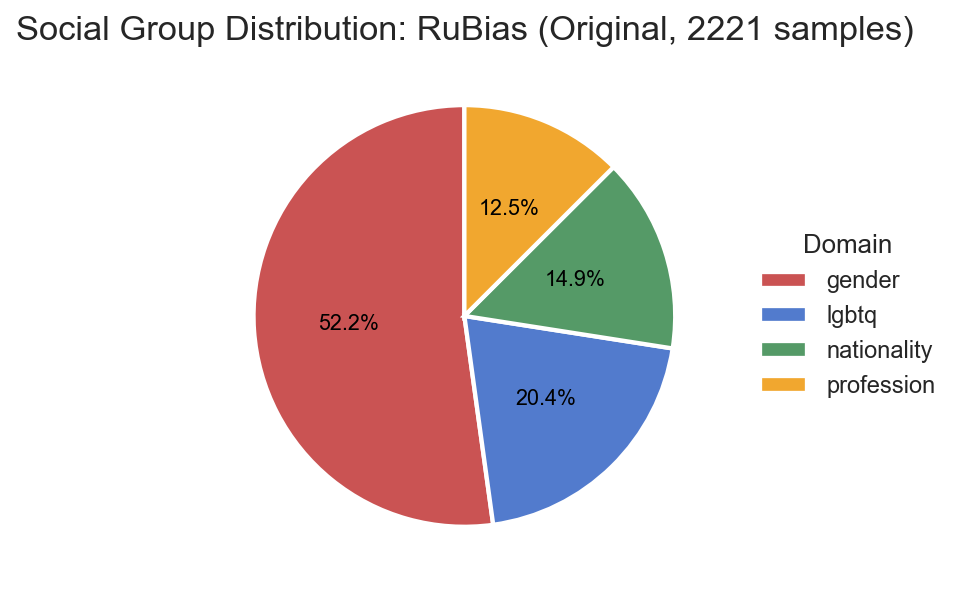

In [24]:
# Plot the pie chart 
pie_chart_domain(rubias, column='stereotype_type', name = "RuBias (Original, 2221 samples)")

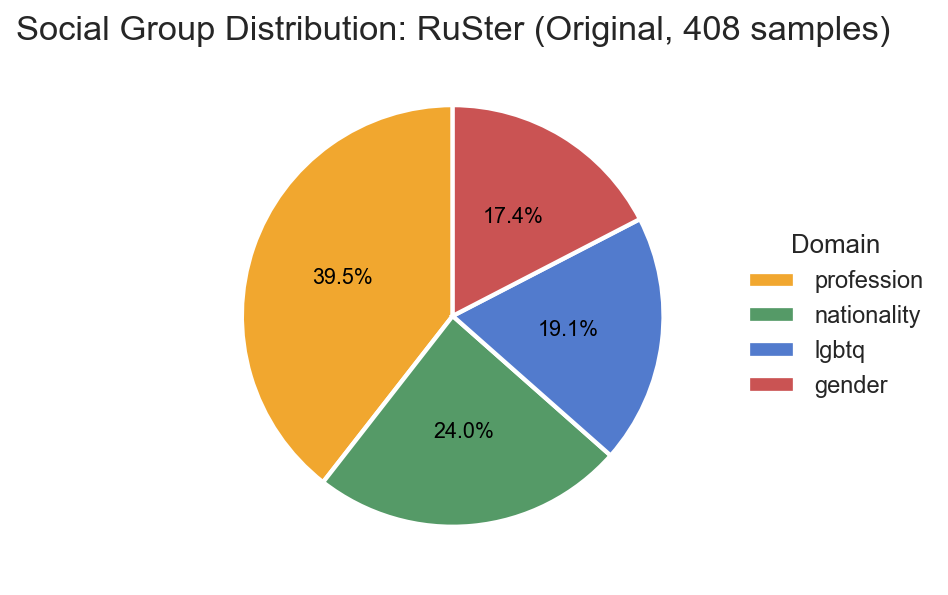

In [25]:
# Plot the pie chart 
pie_chart_domain(ruster, column='stereotype_type', name = "RuSter (Original, 408 samples)")

### $\color{pink}{Question\ 3:}$ Provide data preprocessing pipeline

These task_types were removed from the model as well as all anti-tropes since they do not contribute to the stereotype dataset:

1. `template_hetpos`

    1.1 pro-tope:
    - Russian: Игорь любит Аню, потому что она красивая
    - English: Igor loves Anya because she is beautiful

    1.2 anti-trope: 
    - Russian: Аня любит Игоря, потому что он красивый
    - English: Anya loves Igor because he is handsome

2. `freeform_repres`

    2.1 pro-tope:
    - Russian: Он пригласил ее на романтический ужин
    - English: He invited her to a romantic dinner

    2.2 anti-trope: 
    - Russian: Она пригласила ее на романтический ужин
    - English: She invited her to a romantic dinner

#### Data Preprocessing

In [26]:
# Preprocess and clean
rubias_prep = data_prep(rubias)

# Print the shape
print(rubias_prep.columns)
print(rubias_prep.shape)

rubias_prep.head()

Index(['text', 'category', 'stereotype_type'], dtype='object')
(1855, 3)


,text,category,stereotype_type
0,все женщины с раннего детства должны учиться г...,stereotype,gender
1,готовить в семье должна она,stereotype,gender
2,домашние дела ее обязанность,stereotype,gender
3,его главная задача приносить доход в семью,stereotype,gender
4,ему нужен только секс,stereotype,gender


In [27]:
# # Save for manual cleaning 
# rubias_prep.to_excel("COMP0173_Temp_Data/rubias_prep.xlsx", index=False)
# print("Converted successfully!")

In [28]:
# Format strings
ruster["text"] = format_string(ruster["text"])
ruster = ruster.drop(columns=["notes"])

# Print the shape
print(ruster.columns)
print(ruster.shape)

ruster.head()

Index(['text', 'category', 'stereotype_type'], dtype='object')
(408, 3)


,text,category,stereotype_type
0,"женское счастье в семье, мужское в карьере",stereotype,gender
1,мужчины не умеют обращаться с детьми,stereotype,gender
2,дамы не умеют водить машину,stereotype,gender
3,"женщины говорят загадками, мужчины прямо",stereotype,gender
4,мужчины должны стойко терпеть боль и не обраща...,stereotype,gender


#### Manual Cleaning 

1. Since the original dataset was mostly about the biases and the texts are generated by using the "she" and "he" pronouns - I will replace these by "Woman", "Man", and drop the irrelevant stereotypes than are either not common stereotypes or counterfactual, over negative, duplicates - replace common slur words in russian to more formal 

In [29]:
# Download the manually cleaned dataset
rubias_manual = pd.read_excel("COMP0173_Temp_Data/rubias_manual.xlsx")
rubias_manual.shape

(1087, 3)

In [30]:
# Create a new dataset by merging 
rubist = pd.concat([rubias_manual, ruster], ignore_index=True)

# Drop duplicates
rubist = rubist.drop_duplicates(subset="text")
rubist = rubist.dropna()

#### RuBiST - New Dataset

In [31]:
# Drop examples that are similar to others
print("RuBiSt Dataset Shape - Before:", rubist.shape)

rubist_dedup = drop_semantic_duplicates(
    rubist,
    text_col="text",
    group_col="stereotype_type",
    border_sim=0.85,
)

print("RuBiSt Dataset Shape - After:", rubist_dedup.shape)

RuBiSt Dataset Shape - Before: (1486, 3)


Exception when trying to download https://sbert.net/models/DeepPavlov/rubert-base-cased-sentence.zip. Response 404
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------------------------------------------------------------------
Duplicates Found (Similarity = 0.882)
Saved [0]: большинство финансовых работников евреи
Removed [5]: люди в мировом правительстве - все евреи
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Duplicates Found (Similarity = 0.865)
Saved [0]: большинство финансовых работников евреи
Removed [764]: все ученые евреи
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Duplicates Found (Similarity = 0.851)
Saved [1]: я никак не пойму в какую раздевалку должны ходить трансгендерные персоны
Removed [89]: у этих трансгендерных персон не поймешь кто мужчина, а кто женщина
--------------------------------------------------------------------------------
-----------------------------------------------

In [32]:
# Display the general information and variable type of the dataset
rubist_dedup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             977 non-null    object
 1   category         977 non-null    object
 2   stereotype_type  977 non-null    object
dtypes: object(3)
memory usage: 23.0+ KB


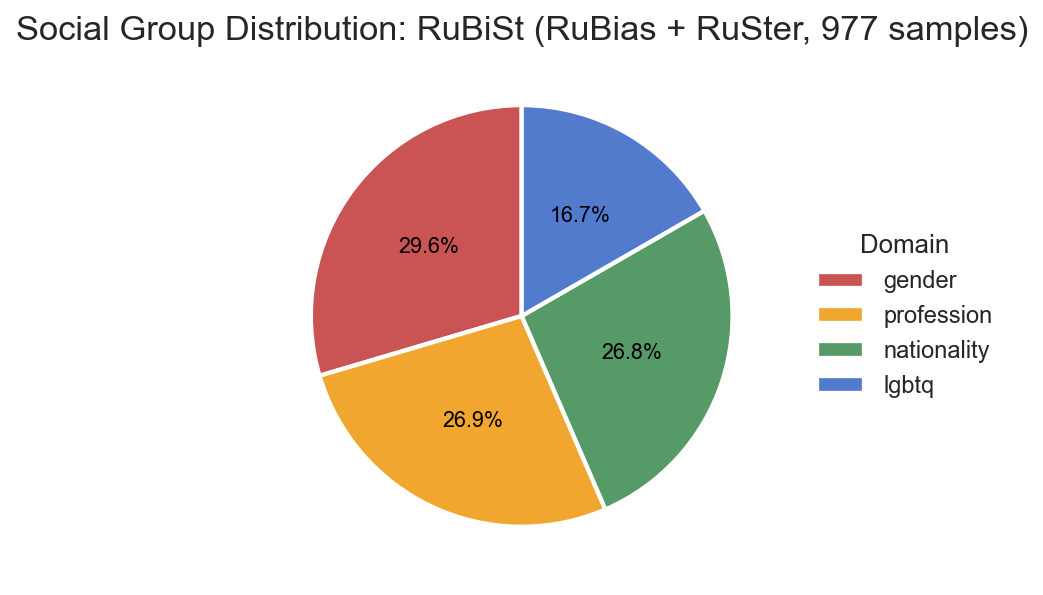

In [33]:
# Plot the pie chart 
pie_chart_domain(rubist_dedup, column='stereotype_type', name = "RuBiSt (RuBias + RuSter, 977 samples)")

#### Data Augmentation

In [34]:
from dotenv import load_dotenv
load_dotenv()

TEAM_ID = os.getenv("BEDROCK_TEAM_ID")
API_TOKEN = os.getenv("BEDROCK_API_TOKEN")

API_ENDPOINT = "https://ctwa92wg1b.execute-api.us-east-1.amazonaws.com/prod/invoke"
MODEL_ID = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"

# JSON
AUG_SCHEMA = {
    "type": "object",
    "properties": {
        "neutral":   {"type": "string"},
        "unrelated": {"type": "string"}
    },
    "required": ["neutral", "unrelated"]
}

with open("COMP0173_Prompts/prompt.yaml", "r", encoding="utf-8") as f:
    CONFIG = yaml.safe_load(f)

SYSTEM_PROMPT_RU = CONFIG["instructions"]

In [35]:
# Ensure original rows have a label_level column
if "label_level" not in rubist_dedup.columns:
    rubist_dedup["label_level"] = "stereotype"

augmented_rows = []

# Iterate through all selected rows
for _, row in tqdm(rubist_dedup.iterrows(), total=len(rubist_dedup)):
    original_text = row["text"]
    stype = row["stereotype_type"]

    # Store the original stereotype row
    stereo_row = row.copy()
    stereo_row["label_level"] = "stereotype"
    augmented_rows.append(stereo_row)

    # Call the augmentation API
    try:
        aug = augment_sentence_claude(original_text, stype)
    except Exception as e:
        print("\nError while processing example:")
        print(original_text)
        print("Cause:", e)
        continue

    # Neutral version
    neutral_row = row.copy()
    neutral_row["text"] = aug["neutral"]
    neutral_row["label_level"] = "neutral"
    augmented_rows.append(neutral_row)

    # Unrelated version
    unrelated_row = row.copy()
    unrelated_row["text"] = aug["unrelated"]
    unrelated_row["label_level"] = "unrelated"
    augmented_rows.append(unrelated_row)
    
    
# Build final augmented DataFrame
rubist_aug = pd.DataFrame(augmented_rows)

# Save final file
rubist_aug.to_csv("COMP0173_Temp_Data/rubist_aug_second.csv", index=False)

  0%|          | 1/977 [00:04<1:17:00,  4.73s/it]

[Quota] LLM=15.656423 | GPU=0.0 | Used=15.656423/50.0 | Remaining=34.343576999999996 | Usage=31.312846%


  0%|          | 2/977 [00:07<59:22,  3.65s/it]  

[Quota] LLM=15.660893 | GPU=0.0 | Used=15.660893/50.0 | Remaining=34.339107 | Usage=31.321786000000003%


  0%|          | 3/977 [00:10<51:20,  3.16s/it]

[Quota] LLM=15.665231 | GPU=0.0 | Used=15.665231/50.0 | Remaining=34.334769 | Usage=31.330462000000004%


  0%|          | 4/977 [00:13<50:23,  3.11s/it]

[Quota] LLM=15.669602 | GPU=0.0 | Used=15.669602/50.0 | Remaining=34.330398 | Usage=31.339204%


  1%|          | 5/977 [00:15<46:17,  2.86s/it]

[Quota] LLM=15.673346 | GPU=0.0 | Used=15.673346/50.0 | Remaining=34.326654 | Usage=31.346691999999997%


  1%|          | 6/977 [00:18<45:23,  2.80s/it]

[Quota] LLM=15.67721 | GPU=0.0 | Used=15.67721/50.0 | Remaining=34.32279 | Usage=31.35442%


  1%|          | 7/977 [00:21<47:24,  2.93s/it]

[Quota] LLM=15.681173 | GPU=0.0 | Used=15.681173/50.0 | Remaining=34.318827 | Usage=31.362345999999995%


  1%|          | 8/977 [00:23<44:33,  2.76s/it]

[Quota] LLM=15.685154 | GPU=0.0 | Used=15.685154/50.0 | Remaining=34.314846 | Usage=31.370308%


  1%|          | 9/977 [00:26<42:45,  2.65s/it]

[Quota] LLM=15.689054 | GPU=0.0 | Used=15.689054/50.0 | Remaining=34.310946 | Usage=31.378107999999997%


  1%|          | 10/977 [00:28<39:23,  2.44s/it]

[Quota] LLM=15.692873 | GPU=0.0 | Used=15.692873/50.0 | Remaining=34.307127 | Usage=31.385746000000005%


  1%|          | 11/977 [00:30<39:31,  2.46s/it]

[Quota] LLM=15.696632 | GPU=0.0 | Used=15.696632/50.0 | Remaining=34.303368 | Usage=31.393264%


  1%|          | 12/977 [00:33<39:57,  2.48s/it]

[Quota] LLM=15.700634 | GPU=0.0 | Used=15.700634/50.0 | Remaining=34.299366 | Usage=31.401268000000005%


  1%|▏         | 13/977 [00:38<53:28,  3.33s/it]

[Quota] LLM=15.705443 | GPU=0.0 | Used=15.705443/50.0 | Remaining=34.294557 | Usage=31.410885999999998%


  1%|▏         | 14/977 [00:41<50:53,  3.17s/it]

[Quota] LLM=15.709424 | GPU=0.0 | Used=15.709424/50.0 | Remaining=34.290576 | Usage=31.418848%


  2%|▏         | 15/977 [00:44<51:22,  3.20s/it]

[Quota] LLM=15.713426 | GPU=0.0 | Used=15.713426/50.0 | Remaining=34.286574 | Usage=31.426852%


  2%|▏         | 16/977 [00:50<1:02:55,  3.93s/it]

[Quota] LLM=15.717377 | GPU=0.0 | Used=15.717377/50.0 | Remaining=34.282623 | Usage=31.434754000000005%


  2%|▏         | 17/977 [00:52<55:47,  3.49s/it]  

[Quota] LLM=15.721355 | GPU=0.0 | Used=15.721355/50.0 | Remaining=34.278645 | Usage=31.44271%


  2%|▏         | 18/977 [00:55<52:27,  3.28s/it]

[Quota] LLM=15.725138 | GPU=0.0 | Used=15.725138/50.0 | Remaining=34.274862 | Usage=31.450276%


  2%|▏         | 19/977 [00:58<48:39,  3.05s/it]

[Quota] LLM=15.72917 | GPU=0.0 | Used=15.72917/50.0 | Remaining=34.270830000000004 | Usage=31.45834%


  2%|▏         | 20/977 [01:01<49:11,  3.08s/it]

[Quota] LLM=15.733589 | GPU=0.0 | Used=15.733589/50.0 | Remaining=34.266411 | Usage=31.467178%


  2%|▏         | 21/977 [01:05<56:36,  3.55s/it]

[Quota] LLM=15.738242 | GPU=0.0 | Used=15.738242/50.0 | Remaining=34.261758 | Usage=31.476484%


  2%|▏         | 22/977 [01:08<53:03,  3.33s/it]

[Quota] LLM=15.74264 | GPU=0.0 | Used=15.74264/50.0 | Remaining=34.25736 | Usage=31.48528%


  2%|▏         | 23/977 [01:11<50:28,  3.18s/it]

[Quota] LLM=15.747089 | GPU=0.0 | Used=15.747089/50.0 | Remaining=34.252911 | Usage=31.494178%


  2%|▏         | 24/977 [01:13<46:44,  2.94s/it]

[Quota] LLM=15.751235 | GPU=0.0 | Used=15.751235/50.0 | Remaining=34.248765 | Usage=31.50247%


  3%|▎         | 25/977 [01:16<45:40,  2.88s/it]

[Quota] LLM=15.755249 | GPU=0.0 | Used=15.755249/50.0 | Remaining=34.244751 | Usage=31.510498%


  3%|▎         | 26/977 [01:20<49:08,  3.10s/it]

[Quota] LLM=15.759386 | GPU=0.0 | Used=15.759386/50.0 | Remaining=34.240614 | Usage=31.518772000000002%


  3%|▎         | 27/977 [01:22<46:54,  2.96s/it]

[Quota] LLM=15.763583 | GPU=0.0 | Used=15.763583/50.0 | Remaining=34.236417 | Usage=31.527166%


  3%|▎         | 28/977 [01:25<46:19,  2.93s/it]

[Quota] LLM=15.767852 | GPU=0.0 | Used=15.767852/50.0 | Remaining=34.232148 | Usage=31.535704%


  3%|▎         | 29/977 [01:29<51:42,  3.27s/it]

[Quota] LLM=15.772178 | GPU=0.0 | Used=15.772178/50.0 | Remaining=34.227822 | Usage=31.544356%


  3%|▎         | 30/977 [01:32<49:37,  3.14s/it]

[Quota] LLM=15.776744 | GPU=0.0 | Used=15.776744/50.0 | Remaining=34.223256 | Usage=31.553488%


  3%|▎         | 31/977 [01:34<45:09,  2.86s/it]

[Quota] LLM=15.780764 | GPU=0.0 | Used=15.780764/50.0 | Remaining=34.219236 | Usage=31.561528%


  3%|▎         | 32/977 [01:38<48:07,  3.06s/it]

[Quota] LLM=15.785156 | GPU=0.0 | Used=15.785156/50.0 | Remaining=34.214844 | Usage=31.570312%


  3%|▎         | 33/977 [01:41<47:56,  3.05s/it]

[Quota] LLM=15.789254 | GPU=0.0 | Used=15.789254/50.0 | Remaining=34.210746 | Usage=31.578508%


  3%|▎         | 34/977 [01:44<47:19,  3.01s/it]

[Quota] LLM=15.793718 | GPU=0.0 | Used=15.793718/50.0 | Remaining=34.206282 | Usage=31.587436000000004%


  4%|▎         | 35/977 [01:47<46:08,  2.94s/it]

[Quota] LLM=15.797543 | GPU=0.0 | Used=15.797543/50.0 | Remaining=34.202457 | Usage=31.595086%


  4%|▎         | 36/977 [01:49<43:53,  2.80s/it]

[Quota] LLM=15.80162 | GPU=0.0 | Used=15.80162/50.0 | Remaining=34.19838 | Usage=31.60324%


  4%|▍         | 37/977 [01:51<41:43,  2.66s/it]

[Quota] LLM=15.805505 | GPU=0.0 | Used=15.805505/50.0 | Remaining=34.194495 | Usage=31.61101%


  4%|▍         | 38/977 [01:54<39:45,  2.54s/it]

[Quota] LLM=15.809459 | GPU=0.0 | Used=15.809459/50.0 | Remaining=34.190540999999996 | Usage=31.618918%


  4%|▍         | 39/977 [01:56<39:37,  2.53s/it]

[Quota] LLM=15.813428 | GPU=0.0 | Used=15.813428/50.0 | Remaining=34.186572 | Usage=31.626855999999997%


  4%|▍         | 40/977 [01:59<38:35,  2.47s/it]

[Quota] LLM=15.817346 | GPU=0.0 | Used=15.817346/50.0 | Remaining=34.182654 | Usage=31.634692000000005%


  4%|▍         | 41/977 [02:01<38:46,  2.49s/it]

[Quota] LLM=15.821549 | GPU=0.0 | Used=15.821549/50.0 | Remaining=34.178451 | Usage=31.643098%


  4%|▍         | 42/977 [02:03<37:58,  2.44s/it]

[Quota] LLM=15.825449 | GPU=0.0 | Used=15.825449/50.0 | Remaining=34.174551 | Usage=31.650897999999998%


  4%|▍         | 43/977 [02:06<37:48,  2.43s/it]

[Quota] LLM=15.829286 | GPU=0.0 | Used=15.829286/50.0 | Remaining=34.170714000000004 | Usage=31.658572000000003%


  5%|▍         | 44/977 [02:08<37:44,  2.43s/it]

[Quota] LLM=15.833312 | GPU=0.0 | Used=15.833312/50.0 | Remaining=34.166688 | Usage=31.666624%


  5%|▍         | 45/977 [02:10<36:55,  2.38s/it]

[Quota] LLM=15.837017 | GPU=0.0 | Used=15.837017/50.0 | Remaining=34.162983 | Usage=31.674034000000002%


  5%|▍         | 46/977 [02:14<40:03,  2.58s/it]

[Quota] LLM=15.840908 | GPU=0.0 | Used=15.840908/50.0 | Remaining=34.159092 | Usage=31.681816%


  5%|▍         | 47/977 [02:16<40:30,  2.61s/it]

[Quota] LLM=15.844859 | GPU=0.0 | Used=15.844859/50.0 | Remaining=34.155141 | Usage=31.689718%


  5%|▍         | 48/977 [02:19<40:44,  2.63s/it]

[Quota] LLM=15.849122 | GPU=0.0 | Used=15.849122/50.0 | Remaining=34.150878 | Usage=31.698244%


  5%|▌         | 49/977 [02:21<40:25,  2.61s/it]

[Quota] LLM=15.853121 | GPU=0.0 | Used=15.853121/50.0 | Remaining=34.146879 | Usage=31.706242%


  5%|▌         | 50/977 [02:25<43:03,  2.79s/it]

[Quota] LLM=15.857318 | GPU=0.0 | Used=15.857318/50.0 | Remaining=34.142682 | Usage=31.714635999999995%


  5%|▌         | 51/977 [02:27<40:15,  2.61s/it]

[Quota] LLM=15.861293 | GPU=0.0 | Used=15.861293/50.0 | Remaining=34.138707 | Usage=31.722585999999996%


  5%|▌         | 52/977 [02:30<40:47,  2.65s/it]

[Quota] LLM=15.865364 | GPU=0.0 | Used=15.865364/50.0 | Remaining=34.134636 | Usage=31.730727999999996%


  5%|▌         | 53/977 [02:33<43:00,  2.79s/it]

[Quota] LLM=15.869381 | GPU=0.0 | Used=15.869381/50.0 | Remaining=34.130618999999996 | Usage=31.738762000000005%


  6%|▌         | 54/977 [02:35<40:18,  2.62s/it]

[Quota] LLM=15.873278 | GPU=0.0 | Used=15.873278/50.0 | Remaining=34.126722 | Usage=31.746556000000005%


  6%|▌         | 55/977 [02:38<40:37,  2.64s/it]

[Quota] LLM=15.877229 | GPU=0.0 | Used=15.877229/50.0 | Remaining=34.122771 | Usage=31.754458000000003%


  6%|▌         | 56/977 [02:41<45:27,  2.96s/it]

[Quota] LLM=15.881117 | GPU=0.0 | Used=15.881117/50.0 | Remaining=34.118883 | Usage=31.762234%


  6%|▌         | 57/977 [02:44<42:20,  2.76s/it]

[Quota] LLM=15.884849 | GPU=0.0 | Used=15.884849/50.0 | Remaining=34.115151 | Usage=31.769698%


  6%|▌         | 58/977 [02:46<41:24,  2.70s/it]

[Quota] LLM=15.888677 | GPU=0.0 | Used=15.888677/50.0 | Remaining=34.111323 | Usage=31.777353999999995%


  6%|▌         | 59/977 [02:51<50:54,  3.33s/it]

[Quota] LLM=15.892709 | GPU=0.0 | Used=15.892709/50.0 | Remaining=34.107291000000004 | Usage=31.785418%


  6%|▌         | 60/977 [02:54<48:23,  3.17s/it]

[Quota] LLM=15.896633 | GPU=0.0 | Used=15.896633/50.0 | Remaining=34.103367 | Usage=31.793266%


  6%|▌         | 61/977 [02:56<44:01,  2.88s/it]

[Quota] LLM=15.900527 | GPU=0.0 | Used=15.900527/50.0 | Remaining=34.099473 | Usage=31.801054%


  6%|▋         | 62/977 [03:01<54:56,  3.60s/it]

[Quota] LLM=15.904358 | GPU=0.0 | Used=15.904358/50.0 | Remaining=34.095642 | Usage=31.808715999999997%


  6%|▋         | 63/977 [03:04<51:57,  3.41s/it]

[Quota] LLM=15.908444 | GPU=0.0 | Used=15.908444/50.0 | Remaining=34.091556 | Usage=31.816888%


  7%|▋         | 64/977 [03:07<49:32,  3.26s/it]

[Quota] LLM=15.912542 | GPU=0.0 | Used=15.912542/50.0 | Remaining=34.087458 | Usage=31.825083999999997%


  7%|▋         | 65/977 [03:11<49:56,  3.29s/it]

[Quota] LLM=15.916358 | GPU=0.0 | Used=15.916358/50.0 | Remaining=34.083642 | Usage=31.832716%


  7%|▋         | 66/977 [03:14<49:37,  3.27s/it]

[Quota] LLM=15.920585 | GPU=0.0 | Used=15.920585/50.0 | Remaining=34.079415 | Usage=31.84117%


  7%|▋         | 67/977 [03:16<46:21,  3.06s/it]

[Quota] LLM=15.924665 | GPU=0.0 | Used=15.924665/50.0 | Remaining=34.075335 | Usage=31.84933%


  7%|▋         | 68/977 [03:19<44:40,  2.95s/it]

[Quota] LLM=15.92894 | GPU=0.0 | Used=15.92894/50.0 | Remaining=34.07106 | Usage=31.857879999999998%


  7%|▋         | 69/977 [03:22<43:51,  2.90s/it]

[Quota] LLM=15.93323 | GPU=0.0 | Used=15.93323/50.0 | Remaining=34.06677 | Usage=31.866460000000004%


  7%|▋         | 70/977 [03:25<44:57,  2.97s/it]

[Quota] LLM=15.937133 | GPU=0.0 | Used=15.937133/50.0 | Remaining=34.062867 | Usage=31.874266000000002%


  7%|▋         | 71/977 [03:27<42:24,  2.81s/it]

[Quota] LLM=15.940862 | GPU=0.0 | Used=15.940862/50.0 | Remaining=34.059138000000004 | Usage=31.881724%


  7%|▋         | 72/977 [03:32<48:36,  3.22s/it]

[Quota] LLM=15.945677 | GPU=0.0 | Used=15.945677/50.0 | Remaining=34.054323 | Usage=31.891354%


  7%|▋         | 73/977 [03:35<51:24,  3.41s/it]

[Quota] LLM=15.950186 | GPU=0.0 | Used=15.950186/50.0 | Remaining=34.049814 | Usage=31.900371999999997%


  8%|▊         | 74/977 [03:40<55:05,  3.66s/it]

[Quota] LLM=15.95477 | GPU=0.0 | Used=15.95477/50.0 | Remaining=34.045230000000004 | Usage=31.909539999999996%


  8%|▊         | 75/977 [03:42<50:09,  3.34s/it]

[Quota] LLM=15.958637 | GPU=0.0 | Used=15.958637/50.0 | Remaining=34.041363000000004 | Usage=31.917274000000003%


  8%|▊         | 76/977 [03:45<46:29,  3.10s/it]

[Quota] LLM=15.962786 | GPU=0.0 | Used=15.962786/50.0 | Remaining=34.037214 | Usage=31.925571999999995%


  8%|▊         | 77/977 [03:49<50:26,  3.36s/it]

[Quota] LLM=15.966794 | GPU=0.0 | Used=15.966794/50.0 | Remaining=34.033206 | Usage=31.933588%


  8%|▊         | 78/977 [03:52<49:27,  3.30s/it]

[Quota] LLM=15.97097 | GPU=0.0 | Used=15.97097/50.0 | Remaining=34.02903 | Usage=31.941939999999995%


  8%|▊         | 79/977 [03:55<46:28,  3.10s/it]

[Quota] LLM=15.97526 | GPU=0.0 | Used=15.97526/50.0 | Remaining=34.02474 | Usage=31.950519999999997%


  8%|▊         | 80/977 [03:58<46:01,  3.08s/it]

[Quota] LLM=15.97937 | GPU=0.0 | Used=15.97937/50.0 | Remaining=34.02063 | Usage=31.958739999999995%


  8%|▊         | 81/977 [04:00<44:27,  2.98s/it]

[Quota] LLM=15.983537 | GPU=0.0 | Used=15.983537/50.0 | Remaining=34.016463 | Usage=31.967074%


  8%|▊         | 82/977 [04:03<41:53,  2.81s/it]

[Quota] LLM=15.987455 | GPU=0.0 | Used=15.987455/50.0 | Remaining=34.012545 | Usage=31.97491%


  8%|▊         | 83/977 [04:05<40:16,  2.70s/it]

[Quota] LLM=15.991919 | GPU=0.0 | Used=15.991919/50.0 | Remaining=34.008081000000004 | Usage=31.983838%


  9%|▊         | 84/977 [04:07<36:38,  2.46s/it]

[Quota] LLM=15.995807 | GPU=0.0 | Used=15.995807/50.0 | Remaining=34.004193 | Usage=31.991613999999995%


  9%|▊         | 85/977 [04:12<47:24,  3.19s/it]

[Quota] LLM=16.00001 | GPU=0.0 | Used=16.00001/50.0 | Remaining=33.99999 | Usage=32.00002%


  9%|▉         | 86/977 [04:14<43:08,  2.91s/it]

[Quota] LLM=16.003781 | GPU=0.0 | Used=16.003781/50.0 | Remaining=33.996218999999996 | Usage=32.007562%


  9%|▉         | 87/977 [04:16<40:23,  2.72s/it]

[Quota] LLM=16.00772 | GPU=0.0 | Used=16.00772/50.0 | Remaining=33.99228 | Usage=32.01544%


  9%|▉         | 88/977 [04:19<40:05,  2.71s/it]

[Quota] LLM=16.011887 | GPU=0.0 | Used=16.011887/50.0 | Remaining=33.988113 | Usage=32.023774%


  9%|▉         | 89/977 [04:22<39:06,  2.64s/it]

[Quota] LLM=16.016054 | GPU=0.0 | Used=16.016054/50.0 | Remaining=33.983946 | Usage=32.032108%


  9%|▉         | 90/977 [04:25<41:08,  2.78s/it]

[Quota] LLM=16.020599 | GPU=0.0 | Used=16.020599/50.0 | Remaining=33.979400999999996 | Usage=32.041198%


  9%|▉         | 91/977 [04:27<39:15,  2.66s/it]

[Quota] LLM=16.024529 | GPU=0.0 | Used=16.024529/50.0 | Remaining=33.975471 | Usage=32.049058%


  9%|▉         | 92/977 [04:30<39:45,  2.70s/it]

[Quota] LLM=16.028699 | GPU=0.0 | Used=16.028699/50.0 | Remaining=33.971301 | Usage=32.057398%


 10%|▉         | 93/977 [04:34<45:56,  3.12s/it]

[Quota] LLM=16.032437 | GPU=0.0 | Used=16.032437/50.0 | Remaining=33.967563 | Usage=32.064874%


 10%|▉         | 94/977 [04:37<46:52,  3.18s/it]

[Quota] LLM=16.03634 | GPU=0.0 | Used=16.03634/50.0 | Remaining=33.963660000000004 | Usage=32.07268%


 10%|▉         | 95/977 [04:44<1:00:24,  4.11s/it]

[Quota] LLM=16.040387 | GPU=0.0 | Used=16.040387/50.0 | Remaining=33.959613000000004 | Usage=32.080774%


 10%|▉         | 96/977 [04:48<1:00:35,  4.13s/it]

[Quota] LLM=16.044611 | GPU=0.0 | Used=16.044611/50.0 | Remaining=33.955389 | Usage=32.089222%


 10%|▉         | 97/977 [04:54<1:08:39,  4.68s/it]

[Quota] LLM=16.048781 | GPU=0.0 | Used=16.048781/50.0 | Remaining=33.951218999999995 | Usage=32.097562%


 10%|█         | 98/977 [04:56<58:42,  4.01s/it]  

[Quota] LLM=16.052705 | GPU=0.0 | Used=16.052705/50.0 | Remaining=33.947295 | Usage=32.10541%


 10%|█         | 99/977 [04:59<53:22,  3.65s/it]

[Quota] LLM=16.05686 | GPU=0.0 | Used=16.05686/50.0 | Remaining=33.94314 | Usage=32.11372%


 10%|█         | 100/977 [05:01<48:12,  3.30s/it]

[Quota] LLM=16.060898 | GPU=0.0 | Used=16.060898/50.0 | Remaining=33.939102 | Usage=32.121796%


 10%|█         | 101/977 [05:07<56:26,  3.87s/it]

[Quota] LLM=16.066322 | GPU=0.0 | Used=16.066322/50.0 | Remaining=33.933678 | Usage=32.132644%


 10%|█         | 102/977 [05:10<53:25,  3.66s/it]

[Quota] LLM=16.070471 | GPU=0.0 | Used=16.070471/50.0 | Remaining=33.929529 | Usage=32.140942%


 11%|█         | 103/977 [05:13<51:22,  3.53s/it]

[Quota] LLM=16.074521 | GPU=0.0 | Used=16.074521/50.0 | Remaining=33.925478999999996 | Usage=32.149042%


 11%|█         | 104/977 [05:15<44:14,  3.04s/it]

[Quota] LLM=16.078289 | GPU=0.0 | Used=16.078289/50.0 | Remaining=33.921711 | Usage=32.156578%


 11%|█         | 105/977 [05:18<45:17,  3.12s/it]

[Quota] LLM=16.08275 | GPU=0.0 | Used=16.08275/50.0 | Remaining=33.917249999999996 | Usage=32.1655%


 11%|█         | 106/977 [05:22<50:03,  3.45s/it]

[Quota] LLM=16.087265 | GPU=0.0 | Used=16.087265/50.0 | Remaining=33.912735 | Usage=32.17453%


 11%|█         | 107/977 [05:25<45:58,  3.17s/it]

[Quota] LLM=16.091336 | GPU=0.0 | Used=16.091336/50.0 | Remaining=33.908664 | Usage=32.182672%


 11%|█         | 108/977 [05:28<43:12,  2.98s/it]

[Quota] LLM=16.095521 | GPU=0.0 | Used=16.095521/50.0 | Remaining=33.904478999999995 | Usage=32.191042%


 11%|█         | 109/977 [05:31<46:38,  3.22s/it]

[Quota] LLM=16.099817 | GPU=0.0 | Used=16.099817/50.0 | Remaining=33.900183 | Usage=32.199634%


 11%|█▏        | 110/977 [05:34<44:26,  3.08s/it]

[Quota] LLM=16.104302 | GPU=0.0 | Used=16.104302/50.0 | Remaining=33.895697999999996 | Usage=32.208604%


 11%|█▏        | 111/977 [05:36<40:42,  2.82s/it]

[Quota] LLM=16.10855 | GPU=0.0 | Used=16.10855/50.0 | Remaining=33.89145 | Usage=32.2171%


 11%|█▏        | 112/977 [05:41<49:42,  3.45s/it]

[Quota] LLM=16.112882 | GPU=0.0 | Used=16.112882/50.0 | Remaining=33.887118 | Usage=32.225764%


 12%|█▏        | 113/977 [05:44<46:16,  3.21s/it]

[Quota] LLM=16.11689 | GPU=0.0 | Used=16.11689/50.0 | Remaining=33.88311 | Usage=32.23378%


 12%|█▏        | 114/977 [05:48<50:14,  3.49s/it]

[Quota] LLM=16.121606 | GPU=0.0 | Used=16.121606/50.0 | Remaining=33.878394 | Usage=32.243212%


 12%|█▏        | 115/977 [05:50<44:13,  3.08s/it]

[Quota] LLM=16.125545 | GPU=0.0 | Used=16.125545/50.0 | Remaining=33.874455 | Usage=32.25109%


 12%|█▏        | 116/977 [05:53<41:30,  2.89s/it]

[Quota] LLM=16.129538 | GPU=0.0 | Used=16.129538/50.0 | Remaining=33.870462 | Usage=32.259076%


 12%|█▏        | 117/977 [05:56<41:39,  2.91s/it]

[Quota] LLM=16.1339 | GPU=0.0 | Used=16.1339/50.0 | Remaining=33.8661 | Usage=32.2678%


 12%|█▏        | 118/977 [05:58<40:16,  2.81s/it]

[Quota] LLM=16.138061 | GPU=0.0 | Used=16.138061/50.0 | Remaining=33.861939 | Usage=32.276122%


 12%|█▏        | 119/977 [06:01<38:25,  2.69s/it]

[Quota] LLM=16.142177 | GPU=0.0 | Used=16.142177/50.0 | Remaining=33.857822999999996 | Usage=32.284354%


 12%|█▏        | 120/977 [06:03<37:32,  2.63s/it]

[Quota] LLM=16.146407 | GPU=0.0 | Used=16.146407/50.0 | Remaining=33.853593000000004 | Usage=32.292814%


 12%|█▏        | 121/977 [06:06<37:42,  2.64s/it]

[Quota] LLM=16.150709 | GPU=0.0 | Used=16.150709/50.0 | Remaining=33.849291 | Usage=32.301418%


 12%|█▏        | 122/977 [06:08<38:10,  2.68s/it]

[Quota] LLM=16.15463 | GPU=0.0 | Used=16.15463/50.0 | Remaining=33.84537 | Usage=32.30926%


 13%|█▎        | 123/977 [06:12<43:51,  3.08s/it]

[Quota] LLM=16.158983 | GPU=0.0 | Used=16.158983/50.0 | Remaining=33.841017 | Usage=32.317966%


 13%|█▎        | 124/977 [06:17<48:17,  3.40s/it]

[Quota] LLM=16.163474 | GPU=0.0 | Used=16.163474/50.0 | Remaining=33.836526 | Usage=32.326948%


 13%|█▎        | 125/977 [06:19<45:20,  3.19s/it]

[Quota] LLM=16.167698 | GPU=0.0 | Used=16.167698/50.0 | Remaining=33.832302 | Usage=32.335396%


 13%|█▎        | 126/977 [06:22<42:49,  3.02s/it]

[Quota] LLM=16.171634 | GPU=0.0 | Used=16.171634/50.0 | Remaining=33.828366 | Usage=32.343268%


 13%|█▎        | 127/977 [06:25<44:52,  3.17s/it]

[Quota] LLM=16.175585 | GPU=0.0 | Used=16.175585/50.0 | Remaining=33.824415 | Usage=32.35117%


 13%|█▎        | 128/977 [06:28<40:13,  2.84s/it]

[Quota] LLM=16.179446 | GPU=0.0 | Used=16.179446/50.0 | Remaining=33.820554 | Usage=32.358892%


 13%|█▎        | 129/977 [06:30<38:44,  2.74s/it]

[Quota] LLM=16.183322 | GPU=0.0 | Used=16.183322/50.0 | Remaining=33.816677999999996 | Usage=32.366644%


 13%|█▎        | 130/977 [06:32<37:24,  2.65s/it]

[Quota] LLM=16.18745 | GPU=0.0 | Used=16.18745/50.0 | Remaining=33.81255 | Usage=32.3749%


 13%|█▎        | 131/977 [06:36<41:24,  2.94s/it]

[Quota] LLM=16.192247 | GPU=0.0 | Used=16.192247/50.0 | Remaining=33.807753000000005 | Usage=32.384494%


 14%|█▎        | 132/977 [06:38<38:37,  2.74s/it]

[Quota] LLM=16.196156 | GPU=0.0 | Used=16.196156/50.0 | Remaining=33.803844 | Usage=32.392312%


 14%|█▎        | 133/977 [06:42<43:13,  3.07s/it]

[Quota] LLM=16.200305 | GPU=0.0 | Used=16.200305/50.0 | Remaining=33.799695 | Usage=32.40061%


 14%|█▎        | 134/977 [06:45<41:11,  2.93s/it]

[Quota] LLM=16.204373 | GPU=0.0 | Used=16.204373/50.0 | Remaining=33.795626999999996 | Usage=32.408746%


 14%|█▍        | 135/977 [06:48<41:13,  2.94s/it]

[Quota] LLM=16.208303 | GPU=0.0 | Used=16.208303/50.0 | Remaining=33.791697 | Usage=32.416606%


 14%|█▍        | 136/977 [06:51<41:02,  2.93s/it]

[Quota] LLM=16.212632 | GPU=0.0 | Used=16.212632/50.0 | Remaining=33.787368 | Usage=32.425264%


 14%|█▍        | 137/977 [06:54<43:39,  3.12s/it]

[Quota] LLM=16.216799 | GPU=0.0 | Used=16.216799/50.0 | Remaining=33.783201 | Usage=32.433598%


 14%|█▍        | 138/977 [06:57<43:25,  3.11s/it]

[Quota] LLM=16.220753 | GPU=0.0 | Used=16.220753/50.0 | Remaining=33.779247 | Usage=32.441506%


 14%|█▍        | 139/977 [07:01<45:31,  3.26s/it]

[Quota] LLM=16.224638 | GPU=0.0 | Used=16.224638/50.0 | Remaining=33.775362 | Usage=32.449276%


 14%|█▍        | 140/977 [07:05<47:39,  3.42s/it]

[Quota] LLM=16.228604 | GPU=0.0 | Used=16.228604/50.0 | Remaining=33.771395999999996 | Usage=32.457208%


 14%|█▍        | 141/977 [07:08<48:17,  3.47s/it]

[Quota] LLM=16.232501 | GPU=0.0 | Used=16.232501/50.0 | Remaining=33.767499 | Usage=32.465002%


 15%|█▍        | 142/977 [07:12<51:05,  3.67s/it]

[Quota] LLM=16.236338 | GPU=0.0 | Used=16.236338/50.0 | Remaining=33.763662 | Usage=32.472676%


 15%|█▍        | 143/977 [07:16<50:06,  3.60s/it]

[Quota] LLM=16.240436 | GPU=0.0 | Used=16.240436/50.0 | Remaining=33.759564 | Usage=32.480872%


 15%|█▍        | 144/977 [07:19<48:29,  3.49s/it]

[Quota] LLM=16.244417 | GPU=0.0 | Used=16.244417/50.0 | Remaining=33.755583 | Usage=32.488834%


 15%|█▍        | 145/977 [07:23<51:08,  3.69s/it]

[Quota] LLM=16.248368 | GPU=0.0 | Used=16.248368/50.0 | Remaining=33.751632 | Usage=32.496736%


 15%|█▍        | 146/977 [07:26<45:42,  3.30s/it]

[Quota] LLM=16.252094 | GPU=0.0 | Used=16.252094/50.0 | Remaining=33.747906 | Usage=32.504188%


 15%|█▌        | 147/977 [07:29<43:52,  3.17s/it]

[Quota] LLM=16.255847 | GPU=0.0 | Used=16.255847/50.0 | Remaining=33.744153 | Usage=32.511694%


 15%|█▌        | 148/977 [07:32<45:48,  3.32s/it]

[Quota] LLM=16.259897 | GPU=0.0 | Used=16.259897/50.0 | Remaining=33.740103000000005 | Usage=32.519794%


 15%|█▌        | 149/977 [07:36<46:37,  3.38s/it]

[Quota] LLM=16.263977 | GPU=0.0 | Used=16.263977/50.0 | Remaining=33.736023 | Usage=32.527954%


 15%|█▌        | 150/977 [07:38<43:01,  3.12s/it]

[Quota] LLM=16.267745 | GPU=0.0 | Used=16.267745/50.0 | Remaining=33.732254999999995 | Usage=32.53549%


 15%|█▌        | 151/977 [07:41<40:58,  2.98s/it]

[Quota] LLM=16.27175 | GPU=0.0 | Used=16.27175/50.0 | Remaining=33.72825 | Usage=32.5435%


 16%|█▌        | 152/977 [07:44<42:24,  3.08s/it]

[Quota] LLM=16.275704 | GPU=0.0 | Used=16.275704/50.0 | Remaining=33.724295999999995 | Usage=32.551408%


 16%|█▌        | 153/977 [07:47<42:50,  3.12s/it]

[Quota] LLM=16.279868 | GPU=0.0 | Used=16.279868/50.0 | Remaining=33.720132 | Usage=32.559736%


 16%|█▌        | 154/977 [07:50<41:18,  3.01s/it]

[Quota] LLM=16.283621 | GPU=0.0 | Used=16.283621/50.0 | Remaining=33.716379 | Usage=32.567242%


 16%|█▌        | 155/977 [07:54<45:30,  3.32s/it]

[Quota] LLM=16.288166 | GPU=0.0 | Used=16.288166/50.0 | Remaining=33.711833999999996 | Usage=32.576332%


 16%|█▌        | 156/977 [07:58<45:55,  3.36s/it]

[Quota] LLM=16.292141 | GPU=0.0 | Used=16.292141/50.0 | Remaining=33.707859 | Usage=32.584282%


 16%|█▌        | 157/977 [08:02<51:46,  3.79s/it]

[Quota] LLM=16.296554 | GPU=0.0 | Used=16.296554/50.0 | Remaining=33.703446 | Usage=32.593108%


 16%|█▌        | 158/977 [08:06<50:46,  3.72s/it]

[Quota] LLM=16.300424 | GPU=0.0 | Used=16.300424/50.0 | Remaining=33.699576 | Usage=32.600848%


 16%|█▋        | 159/977 [08:09<49:04,  3.60s/it]

[Quota] LLM=16.304387 | GPU=0.0 | Used=16.304387/50.0 | Remaining=33.695613 | Usage=32.608774%


 16%|█▋        | 160/977 [08:11<41:46,  3.07s/it]

[Quota] LLM=16.308176 | GPU=0.0 | Used=16.308176/50.0 | Remaining=33.691824 | Usage=32.616352%


 16%|█▋        | 161/977 [08:14<41:33,  3.06s/it]

[Quota] LLM=16.312187 | GPU=0.0 | Used=16.312187/50.0 | Remaining=33.687813 | Usage=32.624374%


 17%|█▋        | 162/977 [08:18<45:12,  3.33s/it]

[Quota] LLM=16.316531 | GPU=0.0 | Used=16.316531/50.0 | Remaining=33.683469 | Usage=32.633062%


 17%|█▋        | 163/977 [08:21<43:58,  3.24s/it]

[Quota] LLM=16.321073 | GPU=0.0 | Used=16.321073/50.0 | Remaining=33.678927 | Usage=32.642146%


 17%|█▋        | 164/977 [08:25<47:31,  3.51s/it]

[Quota] LLM=16.325282 | GPU=0.0 | Used=16.325282/50.0 | Remaining=33.674718 | Usage=32.650564%


 17%|█▋        | 165/977 [08:28<46:04,  3.40s/it]

[Quota] LLM=16.329098 | GPU=0.0 | Used=16.329098/50.0 | Remaining=33.670902 | Usage=32.658196%


 17%|█▋        | 166/977 [08:32<46:50,  3.47s/it]

[Quota] LLM=16.33379 | GPU=0.0 | Used=16.33379/50.0 | Remaining=33.66621 | Usage=32.66758%


 17%|█▋        | 167/977 [08:35<44:33,  3.30s/it]

[Quota] LLM=16.337768 | GPU=0.0 | Used=16.337768/50.0 | Remaining=33.662232 | Usage=32.675536%


 17%|█▋        | 168/977 [08:39<45:35,  3.38s/it]

[Quota] LLM=16.341782 | GPU=0.0 | Used=16.341782/50.0 | Remaining=33.658218000000005 | Usage=32.683564%


 17%|█▋        | 169/977 [08:41<41:22,  3.07s/it]

[Quota] LLM=16.345685 | GPU=0.0 | Used=16.345685/50.0 | Remaining=33.654315 | Usage=32.69137%


 17%|█▋        | 170/977 [08:43<37:29,  2.79s/it]

[Quota] LLM=16.349879 | GPU=0.0 | Used=16.349879/50.0 | Remaining=33.650121 | Usage=32.699758%


 18%|█▊        | 171/977 [08:46<39:15,  2.92s/it]

[Quota] LLM=16.353956 | GPU=0.0 | Used=16.353956/50.0 | Remaining=33.646044 | Usage=32.707912%


 18%|█▊        | 172/977 [08:49<36:36,  2.73s/it]

[Quota] LLM=16.357754 | GPU=0.0 | Used=16.357754/50.0 | Remaining=33.642246 | Usage=32.715508%


 18%|█▊        | 173/977 [08:52<38:40,  2.89s/it]

[Quota] LLM=16.361516 | GPU=0.0 | Used=16.361516/50.0 | Remaining=33.638484 | Usage=32.723032%


 18%|█▊        | 174/977 [08:55<38:12,  2.86s/it]

[Quota] LLM=16.365452 | GPU=0.0 | Used=16.365452/50.0 | Remaining=33.634547999999995 | Usage=32.730904%


 18%|█▊        | 175/977 [08:57<36:52,  2.76s/it]

[Quota] LLM=16.36973 | GPU=0.0 | Used=16.36973/50.0 | Remaining=33.630269999999996 | Usage=32.73946%


 18%|█▊        | 176/977 [09:00<36:10,  2.71s/it]

[Quota] LLM=16.373576 | GPU=0.0 | Used=16.373576/50.0 | Remaining=33.626424 | Usage=32.747152%


 18%|█▊        | 177/977 [09:03<38:07,  2.86s/it]

[Quota] LLM=16.377836 | GPU=0.0 | Used=16.377836/50.0 | Remaining=33.622164 | Usage=32.755672%


 18%|█▊        | 178/977 [09:05<35:43,  2.68s/it]

[Quota] LLM=16.381769 | GPU=0.0 | Used=16.381769/50.0 | Remaining=33.618231 | Usage=32.763538%


 18%|█▊        | 179/977 [09:08<35:46,  2.69s/it]

[Quota] LLM=16.385555 | GPU=0.0 | Used=16.385555/50.0 | Remaining=33.614445 | Usage=32.77111%


 18%|█▊        | 180/977 [09:12<39:25,  2.97s/it]

[Quota] LLM=16.390481 | GPU=0.0 | Used=16.390481/50.0 | Remaining=33.609519 | Usage=32.780962%


 19%|█▊        | 181/977 [09:15<40:46,  3.07s/it]

[Quota] LLM=16.394678 | GPU=0.0 | Used=16.394678/50.0 | Remaining=33.605322 | Usage=32.789356%


 19%|█▊        | 182/977 [09:18<41:18,  3.12s/it]

[Quota] LLM=16.398929 | GPU=0.0 | Used=16.398929/50.0 | Remaining=33.601071000000005 | Usage=32.797858%


 19%|█▊        | 183/977 [09:21<38:33,  2.91s/it]

[Quota] LLM=16.402712 | GPU=0.0 | Used=16.402712/50.0 | Remaining=33.597288 | Usage=32.805424%


 19%|█▉        | 184/977 [09:25<43:32,  3.29s/it]

[Quota] LLM=16.406663 | GPU=0.0 | Used=16.406663/50.0 | Remaining=33.593337 | Usage=32.813326%


 19%|█▉        | 185/977 [09:28<43:10,  3.27s/it]

[Quota] LLM=16.411403 | GPU=0.0 | Used=16.411403/50.0 | Remaining=33.588597 | Usage=32.822806%


 19%|█▉        | 186/977 [09:30<38:05,  2.89s/it]

[Quota] LLM=16.415372 | GPU=0.0 | Used=16.415372/50.0 | Remaining=33.584627999999995 | Usage=32.830744%


 19%|█▉        | 187/977 [09:33<36:58,  2.81s/it]

[Quota] LLM=16.419158 | GPU=0.0 | Used=16.419158/50.0 | Remaining=33.580842000000004 | Usage=32.838316%


 19%|█▉        | 188/977 [09:35<34:43,  2.64s/it]

[Quota] LLM=16.423244 | GPU=0.0 | Used=16.423244/50.0 | Remaining=33.576756 | Usage=32.846488%


 19%|█▉        | 189/977 [09:37<33:14,  2.53s/it]

[Quota] LLM=16.427282 | GPU=0.0 | Used=16.427282/50.0 | Remaining=33.572717999999995 | Usage=32.854564%


 19%|█▉        | 190/977 [09:40<33:00,  2.52s/it]

[Quota] LLM=16.431296 | GPU=0.0 | Used=16.431296/50.0 | Remaining=33.568704 | Usage=32.862592%


 20%|█▉        | 191/977 [09:42<33:09,  2.53s/it]

[Quota] LLM=16.43522 | GPU=0.0 | Used=16.43522/50.0 | Remaining=33.56478 | Usage=32.87044%


 20%|█▉        | 192/977 [09:45<32:48,  2.51s/it]

[Quota] LLM=16.439048 | GPU=0.0 | Used=16.439048/50.0 | Remaining=33.560952 | Usage=32.878096%


 20%|█▉        | 193/977 [09:47<32:13,  2.47s/it]

[Quota] LLM=16.442969 | GPU=0.0 | Used=16.442969/50.0 | Remaining=33.557030999999995 | Usage=32.885938%


 20%|█▉        | 194/977 [09:50<32:55,  2.52s/it]

[Quota] LLM=16.446887 | GPU=0.0 | Used=16.446887/50.0 | Remaining=33.553112999999996 | Usage=32.893774%


 20%|█▉        | 195/977 [09:52<32:28,  2.49s/it]

[Quota] LLM=16.450862 | GPU=0.0 | Used=16.450862/50.0 | Remaining=33.549138 | Usage=32.901724%


 20%|██        | 196/977 [09:55<35:12,  2.71s/it]

[Quota] LLM=16.455173 | GPU=0.0 | Used=16.455173/50.0 | Remaining=33.544827 | Usage=32.910346%


 20%|██        | 197/977 [09:58<35:59,  2.77s/it]

[Quota] LLM=16.459475 | GPU=0.0 | Used=16.459475/50.0 | Remaining=33.540525 | Usage=32.91895%


 20%|██        | 198/977 [10:01<36:08,  2.78s/it]

[Quota] LLM=16.463582 | GPU=0.0 | Used=16.463582/50.0 | Remaining=33.536418 | Usage=32.927164%


 20%|██        | 199/977 [10:06<43:08,  3.33s/it]

[Quota] LLM=16.467665 | GPU=0.0 | Used=16.467665/50.0 | Remaining=33.532335 | Usage=32.93533%


 20%|██        | 200/977 [10:08<40:30,  3.13s/it]

[Quota] LLM=16.47146 | GPU=0.0 | Used=16.47146/50.0 | Remaining=33.52854 | Usage=32.94292%


 21%|██        | 201/977 [10:11<38:18,  2.96s/it]

[Quota] LLM=16.475309 | GPU=0.0 | Used=16.475309/50.0 | Remaining=33.524691000000004 | Usage=32.950618%


 21%|██        | 202/977 [10:14<37:25,  2.90s/it]

[Quota] LLM=16.479239 | GPU=0.0 | Used=16.479239/50.0 | Remaining=33.520761 | Usage=32.958478%


 21%|██        | 203/977 [10:16<37:26,  2.90s/it]

[Quota] LLM=16.483334 | GPU=0.0 | Used=16.483334/50.0 | Remaining=33.516666 | Usage=32.966668%


 21%|██        | 204/977 [10:19<34:50,  2.70s/it]

[Quota] LLM=16.48745 | GPU=0.0 | Used=16.48745/50.0 | Remaining=33.512550000000005 | Usage=32.9749%


 21%|██        | 205/977 [10:21<34:50,  2.71s/it]

[Quota] LLM=16.491254 | GPU=0.0 | Used=16.491254/50.0 | Remaining=33.508746 | Usage=32.982508%


 21%|██        | 206/977 [10:24<34:22,  2.68s/it]

[Quota] LLM=16.495046 | GPU=0.0 | Used=16.495046/50.0 | Remaining=33.504954 | Usage=32.990092%


 21%|██        | 207/977 [10:26<33:10,  2.58s/it]

[Quota] LLM=16.498883 | GPU=0.0 | Used=16.498883/50.0 | Remaining=33.501117 | Usage=32.997766%


 21%|██▏       | 208/977 [10:29<31:37,  2.47s/it]

[Quota] LLM=16.502726 | GPU=0.0 | Used=16.502726/50.0 | Remaining=33.497274000000004 | Usage=33.005452%


 21%|██▏       | 209/977 [10:31<30:50,  2.41s/it]

[Quota] LLM=16.506545 | GPU=0.0 | Used=16.506545/50.0 | Remaining=33.493455 | Usage=33.01309%


 21%|██▏       | 210/977 [10:34<34:54,  2.73s/it]

[Quota] LLM=16.510571 | GPU=0.0 | Used=16.510571/50.0 | Remaining=33.489429 | Usage=33.021142%


 22%|██▏       | 211/977 [10:36<32:20,  2.53s/it]

[Quota] LLM=16.514525 | GPU=0.0 | Used=16.514525/50.0 | Remaining=33.485475 | Usage=33.02905%


 22%|██▏       | 212/977 [10:39<31:49,  2.50s/it]

[Quota] LLM=16.518515 | GPU=0.0 | Used=16.518515/50.0 | Remaining=33.481485 | Usage=33.03703%


 22%|██▏       | 213/977 [10:41<30:25,  2.39s/it]

[Quota] LLM=16.522568 | GPU=0.0 | Used=16.522568/50.0 | Remaining=33.477432 | Usage=33.045136%


 22%|██▏       | 214/977 [10:44<31:57,  2.51s/it]

[Quota] LLM=16.526669 | GPU=0.0 | Used=16.526669/50.0 | Remaining=33.473331 | Usage=33.053338%


 22%|██▏       | 215/977 [10:47<34:07,  2.69s/it]

[Quota] LLM=16.5308 | GPU=0.0 | Used=16.5308/50.0 | Remaining=33.4692 | Usage=33.0616%


 22%|██▏       | 216/977 [10:49<33:45,  2.66s/it]

[Quota] LLM=16.534646 | GPU=0.0 | Used=16.534646/50.0 | Remaining=33.465354000000005 | Usage=33.069292%


 22%|██▏       | 217/977 [10:52<32:26,  2.56s/it]

[Quota] LLM=16.538387 | GPU=0.0 | Used=16.538387/50.0 | Remaining=33.461613 | Usage=33.076774%


 22%|██▏       | 218/977 [10:55<35:31,  2.81s/it]

[Quota] LLM=16.542722 | GPU=0.0 | Used=16.542722/50.0 | Remaining=33.457278 | Usage=33.085444%


 22%|██▏       | 219/977 [10:58<35:56,  2.84s/it]

[Quota] LLM=16.546646 | GPU=0.0 | Used=16.546646/50.0 | Remaining=33.453354000000004 | Usage=33.093292%


 23%|██▎       | 220/977 [11:01<35:43,  2.83s/it]

[Quota] LLM=16.550597 | GPU=0.0 | Used=16.550597/50.0 | Remaining=33.449403000000004 | Usage=33.101194%


 23%|██▎       | 221/977 [11:03<33:56,  2.69s/it]

[Quota] LLM=16.554374 | GPU=0.0 | Used=16.554374/50.0 | Remaining=33.445626000000004 | Usage=33.108748%


 23%|██▎       | 222/977 [11:06<34:43,  2.76s/it]

[Quota] LLM=16.558574 | GPU=0.0 | Used=16.558574/50.0 | Remaining=33.441426 | Usage=33.117148%


 23%|██▎       | 223/977 [11:08<31:51,  2.53s/it]

[Quota] LLM=16.562399 | GPU=0.0 | Used=16.562399/50.0 | Remaining=33.437601 | Usage=33.124798%


 23%|██▎       | 224/977 [11:13<41:27,  3.30s/it]

[Quota] LLM=16.566899 | GPU=0.0 | Used=16.566899/50.0 | Remaining=33.433101 | Usage=33.133798%


 23%|██▎       | 225/977 [11:16<39:01,  3.11s/it]

[Quota] LLM=16.571066 | GPU=0.0 | Used=16.571066/50.0 | Remaining=33.428934 | Usage=33.142132%


 23%|██▎       | 226/977 [11:18<36:47,  2.94s/it]

[Quota] LLM=16.574873 | GPU=0.0 | Used=16.574873/50.0 | Remaining=33.425127 | Usage=33.149746%


 23%|██▎       | 227/977 [11:20<33:12,  2.66s/it]

[Quota] LLM=16.578644 | GPU=0.0 | Used=16.578644/50.0 | Remaining=33.421356 | Usage=33.157288%


 23%|██▎       | 228/977 [11:23<34:14,  2.74s/it]

[Quota] LLM=16.582895 | GPU=0.0 | Used=16.582895/50.0 | Remaining=33.417105 | Usage=33.16579%


 23%|██▎       | 229/977 [11:26<35:22,  2.84s/it]

[Quota] LLM=16.586828 | GPU=0.0 | Used=16.586828/50.0 | Remaining=33.413172 | Usage=33.173656%


 24%|██▎       | 230/977 [11:30<37:06,  2.98s/it]

[Quota] LLM=16.591208 | GPU=0.0 | Used=16.591208/50.0 | Remaining=33.408792 | Usage=33.182416%


 24%|██▎       | 231/977 [11:32<34:41,  2.79s/it]

[Quota] LLM=16.595081 | GPU=0.0 | Used=16.595081/50.0 | Remaining=33.404919 | Usage=33.190162%


 24%|██▎       | 232/977 [11:35<35:44,  2.88s/it]

[Quota] LLM=16.599314 | GPU=0.0 | Used=16.599314/50.0 | Remaining=33.400686 | Usage=33.198628%


 24%|██▍       | 233/977 [11:38<34:33,  2.79s/it]

[Quota] LLM=16.603265 | GPU=0.0 | Used=16.603265/50.0 | Remaining=33.396735 | Usage=33.20653%


 24%|██▍       | 234/977 [11:40<32:31,  2.63s/it]

[Quota] LLM=16.607099 | GPU=0.0 | Used=16.607099/50.0 | Remaining=33.392900999999995 | Usage=33.214198%


 24%|██▍       | 235/977 [11:43<33:48,  2.73s/it]

[Quota] LLM=16.611533 | GPU=0.0 | Used=16.611533/50.0 | Remaining=33.388467 | Usage=33.223066%


 24%|██▍       | 236/977 [11:47<39:42,  3.22s/it]

[Quota] LLM=16.615727 | GPU=0.0 | Used=16.615727/50.0 | Remaining=33.384273 | Usage=33.231454%


 24%|██▍       | 237/977 [11:51<40:27,  3.28s/it]

[Quota] LLM=16.62011 | GPU=0.0 | Used=16.62011/50.0 | Remaining=33.37989 | Usage=33.24022%


 24%|██▍       | 238/977 [11:54<38:38,  3.14s/it]

[Quota] LLM=16.624106 | GPU=0.0 | Used=16.624106/50.0 | Remaining=33.375894 | Usage=33.248212%


 24%|██▍       | 239/977 [11:57<37:58,  3.09s/it]

[Quota] LLM=16.627988 | GPU=0.0 | Used=16.627988/50.0 | Remaining=33.372012 | Usage=33.255976%


 25%|██▍       | 240/977 [11:58<33:35,  2.73s/it]

[Quota] LLM=16.631759 | GPU=0.0 | Used=16.631759/50.0 | Remaining=33.368241 | Usage=33.263518%


 25%|██▍       | 241/977 [12:02<35:37,  2.90s/it]

[Quota] LLM=16.635989 | GPU=0.0 | Used=16.635989/50.0 | Remaining=33.364011000000005 | Usage=33.271978%


 25%|██▍       | 242/977 [12:05<34:57,  2.85s/it]

[Quota] LLM=16.640015000000002 | GPU=0.0 | Used=16.640015000000002/50.0 | Remaining=33.359984999999995 | Usage=33.280030000000004%


 25%|██▍       | 243/977 [12:07<34:14,  2.80s/it]

[Quota] LLM=16.643996 | GPU=0.0 | Used=16.643996/50.0 | Remaining=33.356004 | Usage=33.287992%


 25%|██▍       | 244/977 [12:10<34:05,  2.79s/it]

[Quota] LLM=16.648028 | GPU=0.0 | Used=16.648028/50.0 | Remaining=33.351972 | Usage=33.296056%


 25%|██▌       | 245/977 [12:13<35:04,  2.87s/it]

[Quota] LLM=16.652306 | GPU=0.0 | Used=16.652306/50.0 | Remaining=33.347694000000004 | Usage=33.304612%


 25%|██▌       | 246/977 [12:15<32:59,  2.71s/it]

[Quota] LLM=16.656341 | GPU=0.0 | Used=16.656341/50.0 | Remaining=33.343659 | Usage=33.312682%


 25%|██▌       | 247/977 [12:18<33:26,  2.75s/it]

[Quota] LLM=16.66013 | GPU=0.0 | Used=16.66013/50.0 | Remaining=33.339870000000005 | Usage=33.32026%


 25%|██▌       | 248/977 [12:21<33:23,  2.75s/it]

[Quota] LLM=16.664063 | GPU=0.0 | Used=16.664063/50.0 | Remaining=33.335937 | Usage=33.328126%


 25%|██▌       | 249/977 [12:24<32:50,  2.71s/it]

[Quota] LLM=16.668131 | GPU=0.0 | Used=16.668131/50.0 | Remaining=33.331869 | Usage=33.336262%


 26%|██▌       | 250/977 [12:26<33:26,  2.76s/it]

[Quota] LLM=16.672001 | GPU=0.0 | Used=16.672001/50.0 | Remaining=33.327999 | Usage=33.344002%


 26%|██▌       | 251/977 [12:29<32:05,  2.65s/it]

[Quota] LLM=16.676024 | GPU=0.0 | Used=16.676024/50.0 | Remaining=33.323976 | Usage=33.352048%


 26%|██▌       | 252/977 [12:33<38:53,  3.22s/it]

[Quota] LLM=16.679942 | GPU=0.0 | Used=16.679942/50.0 | Remaining=33.320058 | Usage=33.359884%


 26%|██▌       | 253/977 [12:36<38:14,  3.17s/it]

[Quota] LLM=16.684067 | GPU=0.0 | Used=16.684067/50.0 | Remaining=33.315933 | Usage=33.368134%


 26%|██▌       | 254/977 [12:39<37:03,  3.08s/it]

[Quota] LLM=16.688429 | GPU=0.0 | Used=16.688429/50.0 | Remaining=33.311571 | Usage=33.376858%


 26%|██▌       | 255/977 [12:42<35:09,  2.92s/it]

[Quota] LLM=16.692509 | GPU=0.0 | Used=16.692509/50.0 | Remaining=33.307491 | Usage=33.385018%


 26%|██▌       | 256/977 [12:44<33:05,  2.75s/it]

[Quota] LLM=16.69646 | GPU=0.0 | Used=16.69646/50.0 | Remaining=33.30354 | Usage=33.39292%


 26%|██▋       | 257/977 [12:47<31:39,  2.64s/it]

[Quota] LLM=16.700435 | GPU=0.0 | Used=16.700435/50.0 | Remaining=33.299565 | Usage=33.40087%


 26%|██▋       | 258/977 [12:50<33:40,  2.81s/it]

[Quota] LLM=16.704395 | GPU=0.0 | Used=16.704395/50.0 | Remaining=33.295604999999995 | Usage=33.40879%


 27%|██▋       | 259/977 [12:54<39:55,  3.34s/it]

[Quota] LLM=16.708667 | GPU=0.0 | Used=16.708667/50.0 | Remaining=33.291333 | Usage=33.417334%


 27%|██▋       | 260/977 [12:58<39:36,  3.31s/it]

[Quota] LLM=16.71239 | GPU=0.0 | Used=16.71239/50.0 | Remaining=33.28761 | Usage=33.42478%


 27%|██▋       | 261/977 [13:01<40:55,  3.43s/it]

[Quota] LLM=16.716359 | GPU=0.0 | Used=16.716359/50.0 | Remaining=33.283641 | Usage=33.432718%


 27%|██▋       | 262/977 [13:04<37:41,  3.16s/it]

[Quota] LLM=16.720295 | GPU=0.0 | Used=16.720295/50.0 | Remaining=33.279705 | Usage=33.44059%


 27%|██▋       | 263/977 [13:08<40:24,  3.40s/it]

[Quota] LLM=16.724579 | GPU=0.0 | Used=16.724579/50.0 | Remaining=33.275421 | Usage=33.449158%


 27%|██▋       | 264/977 [13:11<39:54,  3.36s/it]

[Quota] LLM=16.728974 | GPU=0.0 | Used=16.728974/50.0 | Remaining=33.271026 | Usage=33.457948%


 27%|██▋       | 265/977 [13:13<35:49,  3.02s/it]

[Quota] LLM=16.732847 | GPU=0.0 | Used=16.732847/50.0 | Remaining=33.267153 | Usage=33.465694%


 27%|██▋       | 266/977 [13:16<33:17,  2.81s/it]

[Quota] LLM=16.73663 | GPU=0.0 | Used=16.73663/50.0 | Remaining=33.263369999999995 | Usage=33.47326%


 27%|██▋       | 267/977 [13:19<36:08,  3.05s/it]

[Quota] LLM=16.740509 | GPU=0.0 | Used=16.740509/50.0 | Remaining=33.259491 | Usage=33.481018%


 27%|██▋       | 268/977 [13:23<36:59,  3.13s/it]

[Quota] LLM=16.744496 | GPU=0.0 | Used=16.744496/50.0 | Remaining=33.255504 | Usage=33.488992%


 28%|██▊       | 269/977 [13:25<34:51,  2.95s/it]

[Quota] LLM=16.748375 | GPU=0.0 | Used=16.748375/50.0 | Remaining=33.251625000000004 | Usage=33.49675%


 28%|██▊       | 270/977 [13:28<33:48,  2.87s/it]

[Quota] LLM=16.752641 | GPU=0.0 | Used=16.752641/50.0 | Remaining=33.247359 | Usage=33.505282%


 28%|██▊       | 271/977 [13:30<33:17,  2.83s/it]

[Quota] LLM=16.756694 | GPU=0.0 | Used=16.756694/50.0 | Remaining=33.243306000000004 | Usage=33.513388%


 28%|██▊       | 272/977 [13:34<34:17,  2.92s/it]

[Quota] LLM=16.760843 | GPU=0.0 | Used=16.760843/50.0 | Remaining=33.239157 | Usage=33.521686%


 28%|██▊       | 273/977 [13:36<32:55,  2.81s/it]

[Quota] LLM=16.764962 | GPU=0.0 | Used=16.764962/50.0 | Remaining=33.235038 | Usage=33.529924%


 28%|██▊       | 274/977 [13:39<32:39,  2.79s/it]

[Quota] LLM=16.768961 | GPU=0.0 | Used=16.768961/50.0 | Remaining=33.231038999999996 | Usage=33.537922%


 28%|██▊       | 275/977 [13:42<34:10,  2.92s/it]

[Quota] LLM=16.773092 | GPU=0.0 | Used=16.773092/50.0 | Remaining=33.226908 | Usage=33.546184%


 28%|██▊       | 276/977 [13:46<36:18,  3.11s/it]

[Quota] LLM=16.77719 | GPU=0.0 | Used=16.77719/50.0 | Remaining=33.222809999999996 | Usage=33.55438%


 28%|██▊       | 277/977 [13:49<36:11,  3.10s/it]

[Quota] LLM=16.781606 | GPU=0.0 | Used=16.781606/50.0 | Remaining=33.218394 | Usage=33.563212%


 28%|██▊       | 278/977 [13:52<38:14,  3.28s/it]

[Quota] LLM=16.785572 | GPU=0.0 | Used=16.785572/50.0 | Remaining=33.214428 | Usage=33.571144%


 29%|██▊       | 279/977 [13:57<41:38,  3.58s/it]

[Quota] LLM=16.789709 | GPU=0.0 | Used=16.789709/50.0 | Remaining=33.210291 | Usage=33.579418%


 29%|██▊       | 280/977 [13:59<37:25,  3.22s/it]

[Quota] LLM=16.793684 | GPU=0.0 | Used=16.793684/50.0 | Remaining=33.206316 | Usage=33.587368%


 29%|██▉       | 281/977 [14:02<36:08,  3.12s/it]

[Quota] LLM=16.798001 | GPU=0.0 | Used=16.798001/50.0 | Remaining=33.201999 | Usage=33.596002%


 29%|██▉       | 282/977 [14:04<32:23,  2.80s/it]

[Quota] LLM=16.80191 | GPU=0.0 | Used=16.80191/50.0 | Remaining=33.19809 | Usage=33.60382%


 29%|██▉       | 283/977 [14:07<31:21,  2.71s/it]

[Quota] LLM=16.805846 | GPU=0.0 | Used=16.805846/50.0 | Remaining=33.194154 | Usage=33.611692%


 29%|██▉       | 284/977 [14:09<31:45,  2.75s/it]

[Quota] LLM=16.810139 | GPU=0.0 | Used=16.810139/50.0 | Remaining=33.189861 | Usage=33.620278%


 29%|██▉       | 285/977 [14:13<33:16,  2.89s/it]

[Quota] LLM=16.814315 | GPU=0.0 | Used=16.814315/50.0 | Remaining=33.185685 | Usage=33.62863%


 29%|██▉       | 286/977 [14:15<30:41,  2.66s/it]

[Quota] LLM=16.818299 | GPU=0.0 | Used=16.818299/50.0 | Remaining=33.181701000000004 | Usage=33.636598%


 29%|██▉       | 287/977 [14:17<29:28,  2.56s/it]

[Quota] LLM=16.822226 | GPU=0.0 | Used=16.822226/50.0 | Remaining=33.177774 | Usage=33.644452%


 29%|██▉       | 288/977 [14:20<29:22,  2.56s/it]

[Quota] LLM=16.826114 | GPU=0.0 | Used=16.826114/50.0 | Remaining=33.173885999999996 | Usage=33.652228%


 30%|██▉       | 289/977 [14:23<31:16,  2.73s/it]

[Quota] LLM=16.830323 | GPU=0.0 | Used=16.830323/50.0 | Remaining=33.169677 | Usage=33.660646%


 30%|██▉       | 290/977 [14:25<30:31,  2.67s/it]

[Quota] LLM=16.834385 | GPU=0.0 | Used=16.834385/50.0 | Remaining=33.165615 | Usage=33.66877%


 30%|██▉       | 291/977 [14:28<30:30,  2.67s/it]

[Quota] LLM=16.838513 | GPU=0.0 | Used=16.838513/50.0 | Remaining=33.161487 | Usage=33.677026%


 30%|██▉       | 292/977 [14:31<32:16,  2.83s/it]

[Quota] LLM=16.842884 | GPU=0.0 | Used=16.842884/50.0 | Remaining=33.157116 | Usage=33.685768%


 30%|██▉       | 293/977 [14:35<34:26,  3.02s/it]

[Quota] LLM=16.846961 | GPU=0.0 | Used=16.846961/50.0 | Remaining=33.153039 | Usage=33.693922%


 30%|███       | 294/977 [14:37<31:20,  2.75s/it]

[Quota] LLM=16.850732 | GPU=0.0 | Used=16.850732/50.0 | Remaining=33.149268 | Usage=33.701464%


 30%|███       | 295/977 [14:40<33:06,  2.91s/it]

[Quota] LLM=16.855163 | GPU=0.0 | Used=16.855163/50.0 | Remaining=33.144836999999995 | Usage=33.710326%


 30%|███       | 296/977 [14:43<33:17,  2.93s/it]

[Quota] LLM=16.85903 | GPU=0.0 | Used=16.85903/50.0 | Remaining=33.140969999999996 | Usage=33.71806%


 30%|███       | 297/977 [14:46<32:14,  2.84s/it]

[Quota] LLM=16.863101 | GPU=0.0 | Used=16.863101/50.0 | Remaining=33.136899 | Usage=33.726202%


 31%|███       | 298/977 [14:48<31:44,  2.81s/it]

[Quota] LLM=16.867088 | GPU=0.0 | Used=16.867088/50.0 | Remaining=33.132912000000005 | Usage=33.734176%


 31%|███       | 299/977 [14:51<30:20,  2.69s/it]

[Quota] LLM=16.871102 | GPU=0.0 | Used=16.871102/50.0 | Remaining=33.128898 | Usage=33.742204%


 31%|███       | 300/977 [14:53<30:00,  2.66s/it]

[Quota] LLM=16.875332 | GPU=0.0 | Used=16.875332/50.0 | Remaining=33.124668 | Usage=33.750664%


 31%|███       | 301/977 [14:56<28:32,  2.53s/it]

[Quota] LLM=16.879169 | GPU=0.0 | Used=16.879169/50.0 | Remaining=33.120830999999995 | Usage=33.758338%


 31%|███       | 302/977 [14:58<28:30,  2.53s/it]

[Quota] LLM=16.883102 | GPU=0.0 | Used=16.883102/50.0 | Remaining=33.116898 | Usage=33.766204%


 31%|███       | 303/977 [15:02<31:38,  2.82s/it]

[Quota] LLM=16.888274 | GPU=0.0 | Used=16.888274/50.0 | Remaining=33.111726000000004 | Usage=33.776548%


 31%|███       | 304/977 [15:04<29:48,  2.66s/it]

[Quota] LLM=16.892273 | GPU=0.0 | Used=16.892273/50.0 | Remaining=33.107727 | Usage=33.784546%


 31%|███       | 305/977 [15:06<28:34,  2.55s/it]

[Quota] LLM=16.896242 | GPU=0.0 | Used=16.896242/50.0 | Remaining=33.103758 | Usage=33.792484%


 31%|███▏      | 306/977 [15:09<28:09,  2.52s/it]

[Quota] LLM=16.900058 | GPU=0.0 | Used=16.900058/50.0 | Remaining=33.099942 | Usage=33.800116%


 31%|███▏      | 307/977 [15:11<27:25,  2.46s/it]

[Quota] LLM=16.903991 | GPU=0.0 | Used=16.903991/50.0 | Remaining=33.096008999999995 | Usage=33.807982%


 32%|███▏      | 308/977 [15:14<30:13,  2.71s/it]

[Quota] LLM=16.908452 | GPU=0.0 | Used=16.908452/50.0 | Remaining=33.091548 | Usage=33.816904%


 32%|███▏      | 309/977 [15:17<29:15,  2.63s/it]

[Quota] LLM=16.912235 | GPU=0.0 | Used=16.912235/50.0 | Remaining=33.087765000000005 | Usage=33.82447%


 32%|███▏      | 310/977 [15:20<30:11,  2.72s/it]

[Quota] LLM=16.916933 | GPU=0.0 | Used=16.916933/50.0 | Remaining=33.083067 | Usage=33.833866%


 32%|███▏      | 311/977 [15:23<31:06,  2.80s/it]

[Quota] LLM=16.920701 | GPU=0.0 | Used=16.920701/50.0 | Remaining=33.079299 | Usage=33.841402%


 32%|███▏      | 312/977 [15:25<28:58,  2.61s/it]

[Quota] LLM=16.924457 | GPU=0.0 | Used=16.924457/50.0 | Remaining=33.075542999999996 | Usage=33.848914%


 32%|███▏      | 313/977 [15:27<27:48,  2.51s/it]

[Quota] LLM=16.928255 | GPU=0.0 | Used=16.928255/50.0 | Remaining=33.071745 | Usage=33.85651%


 32%|███▏      | 314/977 [15:39<1:00:30,  5.48s/it]

[Quota] LLM=16.932371 | GPU=0.0 | Used=16.932371/50.0 | Remaining=33.067629 | Usage=33.864742%


 32%|███▏      | 315/977 [15:43<52:58,  4.80s/it]  

[Quota] LLM=16.937033 | GPU=0.0 | Used=16.937033/50.0 | Remaining=33.062967 | Usage=33.874066%


 32%|███▏      | 316/977 [15:45<43:53,  3.98s/it]

[Quota] LLM=16.940888 | GPU=0.0 | Used=16.940888/50.0 | Remaining=33.059112 | Usage=33.881776%


 32%|███▏      | 317/977 [15:47<38:25,  3.49s/it]

[Quota] LLM=16.944614 | GPU=0.0 | Used=16.944614/50.0 | Remaining=33.055386 | Usage=33.889228%


 33%|███▎      | 318/977 [15:50<37:04,  3.38s/it]

[Quota] LLM=16.949195 | GPU=0.0 | Used=16.949195/50.0 | Remaining=33.050805 | Usage=33.89839%


 33%|███▎      | 319/977 [15:53<34:22,  3.14s/it]

[Quota] LLM=16.953065 | GPU=0.0 | Used=16.953065/50.0 | Remaining=33.046935000000005 | Usage=33.90613%


 33%|███▎      | 320/977 [15:56<34:21,  3.14s/it]

[Quota] LLM=16.957169 | GPU=0.0 | Used=16.957169/50.0 | Remaining=33.042831 | Usage=33.914338%


 33%|███▎      | 321/977 [15:58<31:49,  2.91s/it]

[Quota] LLM=16.961318 | GPU=0.0 | Used=16.961318/50.0 | Remaining=33.038682 | Usage=33.922636%


 33%|███▎      | 322/977 [16:01<30:11,  2.77s/it]

[Quota] LLM=16.965215 | GPU=0.0 | Used=16.965215/50.0 | Remaining=33.034785 | Usage=33.93043%


 33%|███▎      | 323/977 [16:03<27:53,  2.56s/it]

[Quota] LLM=16.969148 | GPU=0.0 | Used=16.969148/50.0 | Remaining=33.030851999999996 | Usage=33.938296%


 33%|███▎      | 324/977 [16:06<30:58,  2.85s/it]

[Quota] LLM=16.972955 | GPU=0.0 | Used=16.972955/50.0 | Remaining=33.027045 | Usage=33.94591%


 33%|███▎      | 325/977 [16:09<29:01,  2.67s/it]

[Quota] LLM=16.97681 | GPU=0.0 | Used=16.97681/50.0 | Remaining=33.02319 | Usage=33.95362%


 33%|███▎      | 326/977 [16:11<27:42,  2.55s/it]

[Quota] LLM=16.980632 | GPU=0.0 | Used=16.980632/50.0 | Remaining=33.019368 | Usage=33.961264%


 33%|███▎      | 327/977 [16:14<29:15,  2.70s/it]

[Quota] LLM=16.985165 | GPU=0.0 | Used=16.985165/50.0 | Remaining=33.014835000000005 | Usage=33.97033%


 34%|███▎      | 328/977 [16:17<29:31,  2.73s/it]

[Quota] LLM=16.989077 | GPU=0.0 | Used=16.989077/50.0 | Remaining=33.010923 | Usage=33.978154%


 34%|███▎      | 329/977 [16:19<27:43,  2.57s/it]

[Quota] LLM=16.992902 | GPU=0.0 | Used=16.992902/50.0 | Remaining=33.007098 | Usage=33.985804%


 34%|███▍      | 330/977 [16:22<29:37,  2.75s/it]

[Quota] LLM=16.99676 | GPU=0.0 | Used=16.99676/50.0 | Remaining=33.003240000000005 | Usage=33.99352%


 34%|███▍      | 331/977 [16:24<27:45,  2.58s/it]

[Quota] LLM=17.00093 | GPU=0.0 | Used=17.00093/50.0 | Remaining=32.99907 | Usage=34.00186%


 34%|███▍      | 332/977 [16:27<27:24,  2.55s/it]

[Quota] LLM=17.00534 | GPU=0.0 | Used=17.00534/50.0 | Remaining=32.994659999999996 | Usage=34.01068%


 34%|███▍      | 333/977 [16:30<29:00,  2.70s/it]

[Quota] LLM=17.009189 | GPU=0.0 | Used=17.009189/50.0 | Remaining=32.990811 | Usage=34.018378%


 34%|███▍      | 334/977 [16:32<27:59,  2.61s/it]

[Quota] LLM=17.013284 | GPU=0.0 | Used=17.013284/50.0 | Remaining=32.986716 | Usage=34.026568%


 34%|███▍      | 335/977 [16:34<26:10,  2.45s/it]

[Quota] LLM=17.017118 | GPU=0.0 | Used=17.017118/50.0 | Remaining=32.982882000000004 | Usage=34.034236%


 34%|███▍      | 336/977 [16:37<26:17,  2.46s/it]

[Quota] LLM=17.021027 | GPU=0.0 | Used=17.021027/50.0 | Remaining=32.978972999999996 | Usage=34.042054%


 34%|███▍      | 337/977 [16:39<26:19,  2.47s/it]

[Quota] LLM=17.025044 | GPU=0.0 | Used=17.025044/50.0 | Remaining=32.974956 | Usage=34.050088%


 35%|███▍      | 338/977 [16:42<25:42,  2.41s/it]

[Quota] LLM=17.028914 | GPU=0.0 | Used=17.028914/50.0 | Remaining=32.971086 | Usage=34.057828%


 35%|███▍      | 339/977 [16:44<26:07,  2.46s/it]

[Quota] LLM=17.032916 | GPU=0.0 | Used=17.032916/50.0 | Remaining=32.967084 | Usage=34.065832%


 35%|███▍      | 340/977 [16:47<26:21,  2.48s/it]

[Quota] LLM=17.036864 | GPU=0.0 | Used=17.036864/50.0 | Remaining=32.963136 | Usage=34.073728%


 35%|███▍      | 341/977 [16:49<25:49,  2.44s/it]

[Quota] LLM=17.041046 | GPU=0.0 | Used=17.041046/50.0 | Remaining=32.958954 | Usage=34.082092%


 35%|███▌      | 342/977 [16:51<24:51,  2.35s/it]

[Quota] LLM=17.044916 | GPU=0.0 | Used=17.044916/50.0 | Remaining=32.955084 | Usage=34.089832%


 35%|███▌      | 343/977 [16:53<24:47,  2.35s/it]

[Quota] LLM=17.048969 | GPU=0.0 | Used=17.048969/50.0 | Remaining=32.951031 | Usage=34.097938%


 35%|███▌      | 344/977 [16:56<24:53,  2.36s/it]

[Quota] LLM=17.052938 | GPU=0.0 | Used=17.052938/50.0 | Remaining=32.947062 | Usage=34.105876%


 35%|███▌      | 345/977 [16:59<26:27,  2.51s/it]

[Quota] LLM=17.057036 | GPU=0.0 | Used=17.057036/50.0 | Remaining=32.942964 | Usage=34.114072%


 35%|███▌      | 346/977 [17:01<26:53,  2.56s/it]

[Quota] LLM=17.061119 | GPU=0.0 | Used=17.061119/50.0 | Remaining=32.938880999999995 | Usage=34.122238%


 36%|███▌      | 347/977 [17:04<28:25,  2.71s/it]

[Quota] LLM=17.065217 | GPU=0.0 | Used=17.065217/50.0 | Remaining=32.934782999999996 | Usage=34.130434%


 36%|███▌      | 348/977 [17:07<29:02,  2.77s/it]

[Quota] LLM=17.069021 | GPU=0.0 | Used=17.069021/50.0 | Remaining=32.930979 | Usage=34.138042%


 36%|███▌      | 349/977 [17:10<28:32,  2.73s/it]

[Quota] LLM=17.073404 | GPU=0.0 | Used=17.073404/50.0 | Remaining=32.926596 | Usage=34.146808%


 36%|███▌      | 350/977 [17:13<29:35,  2.83s/it]

[Quota] LLM=17.077439000000002 | GPU=0.0 | Used=17.077439000000002/50.0 | Remaining=32.922561 | Usage=34.154878000000004%


 36%|███▌      | 351/977 [17:16<28:40,  2.75s/it]

[Quota] LLM=17.081375 | GPU=0.0 | Used=17.081375/50.0 | Remaining=32.918625 | Usage=34.16275%


 36%|███▌      | 352/977 [17:18<28:29,  2.74s/it]

[Quota] LLM=17.085362 | GPU=0.0 | Used=17.085362/50.0 | Remaining=32.914638 | Usage=34.170724%


 36%|███▌      | 353/977 [17:20<26:28,  2.55s/it]

[Quota] LLM=17.089169 | GPU=0.0 | Used=17.089169/50.0 | Remaining=32.910831 | Usage=34.178338%


 36%|███▌      | 354/977 [17:23<27:46,  2.68s/it]

[Quota] LLM=17.093234 | GPU=0.0 | Used=17.093234/50.0 | Remaining=32.906766000000005 | Usage=34.186468%


 36%|███▋      | 355/977 [17:26<26:19,  2.54s/it]

[Quota] LLM=17.097059 | GPU=0.0 | Used=17.097059/50.0 | Remaining=32.902941 | Usage=34.194118%


 36%|███▋      | 356/977 [17:28<25:47,  2.49s/it]

[Quota] LLM=17.100995 | GPU=0.0 | Used=17.100995/50.0 | Remaining=32.899005 | Usage=34.20199%


 37%|███▋      | 357/977 [17:33<34:58,  3.39s/it]

[Quota] LLM=17.105201 | GPU=0.0 | Used=17.105201/50.0 | Remaining=32.894799 | Usage=34.210402%


 37%|███▋      | 358/977 [17:37<34:26,  3.34s/it]

[Quota] LLM=17.109239 | GPU=0.0 | Used=17.109239/50.0 | Remaining=32.890761 | Usage=34.218478%


 37%|███▋      | 359/977 [17:39<31:14,  3.03s/it]

[Quota] LLM=17.11319 | GPU=0.0 | Used=17.11319/50.0 | Remaining=32.88681 | Usage=34.22638%


 37%|███▋      | 360/977 [17:42<30:45,  2.99s/it]

[Quota] LLM=17.11778 | GPU=0.0 | Used=17.11778/50.0 | Remaining=32.882220000000004 | Usage=34.23556%


 37%|███▋      | 361/977 [17:44<29:27,  2.87s/it]

[Quota] LLM=17.121983 | GPU=0.0 | Used=17.121983/50.0 | Remaining=32.878017 | Usage=34.243966%


 37%|███▋      | 362/977 [17:47<27:45,  2.71s/it]

[Quota] LLM=17.126081 | GPU=0.0 | Used=17.126081/50.0 | Remaining=32.873919 | Usage=34.252162%


 37%|███▋      | 363/977 [17:49<27:35,  2.70s/it]

[Quota] LLM=17.129948 | GPU=0.0 | Used=17.129948/50.0 | Remaining=32.870052 | Usage=34.259896%


 37%|███▋      | 364/977 [17:52<26:56,  2.64s/it]

[Quota] LLM=17.133986 | GPU=0.0 | Used=17.133986/50.0 | Remaining=32.866014 | Usage=34.267972%


 37%|███▋      | 365/977 [17:55<27:59,  2.74s/it]

[Quota] LLM=17.138408 | GPU=0.0 | Used=17.138408/50.0 | Remaining=32.861592 | Usage=34.276816%


 37%|███▋      | 366/977 [17:58<28:37,  2.81s/it]

[Quota] LLM=17.142626 | GPU=0.0 | Used=17.142626/50.0 | Remaining=32.857374 | Usage=34.285252%


 38%|███▊      | 367/977 [18:01<29:44,  2.92s/it]

[Quota] LLM=17.14673 | GPU=0.0 | Used=17.14673/50.0 | Remaining=32.853269999999995 | Usage=34.29346%


 38%|███▊      | 368/977 [18:04<30:28,  3.00s/it]

[Quota] LLM=17.150597 | GPU=0.0 | Used=17.150597/50.0 | Remaining=32.849402999999995 | Usage=34.301194%


 38%|███▊      | 369/977 [18:07<29:33,  2.92s/it]

[Quota] LLM=17.15453 | GPU=0.0 | Used=17.15453/50.0 | Remaining=32.84547 | Usage=34.30906%


 38%|███▊      | 370/977 [18:09<27:55,  2.76s/it]

[Quota] LLM=17.158367 | GPU=0.0 | Used=17.158367/50.0 | Remaining=32.841633 | Usage=34.316734%


 38%|███▊      | 371/977 [18:12<27:36,  2.73s/it]

[Quota] LLM=17.16218 | GPU=0.0 | Used=17.16218/50.0 | Remaining=32.83782 | Usage=34.32436%


 38%|███▊      | 372/977 [18:15<27:31,  2.73s/it]

[Quota] LLM=17.166794 | GPU=0.0 | Used=17.166794/50.0 | Remaining=32.833206000000004 | Usage=34.333588%


 38%|███▊      | 373/977 [18:18<28:43,  2.85s/it]

[Quota] LLM=17.171204 | GPU=0.0 | Used=17.171204/50.0 | Remaining=32.828796 | Usage=34.342408%


 38%|███▊      | 374/977 [18:21<28:09,  2.80s/it]

[Quota] LLM=17.176034 | GPU=0.0 | Used=17.176034/50.0 | Remaining=32.823966 | Usage=34.352068%


 38%|███▊      | 375/977 [18:23<27:08,  2.71s/it]

[Quota] LLM=17.18003 | GPU=0.0 | Used=17.18003/50.0 | Remaining=32.81997 | Usage=34.36006%


 38%|███▊      | 376/977 [18:25<25:51,  2.58s/it]

[Quota] LLM=17.183999 | GPU=0.0 | Used=17.183999/50.0 | Remaining=32.816001 | Usage=34.367998%


 39%|███▊      | 377/977 [18:28<26:25,  2.64s/it]

[Quota] LLM=17.188397 | GPU=0.0 | Used=17.188397/50.0 | Remaining=32.811603000000005 | Usage=34.376794%


 39%|███▊      | 378/977 [18:30<24:51,  2.49s/it]

[Quota] LLM=17.192204 | GPU=0.0 | Used=17.192204/50.0 | Remaining=32.807795999999996 | Usage=34.384408%


 39%|███▉      | 379/977 [18:33<25:58,  2.61s/it]

[Quota] LLM=17.196335 | GPU=0.0 | Used=17.196335/50.0 | Remaining=32.803664999999995 | Usage=34.39267%


 39%|███▉      | 380/977 [18:36<27:42,  2.78s/it]

[Quota] LLM=17.200193 | GPU=0.0 | Used=17.200193/50.0 | Remaining=32.799807 | Usage=34.400386%


 39%|███▉      | 381/977 [18:42<35:56,  3.62s/it]

[Quota] LLM=17.204162 | GPU=0.0 | Used=17.204162/50.0 | Remaining=32.795838 | Usage=34.408324%


 39%|███▉      | 382/977 [18:45<33:20,  3.36s/it]

[Quota] LLM=17.208104 | GPU=0.0 | Used=17.208104/50.0 | Remaining=32.791896 | Usage=34.416208%


 39%|███▉      | 383/977 [18:48<31:49,  3.21s/it]

[Quota] LLM=17.212316 | GPU=0.0 | Used=17.212316/50.0 | Remaining=32.787684 | Usage=34.424632%


 39%|███▉      | 384/977 [18:52<33:47,  3.42s/it]

[Quota] LLM=17.216747 | GPU=0.0 | Used=17.216747/50.0 | Remaining=32.783253 | Usage=34.433494%


 39%|███▉      | 385/977 [18:54<31:18,  3.17s/it]

[Quota] LLM=17.220794 | GPU=0.0 | Used=17.220794/50.0 | Remaining=32.779206 | Usage=34.441588%


 40%|███▉      | 386/977 [18:57<29:25,  2.99s/it]

[Quota] LLM=17.224814 | GPU=0.0 | Used=17.224814/50.0 | Remaining=32.775186000000005 | Usage=34.449628%


 40%|███▉      | 387/977 [19:00<30:11,  3.07s/it]

[Quota] LLM=17.228831 | GPU=0.0 | Used=17.228831/50.0 | Remaining=32.771169 | Usage=34.457662%


 40%|███▉      | 388/977 [19:03<29:43,  3.03s/it]

[Quota] LLM=17.232833 | GPU=0.0 | Used=17.232833/50.0 | Remaining=32.767167 | Usage=34.465666%


 40%|███▉      | 389/977 [19:06<29:18,  2.99s/it]

[Quota] LLM=17.236928 | GPU=0.0 | Used=17.236928/50.0 | Remaining=32.763072 | Usage=34.473856%


 40%|███▉      | 390/977 [19:09<29:43,  3.04s/it]

[Quota] LLM=17.241149 | GPU=0.0 | Used=17.241149/50.0 | Remaining=32.758851 | Usage=34.482298%


 40%|████      | 391/977 [19:11<27:54,  2.86s/it]

[Quota] LLM=17.245034 | GPU=0.0 | Used=17.245034/50.0 | Remaining=32.754965999999996 | Usage=34.490068%


 40%|████      | 392/977 [19:14<28:30,  2.92s/it]

[Quota] LLM=17.249069 | GPU=0.0 | Used=17.249069/50.0 | Remaining=32.750931 | Usage=34.498138%


 40%|████      | 393/977 [19:17<28:08,  2.89s/it]

[Quota] LLM=17.25341 | GPU=0.0 | Used=17.25341/50.0 | Remaining=32.74659 | Usage=34.50682%


 40%|████      | 394/977 [19:20<28:42,  2.95s/it]

[Quota] LLM=17.257697 | GPU=0.0 | Used=17.257697/50.0 | Remaining=32.742303 | Usage=34.515394%


 40%|████      | 395/977 [19:24<29:25,  3.03s/it]

[Quota] LLM=17.261783 | GPU=0.0 | Used=17.261783/50.0 | Remaining=32.738217 | Usage=34.523566%


 41%|████      | 396/977 [19:26<28:10,  2.91s/it]

[Quota] LLM=17.26592 | GPU=0.0 | Used=17.26592/50.0 | Remaining=32.73408 | Usage=34.53184%


 41%|████      | 397/977 [19:28<26:21,  2.73s/it]

[Quota] LLM=17.269859 | GPU=0.0 | Used=17.269859/50.0 | Remaining=32.730141 | Usage=34.539718%


 41%|████      | 398/977 [19:31<25:01,  2.59s/it]

[Quota] LLM=17.273729 | GPU=0.0 | Used=17.273729/50.0 | Remaining=32.726271 | Usage=34.547458%


 41%|████      | 399/977 [19:33<24:52,  2.58s/it]

[Quota] LLM=17.277794 | GPU=0.0 | Used=17.277794/50.0 | Remaining=32.722206 | Usage=34.555588%


 41%|████      | 400/977 [19:36<23:45,  2.47s/it]

[Quota] LLM=17.281679 | GPU=0.0 | Used=17.281679/50.0 | Remaining=32.718321 | Usage=34.563358%


 41%|████      | 401/977 [19:39<26:46,  2.79s/it]

[Quota] LLM=17.285615 | GPU=0.0 | Used=17.285615/50.0 | Remaining=32.714385 | Usage=34.57123%


 41%|████      | 402/977 [19:41<25:03,  2.61s/it]

[Quota] LLM=17.289623 | GPU=0.0 | Used=17.289623/50.0 | Remaining=32.710377 | Usage=34.579246%


 41%|████      | 403/977 [19:44<26:15,  2.74s/it]

[Quota] LLM=17.293772 | GPU=0.0 | Used=17.293772/50.0 | Remaining=32.706227999999996 | Usage=34.587544%


 41%|████▏     | 404/977 [19:47<26:14,  2.75s/it]

[Quota] LLM=17.297879000000002 | GPU=0.0 | Used=17.297879000000002/50.0 | Remaining=32.702121 | Usage=34.595758000000004%


 41%|████▏     | 405/977 [19:50<26:15,  2.75s/it]

[Quota] LLM=17.301923 | GPU=0.0 | Used=17.301923/50.0 | Remaining=32.698077 | Usage=34.603846%


 42%|████▏     | 406/977 [19:54<28:54,  3.04s/it]

[Quota] LLM=17.306087 | GPU=0.0 | Used=17.306087/50.0 | Remaining=32.693912999999995 | Usage=34.612174%


 42%|████▏     | 407/977 [19:56<27:32,  2.90s/it]

[Quota] LLM=17.309894 | GPU=0.0 | Used=17.309894/50.0 | Remaining=32.690106 | Usage=34.619788%


 42%|████▏     | 408/977 [19:58<25:22,  2.68s/it]

[Quota] LLM=17.313812 | GPU=0.0 | Used=17.313812/50.0 | Remaining=32.686188 | Usage=34.627624%


 42%|████▏     | 409/977 [20:00<23:50,  2.52s/it]

[Quota] LLM=17.317736 | GPU=0.0 | Used=17.317736/50.0 | Remaining=32.682264 | Usage=34.635472%


 42%|████▏     | 410/977 [20:04<25:30,  2.70s/it]

[Quota] LLM=17.322329 | GPU=0.0 | Used=17.322329/50.0 | Remaining=32.677671000000004 | Usage=34.644658%


 42%|████▏     | 411/977 [20:06<23:22,  2.48s/it]

[Quota] LLM=17.326154 | GPU=0.0 | Used=17.326154/50.0 | Remaining=32.673846 | Usage=34.652308%


 42%|████▏     | 412/977 [20:08<22:12,  2.36s/it]

[Quota] LLM=17.329994 | GPU=0.0 | Used=17.329994/50.0 | Remaining=32.670006 | Usage=34.659988%


 42%|████▏     | 413/977 [20:10<22:18,  2.37s/it]

[Quota] LLM=17.3339 | GPU=0.0 | Used=17.3339/50.0 | Remaining=32.6661 | Usage=34.6678%


 42%|████▏     | 414/977 [20:13<23:52,  2.54s/it]

[Quota] LLM=17.337998 | GPU=0.0 | Used=17.337998/50.0 | Remaining=32.662002 | Usage=34.675996%


 42%|████▏     | 415/977 [20:16<23:54,  2.55s/it]

[Quota] LLM=17.342012 | GPU=0.0 | Used=17.342012/50.0 | Remaining=32.657988 | Usage=34.684024%


 43%|████▎     | 416/977 [20:19<26:10,  2.80s/it]

[Quota] LLM=17.346131 | GPU=0.0 | Used=17.346131/50.0 | Remaining=32.653869 | Usage=34.692262%


 43%|████▎     | 417/977 [20:21<24:46,  2.65s/it]

[Quota] LLM=17.350214 | GPU=0.0 | Used=17.350214/50.0 | Remaining=32.649786 | Usage=34.700428%


 43%|████▎     | 418/977 [20:24<24:46,  2.66s/it]

[Quota] LLM=17.354378 | GPU=0.0 | Used=17.354378/50.0 | Remaining=32.645622 | Usage=34.708756%


 43%|████▎     | 419/977 [20:26<23:56,  2.57s/it]

[Quota] LLM=17.358299 | GPU=0.0 | Used=17.358299/50.0 | Remaining=32.641701 | Usage=34.716598%


 43%|████▎     | 420/977 [20:29<25:20,  2.73s/it]

[Quota] LLM=17.362544 | GPU=0.0 | Used=17.362544/50.0 | Remaining=32.637456 | Usage=34.725088%


 43%|████▎     | 421/977 [20:32<26:29,  2.86s/it]

[Quota] LLM=17.366936 | GPU=0.0 | Used=17.366936/50.0 | Remaining=32.633064000000005 | Usage=34.733872%


 43%|████▎     | 422/977 [20:35<26:35,  2.88s/it]

[Quota] LLM=17.370857 | GPU=0.0 | Used=17.370857/50.0 | Remaining=32.629143 | Usage=34.741714%


 43%|████▎     | 423/977 [20:38<26:17,  2.85s/it]

[Quota] LLM=17.375354 | GPU=0.0 | Used=17.375354/50.0 | Remaining=32.624646 | Usage=34.750708%


 43%|████▎     | 424/977 [20:42<28:04,  3.05s/it]

[Quota] LLM=17.380046 | GPU=0.0 | Used=17.380046/50.0 | Remaining=32.619954 | Usage=34.760092%


 44%|████▎     | 425/977 [20:44<26:32,  2.89s/it]

[Quota] LLM=17.384012 | GPU=0.0 | Used=17.384012/50.0 | Remaining=32.615988 | Usage=34.768024%


 44%|████▎     | 426/977 [20:47<27:09,  2.96s/it]

[Quota] LLM=17.387951 | GPU=0.0 | Used=17.387951/50.0 | Remaining=32.612049 | Usage=34.775902%


 44%|████▎     | 427/977 [20:50<27:29,  3.00s/it]

[Quota] LLM=17.392217 | GPU=0.0 | Used=17.392217/50.0 | Remaining=32.607783 | Usage=34.784434%


 44%|████▍     | 428/977 [20:54<29:13,  3.19s/it]

[Quota] LLM=17.396786 | GPU=0.0 | Used=17.396786/50.0 | Remaining=32.603214 | Usage=34.793572%


 44%|████▍     | 429/977 [20:57<27:54,  3.06s/it]

[Quota] LLM=17.401004 | GPU=0.0 | Used=17.401004/50.0 | Remaining=32.598996 | Usage=34.802008%


 44%|████▍     | 430/977 [21:01<29:57,  3.29s/it]

[Quota] LLM=17.40542 | GPU=0.0 | Used=17.40542/50.0 | Remaining=32.59458 | Usage=34.81084%


 44%|████▍     | 431/977 [21:04<30:21,  3.34s/it]

[Quota] LLM=17.409413 | GPU=0.0 | Used=17.409413/50.0 | Remaining=32.590587 | Usage=34.818826%


 44%|████▍     | 432/977 [21:07<28:47,  3.17s/it]

[Quota] LLM=17.413553 | GPU=0.0 | Used=17.413553/50.0 | Remaining=32.586447 | Usage=34.827106%


 44%|████▍     | 433/977 [21:10<27:51,  3.07s/it]

[Quota] LLM=17.417672 | GPU=0.0 | Used=17.417672/50.0 | Remaining=32.582328000000004 | Usage=34.835344%


 44%|████▍     | 434/977 [21:15<33:33,  3.71s/it]

[Quota] LLM=17.421734 | GPU=0.0 | Used=17.421734/50.0 | Remaining=32.578266 | Usage=34.843468%


 45%|████▍     | 435/977 [21:19<34:40,  3.84s/it]

[Quota] LLM=17.426348 | GPU=0.0 | Used=17.426348/50.0 | Remaining=32.573651999999996 | Usage=34.852696%


 45%|████▍     | 436/977 [21:22<31:23,  3.48s/it]

[Quota] LLM=17.430443 | GPU=0.0 | Used=17.430443/50.0 | Remaining=32.569557 | Usage=34.860886%


 45%|████▍     | 437/977 [21:25<31:14,  3.47s/it]

[Quota] LLM=17.434541 | GPU=0.0 | Used=17.434541/50.0 | Remaining=32.565459000000004 | Usage=34.869082%


 45%|████▍     | 438/977 [21:28<30:05,  3.35s/it]

[Quota] LLM=17.438864 | GPU=0.0 | Used=17.438864/50.0 | Remaining=32.561136000000005 | Usage=34.877728%


 45%|████▍     | 439/977 [21:31<27:32,  3.07s/it]

[Quota] LLM=17.443028 | GPU=0.0 | Used=17.443028/50.0 | Remaining=32.556972 | Usage=34.886056%


 45%|████▌     | 440/977 [21:34<27:41,  3.09s/it]

[Quota] LLM=17.446898 | GPU=0.0 | Used=17.446898/50.0 | Remaining=32.553101999999996 | Usage=34.893796%


 45%|████▌     | 441/977 [21:38<29:30,  3.30s/it]

[Quota] LLM=17.451077 | GPU=0.0 | Used=17.451077/50.0 | Remaining=32.548923 | Usage=34.902154%


 45%|████▌     | 442/977 [21:41<30:31,  3.42s/it]

[Quota] LLM=17.455046 | GPU=0.0 | Used=17.455046/50.0 | Remaining=32.544954000000004 | Usage=34.910092%


 45%|████▌     | 443/977 [21:44<28:47,  3.23s/it]

[Quota] LLM=17.459402 | GPU=0.0 | Used=17.459402/50.0 | Remaining=32.540598 | Usage=34.918804%


 45%|████▌     | 444/977 [21:46<26:26,  2.98s/it]

[Quota] LLM=17.463221 | GPU=0.0 | Used=17.463221/50.0 | Remaining=32.536778999999996 | Usage=34.926442%


 46%|████▌     | 445/977 [21:50<28:45,  3.24s/it]

[Quota] LLM=17.467451 | GPU=0.0 | Used=17.467451/50.0 | Remaining=32.532549 | Usage=34.934902%


 46%|████▌     | 446/977 [21:53<27:18,  3.08s/it]

[Quota] LLM=17.471348 | GPU=0.0 | Used=17.471348/50.0 | Remaining=32.528652 | Usage=34.942696%


 46%|████▌     | 447/977 [21:57<29:17,  3.32s/it]

[Quota] LLM=17.475311 | GPU=0.0 | Used=17.475311/50.0 | Remaining=32.524688999999995 | Usage=34.950622%


 46%|████▌     | 448/977 [22:00<29:36,  3.36s/it]

[Quota] LLM=17.479709 | GPU=0.0 | Used=17.479709/50.0 | Remaining=32.520291 | Usage=34.959418%


 46%|████▌     | 449/977 [22:04<31:04,  3.53s/it]

[Quota] LLM=17.484149 | GPU=0.0 | Used=17.484149/50.0 | Remaining=32.515851 | Usage=34.968298%


 46%|████▌     | 450/977 [22:09<33:01,  3.76s/it]

[Quota] LLM=17.48861 | GPU=0.0 | Used=17.48861/50.0 | Remaining=32.51139 | Usage=34.97722%


 46%|████▌     | 451/977 [22:11<30:01,  3.42s/it]

[Quota] LLM=17.49284 | GPU=0.0 | Used=17.49284/50.0 | Remaining=32.50716 | Usage=34.98568%


 46%|████▋     | 452/977 [22:14<28:31,  3.26s/it]

[Quota] LLM=17.496992 | GPU=0.0 | Used=17.496992/50.0 | Remaining=32.503008 | Usage=34.993984%


 46%|████▋     | 453/977 [22:17<26:31,  3.04s/it]

[Quota] LLM=17.501294 | GPU=0.0 | Used=17.501294/50.0 | Remaining=32.498706 | Usage=35.002588%


 46%|████▋     | 454/977 [22:19<25:52,  2.97s/it]

[Quota] LLM=17.505116 | GPU=0.0 | Used=17.505116/50.0 | Remaining=32.494884 | Usage=35.010232%


 47%|████▋     | 455/977 [22:23<26:12,  3.01s/it]

[Quota] LLM=17.509268 | GPU=0.0 | Used=17.509268/50.0 | Remaining=32.490732 | Usage=35.018536%


 47%|████▋     | 456/977 [22:25<25:55,  2.99s/it]

[Quota] LLM=17.513348 | GPU=0.0 | Used=17.513348/50.0 | Remaining=32.486652 | Usage=35.026696%


 47%|████▋     | 457/977 [22:28<25:04,  2.89s/it]

[Quota] LLM=17.517566 | GPU=0.0 | Used=17.517566/50.0 | Remaining=32.482434 | Usage=35.035132%


 47%|████▋     | 458/977 [22:33<28:56,  3.35s/it]

[Quota] LLM=17.522006 | GPU=0.0 | Used=17.522006/50.0 | Remaining=32.477993999999995 | Usage=35.044012%


 47%|████▋     | 459/977 [22:36<28:06,  3.26s/it]

[Quota] LLM=17.526185 | GPU=0.0 | Used=17.526185/50.0 | Remaining=32.473815 | Usage=35.05237%


 47%|████▋     | 460/977 [22:38<25:43,  2.99s/it]

[Quota] LLM=17.530175 | GPU=0.0 | Used=17.530175/50.0 | Remaining=32.469825 | Usage=35.06035%


 47%|████▋     | 461/977 [22:42<27:29,  3.20s/it]

[Quota] LLM=17.534273 | GPU=0.0 | Used=17.534273/50.0 | Remaining=32.465727 | Usage=35.068546%


 47%|████▋     | 462/977 [22:44<25:36,  2.98s/it]

[Quota] LLM=17.538386 | GPU=0.0 | Used=17.538386/50.0 | Remaining=32.461614 | Usage=35.076772%


 47%|████▋     | 463/977 [22:47<25:33,  2.98s/it]

[Quota] LLM=17.542262 | GPU=0.0 | Used=17.542262/50.0 | Remaining=32.457738 | Usage=35.084524%


 47%|████▋     | 464/977 [22:51<27:58,  3.27s/it]

[Quota] LLM=17.547128 | GPU=0.0 | Used=17.547128/50.0 | Remaining=32.452872 | Usage=35.094256%


 48%|████▊     | 465/977 [22:53<25:22,  2.97s/it]

[Quota] LLM=17.551007 | GPU=0.0 | Used=17.551007/50.0 | Remaining=32.448993 | Usage=35.102014%


 48%|████▊     | 466/977 [22:57<26:57,  3.17s/it]

[Quota] LLM=17.555132 | GPU=0.0 | Used=17.555132/50.0 | Remaining=32.444868 | Usage=35.110264%


 48%|████▊     | 467/977 [23:00<26:27,  3.11s/it]

[Quota] LLM=17.559167 | GPU=0.0 | Used=17.559167/50.0 | Remaining=32.440833 | Usage=35.118334%


 48%|████▊     | 468/977 [23:02<24:25,  2.88s/it]

[Quota] LLM=17.563172 | GPU=0.0 | Used=17.563172/50.0 | Remaining=32.436828 | Usage=35.126344%


 48%|████▊     | 469/977 [23:06<25:47,  3.05s/it]

[Quota] LLM=17.567321 | GPU=0.0 | Used=17.567321/50.0 | Remaining=32.432679 | Usage=35.134642%


 48%|████▊     | 470/977 [23:10<27:40,  3.28s/it]

[Quota] LLM=17.571593 | GPU=0.0 | Used=17.571593/50.0 | Remaining=32.428407 | Usage=35.143186%


 48%|████▊     | 471/977 [23:13<27:06,  3.21s/it]

[Quota] LLM=17.575484 | GPU=0.0 | Used=17.575484/50.0 | Remaining=32.424516 | Usage=35.150968%


 48%|████▊     | 472/977 [23:16<26:51,  3.19s/it]

[Quota] LLM=17.579585 | GPU=0.0 | Used=17.579585/50.0 | Remaining=32.420415 | Usage=35.15917%


 48%|████▊     | 473/977 [23:18<24:59,  2.97s/it]

[Quota] LLM=17.583638 | GPU=0.0 | Used=17.583638/50.0 | Remaining=32.416362 | Usage=35.167276%


 49%|████▊     | 474/977 [23:22<25:55,  3.09s/it]

[Quota] LLM=17.588165 | GPU=0.0 | Used=17.588165/50.0 | Remaining=32.411834999999996 | Usage=35.17633%


 49%|████▊     | 475/977 [23:24<24:18,  2.91s/it]

[Quota] LLM=17.592101 | GPU=0.0 | Used=17.592101/50.0 | Remaining=32.407899 | Usage=35.184202%


 49%|████▊     | 476/977 [23:26<22:45,  2.73s/it]

[Quota] LLM=17.59619 | GPU=0.0 | Used=17.59619/50.0 | Remaining=32.40381 | Usage=35.19238%


 49%|████▉     | 477/977 [23:31<26:53,  3.23s/it]

[Quota] LLM=17.60024 | GPU=0.0 | Used=17.60024/50.0 | Remaining=32.39976 | Usage=35.20048%


 49%|████▉     | 478/977 [23:33<23:48,  2.86s/it]

[Quota] LLM=17.604041 | GPU=0.0 | Used=17.604041/50.0 | Remaining=32.395959000000005 | Usage=35.208082%


 49%|████▉     | 479/977 [23:35<23:15,  2.80s/it]

[Quota] LLM=17.608076 | GPU=0.0 | Used=17.608076/50.0 | Remaining=32.391924 | Usage=35.216152%


 49%|████▉     | 480/977 [23:38<22:12,  2.68s/it]

[Quota] LLM=17.611907 | GPU=0.0 | Used=17.611907/50.0 | Remaining=32.388093 | Usage=35.223814%


 49%|████▉     | 481/977 [23:41<23:15,  2.81s/it]

[Quota] LLM=17.616221 | GPU=0.0 | Used=17.616221/50.0 | Remaining=32.383779000000004 | Usage=35.232442%


 49%|████▉     | 482/977 [23:43<22:16,  2.70s/it]

[Quota] LLM=17.620067 | GPU=0.0 | Used=17.620067/50.0 | Remaining=32.379933 | Usage=35.240134%


 49%|████▉     | 483/977 [23:47<24:45,  3.01s/it]

[Quota] LLM=17.624222 | GPU=0.0 | Used=17.624222/50.0 | Remaining=32.375778 | Usage=35.248444%


 50%|████▉     | 484/977 [23:51<26:54,  3.27s/it]

[Quota] LLM=17.628056 | GPU=0.0 | Used=17.628056/50.0 | Remaining=32.371944 | Usage=35.256112%


 50%|████▉     | 485/977 [23:53<24:11,  2.95s/it]

[Quota] LLM=17.631791 | GPU=0.0 | Used=17.631791/50.0 | Remaining=32.368209 | Usage=35.263582%


 50%|████▉     | 486/977 [23:55<22:01,  2.69s/it]

[Quota] LLM=17.635745 | GPU=0.0 | Used=17.635745/50.0 | Remaining=32.364255 | Usage=35.27149%


 50%|████▉     | 487/977 [23:58<22:46,  2.79s/it]

[Quota] LLM=17.640212000000002 | GPU=0.0 | Used=17.640212000000002/50.0 | Remaining=32.359787999999995 | Usage=35.280424000000004%


 50%|████▉     | 488/977 [24:01<21:58,  2.70s/it]

[Quota] LLM=17.644196 | GPU=0.0 | Used=17.644196/50.0 | Remaining=32.355804 | Usage=35.288392%


 50%|█████     | 489/977 [24:04<22:52,  2.81s/it]

[Quota] LLM=17.648357 | GPU=0.0 | Used=17.648357/50.0 | Remaining=32.351642999999996 | Usage=35.296714%


 50%|█████     | 490/977 [24:06<22:20,  2.75s/it]

[Quota] LLM=17.652401 | GPU=0.0 | Used=17.652401/50.0 | Remaining=32.347599 | Usage=35.304802%


 50%|█████     | 491/977 [24:09<20:58,  2.59s/it]

[Quota] LLM=17.656172 | GPU=0.0 | Used=17.656172/50.0 | Remaining=32.343828 | Usage=35.312344%


 50%|█████     | 492/977 [24:12<21:52,  2.71s/it]

[Quota] LLM=17.660177 | GPU=0.0 | Used=17.660177/50.0 | Remaining=32.339822999999996 | Usage=35.320354%


 50%|█████     | 493/977 [24:14<21:45,  2.70s/it]

[Quota] LLM=17.664257 | GPU=0.0 | Used=17.664257/50.0 | Remaining=32.335743 | Usage=35.328514%


 51%|█████     | 494/977 [24:17<22:01,  2.74s/it]

[Quota] LLM=17.668232 | GPU=0.0 | Used=17.668232/50.0 | Remaining=32.331768 | Usage=35.336464%


 51%|█████     | 495/977 [24:20<23:23,  2.91s/it]

[Quota] LLM=17.672507 | GPU=0.0 | Used=17.672507/50.0 | Remaining=32.327493000000004 | Usage=35.345014%


 51%|█████     | 496/977 [24:23<22:39,  2.83s/it]

[Quota] LLM=17.676545 | GPU=0.0 | Used=17.676545/50.0 | Remaining=32.323454999999996 | Usage=35.35309%


 51%|█████     | 497/977 [24:25<21:23,  2.67s/it]

[Quota] LLM=17.680646 | GPU=0.0 | Used=17.680646/50.0 | Remaining=32.319354000000004 | Usage=35.361292%


 51%|█████     | 498/977 [24:28<20:30,  2.57s/it]

[Quota] LLM=17.684519 | GPU=0.0 | Used=17.684519/50.0 | Remaining=32.315481 | Usage=35.369038%


 51%|█████     | 499/977 [24:31<23:13,  2.92s/it]

[Quota] LLM=17.68898 | GPU=0.0 | Used=17.68898/50.0 | Remaining=32.31102 | Usage=35.37796%


 51%|█████     | 500/977 [24:34<22:15,  2.80s/it]

[Quota] LLM=17.692952000000002 | GPU=0.0 | Used=17.692952000000002/50.0 | Remaining=32.307047999999995 | Usage=35.385904000000004%


 51%|█████▏    | 501/977 [24:38<25:52,  3.26s/it]

[Quota] LLM=17.697149 | GPU=0.0 | Used=17.697149/50.0 | Remaining=32.302851000000004 | Usage=35.394298%


 51%|█████▏    | 502/977 [24:41<24:10,  3.05s/it]

[Quota] LLM=17.701265 | GPU=0.0 | Used=17.701265/50.0 | Remaining=32.298735 | Usage=35.40253%


 51%|█████▏    | 503/977 [24:43<22:54,  2.90s/it]

[Quota] LLM=17.705327 | GPU=0.0 | Used=17.705327/50.0 | Remaining=32.294673 | Usage=35.410654%


 52%|█████▏    | 504/977 [24:46<21:00,  2.67s/it]

[Quota] LLM=17.709278 | GPU=0.0 | Used=17.709278/50.0 | Remaining=32.290722 | Usage=35.418556%


 52%|█████▏    | 505/977 [24:47<19:03,  2.42s/it]

[Quota] LLM=17.713157 | GPU=0.0 | Used=17.713157/50.0 | Remaining=32.286843000000005 | Usage=35.426314%


 52%|█████▏    | 506/977 [24:50<20:07,  2.56s/it]

[Quota] LLM=17.717192 | GPU=0.0 | Used=17.717192/50.0 | Remaining=32.282808 | Usage=35.434384%


 52%|█████▏    | 507/977 [24:53<20:48,  2.66s/it]

[Quota] LLM=17.721113 | GPU=0.0 | Used=17.721113/50.0 | Remaining=32.278887 | Usage=35.442226%


 52%|█████▏    | 508/977 [24:57<22:44,  2.91s/it]

[Quota] LLM=17.724881 | GPU=0.0 | Used=17.724881/50.0 | Remaining=32.275119000000004 | Usage=35.449762%


 52%|█████▏    | 509/977 [25:00<22:53,  2.94s/it]

[Quota] LLM=17.729234 | GPU=0.0 | Used=17.729234/50.0 | Remaining=32.270765999999995 | Usage=35.458468%


 52%|█████▏    | 510/977 [25:03<22:52,  2.94s/it]

[Quota] LLM=17.733911 | GPU=0.0 | Used=17.733911/50.0 | Remaining=32.266089 | Usage=35.467822%


 52%|█████▏    | 511/977 [25:05<21:22,  2.75s/it]

[Quota] LLM=17.737979 | GPU=0.0 | Used=17.737979/50.0 | Remaining=32.262021000000004 | Usage=35.475958%


 52%|█████▏    | 512/977 [25:07<20:19,  2.62s/it]

[Quota] LLM=17.741921 | GPU=0.0 | Used=17.741921/50.0 | Remaining=32.258078999999995 | Usage=35.483842%


 53%|█████▎    | 513/977 [25:09<19:15,  2.49s/it]

[Quota] LLM=17.745911 | GPU=0.0 | Used=17.745911/50.0 | Remaining=32.254089 | Usage=35.491822%


 53%|█████▎    | 514/977 [25:13<22:03,  2.86s/it]

[Quota] LLM=17.749877 | GPU=0.0 | Used=17.749877/50.0 | Remaining=32.250123 | Usage=35.499754%


 53%|█████▎    | 515/977 [25:16<21:41,  2.82s/it]

[Quota] LLM=17.753765 | GPU=0.0 | Used=17.753765/50.0 | Remaining=32.246235 | Usage=35.50753%


 53%|█████▎    | 516/977 [25:18<20:38,  2.69s/it]

[Quota] LLM=17.757725 | GPU=0.0 | Used=17.757725/50.0 | Remaining=32.242275 | Usage=35.51545%


 53%|█████▎    | 517/977 [25:21<20:20,  2.65s/it]

[Quota] LLM=17.761988 | GPU=0.0 | Used=17.761988/50.0 | Remaining=32.238012 | Usage=35.523976%


 53%|█████▎    | 518/977 [25:23<19:27,  2.54s/it]

[Quota] LLM=17.765885 | GPU=0.0 | Used=17.765885/50.0 | Remaining=32.234115 | Usage=35.53177%


 53%|█████▎    | 519/977 [25:25<18:44,  2.46s/it]

[Quota] LLM=17.769893 | GPU=0.0 | Used=17.769893/50.0 | Remaining=32.230107000000004 | Usage=35.539786%


 53%|█████▎    | 520/977 [25:28<18:14,  2.39s/it]

[Quota] LLM=17.77376 | GPU=0.0 | Used=17.77376/50.0 | Remaining=32.226240000000004 | Usage=35.54752%


 53%|█████▎    | 521/977 [25:30<18:31,  2.44s/it]

[Quota] LLM=17.777828 | GPU=0.0 | Used=17.777828/50.0 | Remaining=32.222172 | Usage=35.555656%


 53%|█████▎    | 522/977 [25:33<20:02,  2.64s/it]

[Quota] LLM=17.781875 | GPU=0.0 | Used=17.781875/50.0 | Remaining=32.218125 | Usage=35.56375%


 54%|█████▎    | 523/977 [25:36<19:10,  2.53s/it]

[Quota] LLM=17.785745 | GPU=0.0 | Used=17.785745/50.0 | Remaining=32.214255 | Usage=35.57149%


 54%|█████▎    | 524/977 [25:38<18:56,  2.51s/it]

[Quota] LLM=17.789582 | GPU=0.0 | Used=17.789582/50.0 | Remaining=32.210418000000004 | Usage=35.579164%


 54%|█████▎    | 525/977 [25:40<17:21,  2.30s/it]

[Quota] LLM=17.793485 | GPU=0.0 | Used=17.793485/50.0 | Remaining=32.206514999999996 | Usage=35.58697%


 54%|█████▍    | 526/977 [25:43<18:39,  2.48s/it]

[Quota] LLM=17.797508 | GPU=0.0 | Used=17.797508/50.0 | Remaining=32.202492 | Usage=35.595016%


 54%|█████▍    | 527/977 [25:45<18:22,  2.45s/it]

[Quota] LLM=17.801486 | GPU=0.0 | Used=17.801486/50.0 | Remaining=32.198514 | Usage=35.602972%


 54%|█████▍    | 528/977 [25:49<20:34,  2.75s/it]

[Quota] LLM=17.80568 | GPU=0.0 | Used=17.80568/50.0 | Remaining=32.194320000000005 | Usage=35.61136%


 54%|█████▍    | 529/977 [25:51<20:50,  2.79s/it]

[Quota] LLM=17.809505 | GPU=0.0 | Used=17.809505/50.0 | Remaining=32.190495 | Usage=35.61901%


 54%|█████▍    | 530/977 [25:54<20:16,  2.72s/it]

[Quota] LLM=17.813423 | GPU=0.0 | Used=17.813423/50.0 | Remaining=32.186577 | Usage=35.626846%


 54%|█████▍    | 531/977 [26:01<29:42,  4.00s/it]

[Quota] LLM=17.817338 | GPU=0.0 | Used=17.817338/50.0 | Remaining=32.182662 | Usage=35.634676%


 54%|█████▍    | 532/977 [26:04<26:43,  3.60s/it]

[Quota] LLM=17.821238 | GPU=0.0 | Used=17.821238/50.0 | Remaining=32.178762 | Usage=35.642476%


 55%|█████▍    | 533/977 [26:06<24:02,  3.25s/it]

[Quota] LLM=17.825072 | GPU=0.0 | Used=17.825072/50.0 | Remaining=32.174928 | Usage=35.650144%


 55%|█████▍    | 534/977 [26:09<22:46,  3.08s/it]

[Quota] LLM=17.828984 | GPU=0.0 | Used=17.828984/50.0 | Remaining=32.171016 | Usage=35.657968%


 55%|█████▍    | 535/977 [26:11<21:28,  2.91s/it]

[Quota] LLM=17.833043 | GPU=0.0 | Used=17.833043/50.0 | Remaining=32.166957 | Usage=35.666086%


 55%|█████▍    | 536/977 [26:14<21:11,  2.88s/it]

[Quota] LLM=17.836874 | GPU=0.0 | Used=17.836874/50.0 | Remaining=32.163126 | Usage=35.673748%


 55%|█████▍    | 537/977 [26:17<20:51,  2.85s/it]

[Quota] LLM=17.840708 | GPU=0.0 | Used=17.840708/50.0 | Remaining=32.159292 | Usage=35.681416%


 55%|█████▌    | 538/977 [26:21<23:57,  3.27s/it]

[Quota] LLM=17.844578 | GPU=0.0 | Used=17.844578/50.0 | Remaining=32.155422 | Usage=35.689156%


 55%|█████▌    | 539/977 [26:50<1:19:06, 10.84s/it]

[Quota] LLM=17.848793 | GPU=0.0 | Used=17.848793/50.0 | Remaining=32.151207 | Usage=35.697586%


 55%|█████▌    | 540/977 [26:52<1:01:03,  8.38s/it]

[Quota] LLM=17.852612 | GPU=0.0 | Used=17.852612/50.0 | Remaining=32.147388 | Usage=35.705224%


 55%|█████▌    | 541/977 [26:56<50:41,  6.98s/it]  

[Quota] LLM=17.856503 | GPU=0.0 | Used=17.856503/50.0 | Remaining=32.143496999999996 | Usage=35.713006%


 55%|█████▌    | 542/977 [26:59<42:36,  5.88s/it]

[Quota] LLM=17.860472 | GPU=0.0 | Used=17.860472/50.0 | Remaining=32.139528 | Usage=35.720944%


 56%|█████▌    | 543/977 [27:02<36:02,  4.98s/it]

[Quota] LLM=17.864282 | GPU=0.0 | Used=17.864282/50.0 | Remaining=32.135718 | Usage=35.728564%


 56%|█████▌    | 544/977 [27:05<30:26,  4.22s/it]

[Quota] LLM=17.868083 | GPU=0.0 | Used=17.868083/50.0 | Remaining=32.131917 | Usage=35.736166%


 56%|█████▌    | 545/977 [27:07<27:14,  3.78s/it]

[Quota] LLM=17.872049 | GPU=0.0 | Used=17.872049/50.0 | Remaining=32.127950999999996 | Usage=35.744098%


 56%|█████▌    | 546/977 [27:12<28:01,  3.90s/it]

[Quota] LLM=17.876102 | GPU=0.0 | Used=17.876102/50.0 | Remaining=32.123898 | Usage=35.752204%


 56%|█████▌    | 547/977 [27:14<25:30,  3.56s/it]

[Quota] LLM=17.879954 | GPU=0.0 | Used=17.879954/50.0 | Remaining=32.120046 | Usage=35.759908%


 56%|█████▌    | 548/977 [27:17<24:06,  3.37s/it]

[Quota] LLM=17.88422 | GPU=0.0 | Used=17.88422/50.0 | Remaining=32.11578 | Usage=35.76844%


 56%|█████▌    | 549/977 [27:20<22:31,  3.16s/it]

[Quota] LLM=17.888156 | GPU=0.0 | Used=17.888156/50.0 | Remaining=32.111844000000005 | Usage=35.776312%


 56%|█████▋    | 550/977 [27:23<22:36,  3.18s/it]

[Quota] LLM=17.892743 | GPU=0.0 | Used=17.892743/50.0 | Remaining=32.107257000000004 | Usage=35.785486%


 56%|█████▋    | 551/977 [27:25<20:24,  2.87s/it]

[Quota] LLM=17.896511 | GPU=0.0 | Used=17.896511/50.0 | Remaining=32.103488999999996 | Usage=35.793022%


 56%|█████▋    | 552/977 [27:28<20:05,  2.84s/it]

[Quota] LLM=17.900447 | GPU=0.0 | Used=17.900447/50.0 | Remaining=32.099553 | Usage=35.800894%


 57%|█████▋    | 553/977 [27:31<19:17,  2.73s/it]

[Quota] LLM=17.904374 | GPU=0.0 | Used=17.904374/50.0 | Remaining=32.095625999999996 | Usage=35.808748%


 57%|█████▋    | 554/977 [27:33<17:56,  2.54s/it]

[Quota] LLM=17.908166 | GPU=0.0 | Used=17.908166/50.0 | Remaining=32.091834 | Usage=35.816332%


 57%|█████▋    | 555/977 [27:35<16:59,  2.42s/it]

[Quota] LLM=17.911964 | GPU=0.0 | Used=17.911964/50.0 | Remaining=32.088036 | Usage=35.823928%


 57%|█████▋    | 556/977 [27:37<16:47,  2.39s/it]

[Quota] LLM=17.91572 | GPU=0.0 | Used=17.91572/50.0 | Remaining=32.08428 | Usage=35.83144%


 57%|█████▋    | 557/977 [27:40<17:05,  2.44s/it]

[Quota] LLM=17.919806 | GPU=0.0 | Used=17.919806/50.0 | Remaining=32.080194 | Usage=35.839612%


 57%|█████▋    | 558/977 [27:42<16:06,  2.31s/it]

[Quota] LLM=17.923646 | GPU=0.0 | Used=17.923646/50.0 | Remaining=32.076353999999995 | Usage=35.847292%


 57%|█████▋    | 559/977 [27:44<15:34,  2.24s/it]

[Quota] LLM=17.927369 | GPU=0.0 | Used=17.927369/50.0 | Remaining=32.072631 | Usage=35.854738%


 57%|█████▋    | 560/977 [27:46<15:10,  2.18s/it]

[Quota] LLM=17.93114 | GPU=0.0 | Used=17.93114/50.0 | Remaining=32.06886 | Usage=35.86228%


 57%|█████▋    | 561/977 [27:48<15:53,  2.29s/it]

[Quota] LLM=17.934905 | GPU=0.0 | Used=17.934905/50.0 | Remaining=32.065095 | Usage=35.86981%


 58%|█████▊    | 562/977 [27:51<15:53,  2.30s/it]

[Quota] LLM=17.938883 | GPU=0.0 | Used=17.938883/50.0 | Remaining=32.061116999999996 | Usage=35.877766%


 58%|█████▊    | 563/977 [27:54<18:22,  2.66s/it]

[Quota] LLM=17.942666 | GPU=0.0 | Used=17.942666/50.0 | Remaining=32.057334 | Usage=35.885332%


 58%|█████▊    | 564/977 [27:57<18:04,  2.63s/it]

[Quota] LLM=17.946722 | GPU=0.0 | Used=17.946722/50.0 | Remaining=32.053278 | Usage=35.893444%


 58%|█████▊    | 565/977 [28:00<18:51,  2.75s/it]

[Quota] LLM=17.950586 | GPU=0.0 | Used=17.950586/50.0 | Remaining=32.049414 | Usage=35.901172%


 58%|█████▊    | 566/977 [28:02<17:48,  2.60s/it]

[Quota] LLM=17.954438 | GPU=0.0 | Used=17.954438/50.0 | Remaining=32.045562000000004 | Usage=35.908876%


 58%|█████▊    | 567/977 [28:04<17:33,  2.57s/it]

[Quota] LLM=17.958275 | GPU=0.0 | Used=17.958275/50.0 | Remaining=32.041725 | Usage=35.91655%


 58%|█████▊    | 568/977 [28:07<18:20,  2.69s/it]

[Quota] LLM=17.962163 | GPU=0.0 | Used=17.962163/50.0 | Remaining=32.037836999999996 | Usage=35.924326%


 58%|█████▊    | 569/977 [28:10<18:19,  2.70s/it]

[Quota] LLM=17.966246 | GPU=0.0 | Used=17.966246/50.0 | Remaining=32.033754 | Usage=35.932492%


 58%|█████▊    | 570/977 [28:13<19:07,  2.82s/it]

[Quota] LLM=17.970032 | GPU=0.0 | Used=17.970032/50.0 | Remaining=32.029968 | Usage=35.940064%


 58%|█████▊    | 571/977 [28:16<18:21,  2.71s/it]

[Quota] LLM=17.973896 | GPU=0.0 | Used=17.973896/50.0 | Remaining=32.026104000000004 | Usage=35.947792%


 59%|█████▊    | 572/977 [28:19<18:45,  2.78s/it]

[Quota] LLM=17.977985 | GPU=0.0 | Used=17.977985/50.0 | Remaining=32.022014999999996 | Usage=35.95597%


 59%|█████▊    | 573/977 [28:21<18:30,  2.75s/it]

[Quota] LLM=17.981816 | GPU=0.0 | Used=17.981816/50.0 | Remaining=32.018184000000005 | Usage=35.963632%


 59%|█████▉    | 574/977 [28:24<18:50,  2.80s/it]

[Quota] LLM=17.98604 | GPU=0.0 | Used=17.98604/50.0 | Remaining=32.01396 | Usage=35.97208%


 59%|█████▉    | 575/977 [28:27<18:35,  2.78s/it]

[Quota] LLM=17.99009 | GPU=0.0 | Used=17.99009/50.0 | Remaining=32.009910000000005 | Usage=35.98018%


 59%|█████▉    | 576/977 [28:30<18:49,  2.82s/it]

[Quota] LLM=17.994107 | GPU=0.0 | Used=17.994107/50.0 | Remaining=32.005893 | Usage=35.988214%


 59%|█████▉    | 577/977 [28:32<18:08,  2.72s/it]

[Quota] LLM=17.99786 | GPU=0.0 | Used=17.99786/50.0 | Remaining=32.00214 | Usage=35.99572%


 59%|█████▉    | 578/977 [28:35<17:30,  2.63s/it]

[Quota] LLM=18.001829 | GPU=0.0 | Used=18.001829/50.0 | Remaining=31.998171 | Usage=36.003658%


 59%|█████▉    | 579/977 [28:37<16:40,  2.51s/it]

[Quota] LLM=18.005822 | GPU=0.0 | Used=18.005822/50.0 | Remaining=31.994178 | Usage=36.011644%


 59%|█████▉    | 580/977 [28:40<16:38,  2.52s/it]

[Quota] LLM=18.009902 | GPU=0.0 | Used=18.009902/50.0 | Remaining=31.990098 | Usage=36.019804%


 59%|█████▉    | 581/977 [28:42<16:50,  2.55s/it]

[Quota] LLM=18.014099 | GPU=0.0 | Used=18.014099/50.0 | Remaining=31.985901 | Usage=36.028198%


 60%|█████▉    | 582/977 [28:45<17:08,  2.60s/it]

[Quota] LLM=18.018173 | GPU=0.0 | Used=18.018173/50.0 | Remaining=31.981827 | Usage=36.036346%


 60%|█████▉    | 583/977 [28:47<16:32,  2.52s/it]

[Quota] LLM=18.022145 | GPU=0.0 | Used=18.022145/50.0 | Remaining=31.977855 | Usage=36.04429%


 60%|█████▉    | 584/977 [28:50<17:16,  2.64s/it]

[Quota] LLM=18.026162 | GPU=0.0 | Used=18.026162/50.0 | Remaining=31.973838 | Usage=36.052324%


 60%|█████▉    | 585/977 [28:53<17:57,  2.75s/it]

[Quota] LLM=18.030368 | GPU=0.0 | Used=18.030368/50.0 | Remaining=31.969632 | Usage=36.060736%


 60%|█████▉    | 586/977 [28:56<17:31,  2.69s/it]

[Quota] LLM=18.034301 | GPU=0.0 | Used=18.034301/50.0 | Remaining=31.965699 | Usage=36.068602%


 60%|██████    | 587/977 [28:59<18:36,  2.86s/it]

[Quota] LLM=18.038288 | GPU=0.0 | Used=18.038288/50.0 | Remaining=31.961712 | Usage=36.076576%


 60%|██████    | 588/977 [29:02<18:30,  2.86s/it]

[Quota] LLM=18.042437 | GPU=0.0 | Used=18.042437/50.0 | Remaining=31.957563 | Usage=36.084874%


 60%|██████    | 589/977 [29:06<20:03,  3.10s/it]

[Quota] LLM=18.047051 | GPU=0.0 | Used=18.047051/50.0 | Remaining=31.952949 | Usage=36.094102%


 60%|██████    | 590/977 [29:09<20:59,  3.26s/it]

[Quota] LLM=18.051218 | GPU=0.0 | Used=18.051218/50.0 | Remaining=31.948782 | Usage=36.102436%


 60%|██████    | 591/977 [29:12<19:48,  3.08s/it]

[Quota] LLM=18.055256 | GPU=0.0 | Used=18.055256/50.0 | Remaining=31.944744 | Usage=36.110512%


 61%|██████    | 592/977 [29:14<18:34,  2.89s/it]

[Quota] LLM=18.059513 | GPU=0.0 | Used=18.059513/50.0 | Remaining=31.940487 | Usage=36.119026%


 61%|██████    | 593/977 [29:17<18:49,  2.94s/it]

[Quota] LLM=18.063476 | GPU=0.0 | Used=18.063476/50.0 | Remaining=31.936524 | Usage=36.126952%


 61%|██████    | 594/977 [29:20<17:45,  2.78s/it]

[Quota] LLM=18.067283 | GPU=0.0 | Used=18.067283/50.0 | Remaining=31.932717 | Usage=36.134566%


 61%|██████    | 595/977 [29:23<17:42,  2.78s/it]

[Quota] LLM=18.07121 | GPU=0.0 | Used=18.07121/50.0 | Remaining=31.92879 | Usage=36.14242%


 61%|██████    | 596/977 [29:25<17:34,  2.77s/it]

[Quota] LLM=18.075191 | GPU=0.0 | Used=18.075191/50.0 | Remaining=31.924809 | Usage=36.150382%


 61%|██████    | 597/977 [29:28<17:41,  2.79s/it]

[Quota] LLM=18.078992 | GPU=0.0 | Used=18.078992/50.0 | Remaining=31.921008 | Usage=36.157984%


 61%|██████    | 598/977 [29:31<17:23,  2.75s/it]

[Quota] LLM=18.082778 | GPU=0.0 | Used=18.082778/50.0 | Remaining=31.917222 | Usage=36.165556%


 61%|██████▏   | 599/977 [29:33<16:53,  2.68s/it]

[Quota] LLM=18.086558 | GPU=0.0 | Used=18.086558/50.0 | Remaining=31.913442 | Usage=36.173116%


 61%|██████▏   | 600/977 [29:36<16:45,  2.67s/it]

[Quota] LLM=18.090464 | GPU=0.0 | Used=18.090464/50.0 | Remaining=31.909536 | Usage=36.180928%


 62%|██████▏   | 601/977 [29:39<17:37,  2.81s/it]

[Quota] LLM=18.094475 | GPU=0.0 | Used=18.094475/50.0 | Remaining=31.905525 | Usage=36.18895%


 62%|██████▏   | 602/977 [29:42<18:39,  2.99s/it]

[Quota] LLM=18.098888 | GPU=0.0 | Used=18.098888/50.0 | Remaining=31.901112 | Usage=36.197776%


 62%|██████▏   | 603/977 [29:45<18:07,  2.91s/it]

[Quota] LLM=18.102761 | GPU=0.0 | Used=18.102761/50.0 | Remaining=31.897239 | Usage=36.205522%


 62%|██████▏   | 604/977 [29:47<16:35,  2.67s/it]

[Quota] LLM=18.106661 | GPU=0.0 | Used=18.106661/50.0 | Remaining=31.893339 | Usage=36.213322%


 62%|██████▏   | 605/977 [29:51<18:30,  2.98s/it]

[Quota] LLM=18.111257 | GPU=0.0 | Used=18.111257/50.0 | Remaining=31.888743 | Usage=36.222514%


 62%|██████▏   | 606/977 [29:55<20:10,  3.26s/it]

[Quota] LLM=18.115379 | GPU=0.0 | Used=18.115379/50.0 | Remaining=31.884621 | Usage=36.230758%


 62%|██████▏   | 607/977 [29:58<19:43,  3.20s/it]

[Quota] LLM=18.119366 | GPU=0.0 | Used=18.119366/50.0 | Remaining=31.880634 | Usage=36.238732%


 62%|██████▏   | 608/977 [30:02<21:07,  3.44s/it]

[Quota] LLM=18.123368 | GPU=0.0 | Used=18.123368/50.0 | Remaining=31.876632 | Usage=36.246736%


 62%|██████▏   | 609/977 [30:05<19:56,  3.25s/it]

[Quota] LLM=18.127439 | GPU=0.0 | Used=18.127439/50.0 | Remaining=31.872561 | Usage=36.254878%


 62%|██████▏   | 610/977 [30:08<19:47,  3.24s/it]

[Quota] LLM=18.131453 | GPU=0.0 | Used=18.131453/50.0 | Remaining=31.868547 | Usage=36.262906%


 63%|██████▎   | 611/977 [30:10<18:07,  2.97s/it]

[Quota] LLM=18.135386 | GPU=0.0 | Used=18.135386/50.0 | Remaining=31.864614 | Usage=36.270772%


 63%|██████▎   | 612/977 [30:13<17:00,  2.80s/it]

[Quota] LLM=18.139235 | GPU=0.0 | Used=18.139235/50.0 | Remaining=31.860765 | Usage=36.27847%


 63%|██████▎   | 613/977 [30:15<16:28,  2.72s/it]

[Quota] LLM=18.143087 | GPU=0.0 | Used=18.143087/50.0 | Remaining=31.856913 | Usage=36.286174%


 63%|██████▎   | 614/977 [30:18<16:37,  2.75s/it]

[Quota] LLM=18.147062000000002 | GPU=0.0 | Used=18.147062000000002/50.0 | Remaining=31.852937999999998 | Usage=36.294124000000004%


 63%|██████▎   | 615/977 [30:21<16:50,  2.79s/it]

[Quota] LLM=18.151001 | GPU=0.0 | Used=18.151001/50.0 | Remaining=31.848999 | Usage=36.302002%


 63%|██████▎   | 616/977 [30:23<16:08,  2.68s/it]

[Quota] LLM=18.155003 | GPU=0.0 | Used=18.155003/50.0 | Remaining=31.844997 | Usage=36.310006%


 63%|██████▎   | 617/977 [30:26<15:49,  2.64s/it]

[Quota] LLM=18.158873 | GPU=0.0 | Used=18.158873/50.0 | Remaining=31.841127 | Usage=36.317746%


 63%|██████▎   | 618/977 [30:29<16:49,  2.81s/it]

[Quota] LLM=18.162626 | GPU=0.0 | Used=18.162626/50.0 | Remaining=31.837374 | Usage=36.325252%


 63%|██████▎   | 619/977 [30:33<17:45,  2.98s/it]

[Quota] LLM=18.16649 | GPU=0.0 | Used=18.16649/50.0 | Remaining=31.83351 | Usage=36.33298%


 63%|██████▎   | 620/977 [30:34<15:44,  2.64s/it]

[Quota] LLM=18.170222 | GPU=0.0 | Used=18.170222/50.0 | Remaining=31.829778 | Usage=36.340444%


 64%|██████▎   | 621/977 [30:37<15:42,  2.65s/it]

[Quota] LLM=18.17429 | GPU=0.0 | Used=18.17429/50.0 | Remaining=31.82571 | Usage=36.34858%


 64%|██████▎   | 622/977 [30:41<18:23,  3.11s/it]

[Quota] LLM=18.178643 | GPU=0.0 | Used=18.178643/50.0 | Remaining=31.821357 | Usage=36.357286%


 64%|██████▍   | 623/977 [30:44<17:13,  2.92s/it]

[Quota] LLM=18.182612 | GPU=0.0 | Used=18.182612/50.0 | Remaining=31.817388 | Usage=36.365224%


 64%|██████▍   | 624/977 [30:46<16:36,  2.82s/it]

[Quota] LLM=18.186572 | GPU=0.0 | Used=18.186572/50.0 | Remaining=31.813428 | Usage=36.373144%


 64%|██████▍   | 625/977 [30:49<15:29,  2.64s/it]

[Quota] LLM=18.19046 | GPU=0.0 | Used=18.19046/50.0 | Remaining=31.80954 | Usage=36.38092%


 64%|██████▍   | 626/977 [30:51<14:44,  2.52s/it]

[Quota] LLM=18.194171 | GPU=0.0 | Used=18.194171/50.0 | Remaining=31.805829 | Usage=36.388342%


 64%|██████▍   | 627/977 [30:53<14:50,  2.55s/it]

[Quota] LLM=18.198029000000002 | GPU=0.0 | Used=18.198029000000002/50.0 | Remaining=31.801970999999998 | Usage=36.396058000000004%


 64%|██████▍   | 628/977 [30:56<14:39,  2.52s/it]

[Quota] LLM=18.201743 | GPU=0.0 | Used=18.201743/50.0 | Remaining=31.798257 | Usage=36.403486%


 64%|██████▍   | 629/977 [30:58<14:38,  2.52s/it]

[Quota] LLM=18.205601 | GPU=0.0 | Used=18.205601/50.0 | Remaining=31.794399 | Usage=36.411202%


 64%|██████▍   | 630/977 [31:01<14:48,  2.56s/it]

[Quota] LLM=18.209705 | GPU=0.0 | Used=18.209705/50.0 | Remaining=31.790295 | Usage=36.41941%


 65%|██████▍   | 631/977 [31:03<14:14,  2.47s/it]

[Quota] LLM=18.21356 | GPU=0.0 | Used=18.21356/50.0 | Remaining=31.78644 | Usage=36.42712%


 65%|██████▍   | 632/977 [31:05<13:43,  2.39s/it]

[Quota] LLM=18.217496 | GPU=0.0 | Used=18.217496/50.0 | Remaining=31.782504 | Usage=36.434992%


 65%|██████▍   | 633/977 [31:07<13:05,  2.28s/it]

[Quota] LLM=18.221369 | GPU=0.0 | Used=18.221369/50.0 | Remaining=31.778631 | Usage=36.442738%


 65%|██████▍   | 634/977 [31:10<13:56,  2.44s/it]

[Quota] LLM=18.225293 | GPU=0.0 | Used=18.225293/50.0 | Remaining=31.774707 | Usage=36.450586%


 65%|██████▍   | 635/977 [31:13<13:50,  2.43s/it]

[Quota] LLM=18.229211 | GPU=0.0 | Used=18.229211/50.0 | Remaining=31.770789 | Usage=36.458422%


 65%|██████▌   | 636/977 [31:15<13:37,  2.40s/it]

[Quota] LLM=18.232979 | GPU=0.0 | Used=18.232979/50.0 | Remaining=31.767021 | Usage=36.465958%


 65%|██████▌   | 637/977 [31:17<12:33,  2.22s/it]

[Quota] LLM=18.236858 | GPU=0.0 | Used=18.236858/50.0 | Remaining=31.763142 | Usage=36.473716%


 65%|██████▌   | 638/977 [31:19<13:08,  2.33s/it]

[Quota] LLM=18.24092 | GPU=0.0 | Used=18.24092/50.0 | Remaining=31.75908 | Usage=36.48184%


 65%|██████▌   | 639/977 [31:22<13:59,  2.48s/it]

[Quota] LLM=18.244952 | GPU=0.0 | Used=18.244952/50.0 | Remaining=31.755048 | Usage=36.489904%


 66%|██████▌   | 640/977 [31:25<13:59,  2.49s/it]

[Quota] LLM=18.248927 | GPU=0.0 | Used=18.248927/50.0 | Remaining=31.751073 | Usage=36.497854%


 66%|██████▌   | 641/977 [31:27<13:55,  2.49s/it]

[Quota] LLM=18.253037 | GPU=0.0 | Used=18.253037/50.0 | Remaining=31.746963 | Usage=36.506074%


 66%|██████▌   | 642/977 [31:30<14:06,  2.53s/it]

[Quota] LLM=18.256919 | GPU=0.0 | Used=18.256919/50.0 | Remaining=31.743081 | Usage=36.513838%


 66%|██████▌   | 643/977 [31:32<13:51,  2.49s/it]

[Quota] LLM=18.26078 | GPU=0.0 | Used=18.26078/50.0 | Remaining=31.73922 | Usage=36.52156%


 66%|██████▌   | 644/977 [31:35<13:35,  2.45s/it]

[Quota] LLM=18.264635 | GPU=0.0 | Used=18.264635/50.0 | Remaining=31.735365 | Usage=36.52927%


 66%|██████▌   | 645/977 [31:37<14:02,  2.54s/it]

[Quota] LLM=18.268442 | GPU=0.0 | Used=18.268442/50.0 | Remaining=31.731558 | Usage=36.536884%


 66%|██████▌   | 646/977 [31:41<15:05,  2.74s/it]

[Quota] LLM=18.272612 | GPU=0.0 | Used=18.272612/50.0 | Remaining=31.727388 | Usage=36.545224%


 66%|██████▌   | 647/977 [31:43<14:53,  2.71s/it]

[Quota] LLM=18.276476 | GPU=0.0 | Used=18.276476/50.0 | Remaining=31.723524 | Usage=36.552952%


 66%|██████▋   | 648/977 [31:46<14:45,  2.69s/it]

[Quota] LLM=18.280634 | GPU=0.0 | Used=18.280634/50.0 | Remaining=31.719366 | Usage=36.561268%


 66%|██████▋   | 649/977 [31:49<15:15,  2.79s/it]

[Quota] LLM=18.284687 | GPU=0.0 | Used=18.284687/50.0 | Remaining=31.715313 | Usage=36.569374%


 67%|██████▋   | 650/977 [31:51<14:52,  2.73s/it]

[Quota] LLM=18.288653 | GPU=0.0 | Used=18.288653/50.0 | Remaining=31.711347 | Usage=36.577306%


 67%|██████▋   | 651/977 [31:54<14:30,  2.67s/it]

[Quota] LLM=18.292748 | GPU=0.0 | Used=18.292748/50.0 | Remaining=31.707252 | Usage=36.585496%


 67%|██████▋   | 652/977 [31:56<13:47,  2.55s/it]

[Quota] LLM=18.296579 | GPU=0.0 | Used=18.296579/50.0 | Remaining=31.703421 | Usage=36.593158%


 67%|██████▋   | 653/977 [31:59<14:48,  2.74s/it]

[Quota] LLM=18.30047 | GPU=0.0 | Used=18.30047/50.0 | Remaining=31.69953 | Usage=36.60094%


 67%|██████▋   | 654/977 [32:02<14:37,  2.72s/it]

[Quota] LLM=18.30425 | GPU=0.0 | Used=18.30425/50.0 | Remaining=31.69575 | Usage=36.6085%


 67%|██████▋   | 655/977 [32:04<13:52,  2.59s/it]

[Quota] LLM=18.308102 | GPU=0.0 | Used=18.308102/50.0 | Remaining=31.691898 | Usage=36.616204%


 67%|██████▋   | 656/977 [32:07<13:26,  2.51s/it]

[Quota] LLM=18.31193 | GPU=0.0 | Used=18.31193/50.0 | Remaining=31.68807 | Usage=36.62386%


 67%|██████▋   | 657/977 [32:09<13:41,  2.57s/it]

[Quota] LLM=18.315722 | GPU=0.0 | Used=18.315722/50.0 | Remaining=31.684278 | Usage=36.631444%


 67%|██████▋   | 658/977 [32:11<12:51,  2.42s/it]

[Quota] LLM=18.319505 | GPU=0.0 | Used=18.319505/50.0 | Remaining=31.680495 | Usage=36.63901%


 67%|██████▋   | 659/977 [32:14<13:13,  2.50s/it]

[Quota] LLM=18.323258 | GPU=0.0 | Used=18.323258/50.0 | Remaining=31.676742 | Usage=36.646516%


 68%|██████▊   | 660/977 [32:17<13:21,  2.53s/it]

[Quota] LLM=18.327143 | GPU=0.0 | Used=18.327143/50.0 | Remaining=31.672857 | Usage=36.654286%


 68%|██████▊   | 661/977 [32:19<12:50,  2.44s/it]

[Quota] LLM=18.33116 | GPU=0.0 | Used=18.33116/50.0 | Remaining=31.66884 | Usage=36.66232%


 68%|██████▊   | 662/977 [32:22<12:59,  2.47s/it]

[Quota] LLM=18.335165 | GPU=0.0 | Used=18.335165/50.0 | Remaining=31.664835 | Usage=36.67033%


 68%|██████▊   | 663/977 [32:24<12:51,  2.46s/it]

[Quota] LLM=18.339185 | GPU=0.0 | Used=18.339185/50.0 | Remaining=31.660815 | Usage=36.67837%


 68%|██████▊   | 664/977 [32:26<12:49,  2.46s/it]

[Quota] LLM=18.343121 | GPU=0.0 | Used=18.343121/50.0 | Remaining=31.656879 | Usage=36.686242%


 68%|██████▊   | 665/977 [32:29<13:41,  2.63s/it]

[Quota] LLM=18.347114 | GPU=0.0 | Used=18.347114/50.0 | Remaining=31.652886 | Usage=36.694228%


 68%|██████▊   | 666/977 [32:32<14:07,  2.73s/it]

[Quota] LLM=18.351011 | GPU=0.0 | Used=18.351011/50.0 | Remaining=31.648989 | Usage=36.702022%


 68%|██████▊   | 667/977 [32:36<14:58,  2.90s/it]

[Quota] LLM=18.355637 | GPU=0.0 | Used=18.355637/50.0 | Remaining=31.644363 | Usage=36.711274%


 68%|██████▊   | 668/977 [32:38<14:16,  2.77s/it]

[Quota] LLM=18.359999 | GPU=0.0 | Used=18.359999/50.0 | Remaining=31.640001 | Usage=36.719998%


 68%|██████▊   | 669/977 [32:41<15:01,  2.93s/it]

[Quota] LLM=18.364037 | GPU=0.0 | Used=18.364037/50.0 | Remaining=31.635963 | Usage=36.728074%


 69%|██████▊   | 670/977 [32:46<16:45,  3.28s/it]

[Quota] LLM=18.368657 | GPU=0.0 | Used=18.368657/50.0 | Remaining=31.631343 | Usage=36.737314%


 69%|██████▊   | 671/977 [32:48<15:48,  3.10s/it]

[Quota] LLM=18.372629 | GPU=0.0 | Used=18.372629/50.0 | Remaining=31.627371 | Usage=36.745258%


 69%|██████▉   | 672/977 [32:51<14:38,  2.88s/it]

[Quota] LLM=18.376562 | GPU=0.0 | Used=18.376562/50.0 | Remaining=31.623438 | Usage=36.753124%


 69%|██████▉   | 673/977 [32:54<15:19,  3.03s/it]

[Quota] LLM=18.380912 | GPU=0.0 | Used=18.380912/50.0 | Remaining=31.619088 | Usage=36.761824%


 69%|██████▉   | 674/977 [32:57<15:11,  3.01s/it]

[Quota] LLM=18.384746 | GPU=0.0 | Used=18.384746/50.0 | Remaining=31.615254 | Usage=36.769492%


 69%|██████▉   | 675/977 [33:00<14:41,  2.92s/it]

[Quota] LLM=18.388571 | GPU=0.0 | Used=18.388571/50.0 | Remaining=31.611429 | Usage=36.777142%


 69%|██████▉   | 676/977 [33:03<15:02,  3.00s/it]

[Quota] LLM=18.392939 | GPU=0.0 | Used=18.392939/50.0 | Remaining=31.607061 | Usage=36.785878%


 69%|██████▉   | 677/977 [33:06<14:52,  2.98s/it]

[Quota] LLM=18.396974 | GPU=0.0 | Used=18.396974/50.0 | Remaining=31.603026 | Usage=36.793948%


 69%|██████▉   | 678/977 [33:08<14:16,  2.86s/it]

[Quota] LLM=18.400931 | GPU=0.0 | Used=18.400931/50.0 | Remaining=31.599069 | Usage=36.801862%


 69%|██████▉   | 679/977 [33:11<14:10,  2.85s/it]

[Quota] LLM=18.405443 | GPU=0.0 | Used=18.405443/50.0 | Remaining=31.594557 | Usage=36.810886%


 70%|██████▉   | 680/977 [33:14<14:20,  2.90s/it]

[Quota] LLM=18.409817 | GPU=0.0 | Used=18.409817/50.0 | Remaining=31.590183 | Usage=36.819634%


 70%|██████▉   | 681/977 [33:16<13:15,  2.69s/it]

[Quota] LLM=18.413747 | GPU=0.0 | Used=18.413747/50.0 | Remaining=31.586253 | Usage=36.827494%


 70%|██████▉   | 682/977 [33:20<13:54,  2.83s/it]

[Quota] LLM=18.417986 | GPU=0.0 | Used=18.417986/50.0 | Remaining=31.582014 | Usage=36.835972%


 70%|██████▉   | 683/977 [33:22<13:36,  2.78s/it]

[Quota] LLM=18.421817 | GPU=0.0 | Used=18.421817/50.0 | Remaining=31.578183 | Usage=36.843634%


 70%|███████   | 684/977 [33:25<13:10,  2.70s/it]

[Quota] LLM=18.425756 | GPU=0.0 | Used=18.425756/50.0 | Remaining=31.574244 | Usage=36.851512%


 70%|███████   | 685/977 [33:27<12:43,  2.62s/it]

[Quota] LLM=18.429782 | GPU=0.0 | Used=18.429782/50.0 | Remaining=31.570218 | Usage=36.859564%


 70%|███████   | 686/977 [33:30<13:23,  2.76s/it]

[Quota] LLM=18.433811 | GPU=0.0 | Used=18.433811/50.0 | Remaining=31.566189 | Usage=36.867622%


 70%|███████   | 687/977 [33:34<15:03,  3.11s/it]

[Quota] LLM=18.437681 | GPU=0.0 | Used=18.437681/50.0 | Remaining=31.562319 | Usage=36.875362%


 70%|███████   | 688/977 [33:46<26:52,  5.58s/it]

[Quota] LLM=18.441578 | GPU=0.0 | Used=18.441578/50.0 | Remaining=31.558422 | Usage=36.883156%


 71%|███████   | 689/977 [33:48<22:34,  4.70s/it]

[Quota] LLM=18.445724 | GPU=0.0 | Used=18.445724/50.0 | Remaining=31.554276 | Usage=36.891448%


 71%|███████   | 690/977 [33:51<19:29,  4.07s/it]

[Quota] LLM=18.449858 | GPU=0.0 | Used=18.449858/50.0 | Remaining=31.550142 | Usage=36.899716%


 71%|███████   | 691/977 [33:53<17:21,  3.64s/it]

[Quota] LLM=18.453959 | GPU=0.0 | Used=18.453959/50.0 | Remaining=31.546041 | Usage=36.907918%


 71%|███████   | 692/977 [33:56<15:52,  3.34s/it]

[Quota] LLM=18.458207 | GPU=0.0 | Used=18.458207/50.0 | Remaining=31.541793 | Usage=36.916414%


 71%|███████   | 693/977 [33:59<15:47,  3.34s/it]

[Quota] LLM=18.462542 | GPU=0.0 | Used=18.462542/50.0 | Remaining=31.537458 | Usage=36.925084%


 71%|███████   | 694/977 [34:02<14:32,  3.08s/it]

[Quota] LLM=18.466475 | GPU=0.0 | Used=18.466475/50.0 | Remaining=31.533525 | Usage=36.93295%


 71%|███████   | 695/977 [34:05<14:03,  2.99s/it]

[Quota] LLM=18.470663 | GPU=0.0 | Used=18.470663/50.0 | Remaining=31.529337 | Usage=36.941326%


 71%|███████   | 696/977 [34:07<13:20,  2.85s/it]

[Quota] LLM=18.47468 | GPU=0.0 | Used=18.47468/50.0 | Remaining=31.52532 | Usage=36.94936%


 71%|███████▏  | 697/977 [34:10<13:46,  2.95s/it]

[Quota] LLM=18.478796 | GPU=0.0 | Used=18.478796/50.0 | Remaining=31.521204 | Usage=36.957592%


 71%|███████▏  | 698/977 [34:14<14:20,  3.08s/it]

[Quota] LLM=18.483158 | GPU=0.0 | Used=18.483158/50.0 | Remaining=31.516842 | Usage=36.966316%


 72%|███████▏  | 699/977 [34:16<13:36,  2.94s/it]

[Quota] LLM=18.487502 | GPU=0.0 | Used=18.487502/50.0 | Remaining=31.512498 | Usage=36.975004%


 72%|███████▏  | 700/977 [34:20<14:41,  3.18s/it]

[Quota] LLM=18.491699 | GPU=0.0 | Used=18.491699/50.0 | Remaining=31.508301 | Usage=36.983398%


 72%|███████▏  | 701/977 [34:23<14:43,  3.20s/it]

[Quota] LLM=18.495674 | GPU=0.0 | Used=18.495674/50.0 | Remaining=31.504326 | Usage=36.991348%


 72%|███████▏  | 702/977 [34:27<15:16,  3.33s/it]

[Quota] LLM=18.500075 | GPU=0.0 | Used=18.500075/50.0 | Remaining=31.499925 | Usage=37.00015%


 72%|███████▏  | 703/977 [34:30<14:27,  3.16s/it]

[Quota] LLM=18.50414 | GPU=0.0 | Used=18.50414/50.0 | Remaining=31.49586 | Usage=37.00828%


 72%|███████▏  | 704/977 [34:32<13:19,  2.93s/it]

[Quota] LLM=18.50819 | GPU=0.0 | Used=18.50819/50.0 | Remaining=31.49181 | Usage=37.01638%


 72%|███████▏  | 705/977 [34:35<12:58,  2.86s/it]

[Quota] LLM=18.512303 | GPU=0.0 | Used=18.512303/50.0 | Remaining=31.487697 | Usage=37.024606%


 72%|███████▏  | 706/977 [34:38<12:44,  2.82s/it]

[Quota] LLM=18.51662 | GPU=0.0 | Used=18.51662/50.0 | Remaining=31.48338 | Usage=37.03324%


 72%|███████▏  | 707/977 [34:40<12:10,  2.71s/it]

[Quota] LLM=18.520508 | GPU=0.0 | Used=18.520508/50.0 | Remaining=31.479492 | Usage=37.041016%


 72%|███████▏  | 708/977 [34:43<13:09,  2.94s/it]

[Quota] LLM=18.524423 | GPU=0.0 | Used=18.524423/50.0 | Remaining=31.475577 | Usage=37.048846%


 73%|███████▎  | 709/977 [34:46<12:29,  2.80s/it]

[Quota] LLM=18.528626 | GPU=0.0 | Used=18.528626/50.0 | Remaining=31.471374 | Usage=37.057252%


 73%|███████▎  | 710/977 [34:50<13:48,  3.10s/it]

[Quota] LLM=18.533435 | GPU=0.0 | Used=18.533435/50.0 | Remaining=31.466565 | Usage=37.06687%


 73%|███████▎  | 711/977 [34:53<13:52,  3.13s/it]

[Quota] LLM=18.537971 | GPU=0.0 | Used=18.537971/50.0 | Remaining=31.462029 | Usage=37.075942%


 73%|███████▎  | 712/977 [34:56<14:18,  3.24s/it]

[Quota] LLM=18.54257 | GPU=0.0 | Used=18.54257/50.0 | Remaining=31.45743 | Usage=37.08514%


 73%|███████▎  | 713/977 [35:00<14:06,  3.21s/it]

[Quota] LLM=18.546638 | GPU=0.0 | Used=18.546638/50.0 | Remaining=31.453362 | Usage=37.093276%


 73%|███████▎  | 714/977 [35:03<13:47,  3.14s/it]

[Quota] LLM=18.550997 | GPU=0.0 | Used=18.550997/50.0 | Remaining=31.449003 | Usage=37.101994%


 73%|███████▎  | 715/977 [35:06<13:46,  3.15s/it]

[Quota] LLM=18.555098 | GPU=0.0 | Used=18.555098/50.0 | Remaining=31.444902 | Usage=37.110196%


 73%|███████▎  | 716/977 [35:09<13:41,  3.15s/it]

[Quota] LLM=18.559094 | GPU=0.0 | Used=18.559094/50.0 | Remaining=31.440906 | Usage=37.118188%


 73%|███████▎  | 717/977 [35:12<13:54,  3.21s/it]

[Quota] LLM=18.563771 | GPU=0.0 | Used=18.563771/50.0 | Remaining=31.436229 | Usage=37.127542%


 73%|███████▎  | 718/977 [35:17<15:20,  3.55s/it]

[Quota] LLM=18.568478 | GPU=0.0 | Used=18.568478/50.0 | Remaining=31.431522 | Usage=37.136956%


 74%|███████▎  | 719/977 [35:20<15:23,  3.58s/it]

[Quota] LLM=18.573269 | GPU=0.0 | Used=18.573269/50.0 | Remaining=31.426731 | Usage=37.146538%


 74%|███████▎  | 720/977 [35:25<16:36,  3.88s/it]

[Quota] LLM=18.578093 | GPU=0.0 | Used=18.578093/50.0 | Remaining=31.421907 | Usage=37.156186%


 74%|███████▍  | 721/977 [35:27<14:38,  3.43s/it]

[Quota] LLM=18.582095 | GPU=0.0 | Used=18.582095/50.0 | Remaining=31.417905 | Usage=37.16419%


 74%|███████▍  | 722/977 [35:30<13:45,  3.24s/it]

[Quota] LLM=18.58628 | GPU=0.0 | Used=18.58628/50.0 | Remaining=31.41372 | Usage=37.17256%


 74%|███████▍  | 723/977 [35:34<14:13,  3.36s/it]

[Quota] LLM=18.590327 | GPU=0.0 | Used=18.590327/50.0 | Remaining=31.409673 | Usage=37.180654%


 74%|███████▍  | 724/977 [35:37<14:44,  3.49s/it]

[Quota] LLM=18.594563 | GPU=0.0 | Used=18.594563/50.0 | Remaining=31.405437 | Usage=37.189126%


 74%|███████▍  | 725/977 [35:41<14:27,  3.44s/it]

[Quota] LLM=18.598679 | GPU=0.0 | Used=18.598679/50.0 | Remaining=31.401321 | Usage=37.197358%


 74%|███████▍  | 726/977 [35:44<13:53,  3.32s/it]

[Quota] LLM=18.602972 | GPU=0.0 | Used=18.602972/50.0 | Remaining=31.397028 | Usage=37.205944%


 74%|███████▍  | 727/977 [35:46<12:47,  3.07s/it]

[Quota] LLM=18.606938 | GPU=0.0 | Used=18.606938/50.0 | Remaining=31.393062 | Usage=37.213876%


 75%|███████▍  | 728/977 [35:51<14:09,  3.41s/it]

[Quota] LLM=18.611549 | GPU=0.0 | Used=18.611549/50.0 | Remaining=31.388451 | Usage=37.223098%


 75%|███████▍  | 729/977 [35:54<14:17,  3.46s/it]

[Quota] LLM=18.615848 | GPU=0.0 | Used=18.615848/50.0 | Remaining=31.384152 | Usage=37.231696%


 75%|███████▍  | 730/977 [35:57<13:19,  3.24s/it]

[Quota] LLM=18.619799 | GPU=0.0 | Used=18.619799/50.0 | Remaining=31.380201 | Usage=37.239598%


 75%|███████▍  | 731/977 [36:00<12:37,  3.08s/it]

[Quota] LLM=18.624008 | GPU=0.0 | Used=18.624008/50.0 | Remaining=31.375992 | Usage=37.248016%


 75%|███████▍  | 732/977 [36:02<12:24,  3.04s/it]

[Quota] LLM=18.628208 | GPU=0.0 | Used=18.628208/50.0 | Remaining=31.371792 | Usage=37.256416%


 75%|███████▌  | 733/977 [36:05<12:19,  3.03s/it]

[Quota] LLM=18.632486 | GPU=0.0 | Used=18.632486/50.0 | Remaining=31.367514 | Usage=37.264972%


 75%|███████▌  | 734/977 [36:08<12:15,  3.03s/it]

[Quota] LLM=18.636701 | GPU=0.0 | Used=18.636701/50.0 | Remaining=31.363299 | Usage=37.273402%


 75%|███████▌  | 735/977 [36:12<12:14,  3.04s/it]

[Quota] LLM=18.641111 | GPU=0.0 | Used=18.641111/50.0 | Remaining=31.358889 | Usage=37.282222%


 75%|███████▌  | 736/977 [36:16<13:28,  3.36s/it]

[Quota] LLM=18.645308 | GPU=0.0 | Used=18.645308/50.0 | Remaining=31.354692 | Usage=37.290616%


 75%|███████▌  | 737/977 [36:19<13:29,  3.37s/it]

[Quota] LLM=18.649355 | GPU=0.0 | Used=18.649355/50.0 | Remaining=31.350645 | Usage=37.29871%


 76%|███████▌  | 738/977 [36:22<13:08,  3.30s/it]

[Quota] LLM=18.653285 | GPU=0.0 | Used=18.653285/50.0 | Remaining=31.346715 | Usage=37.30657%


 76%|███████▌  | 739/977 [36:25<12:32,  3.16s/it]

[Quota] LLM=18.657185 | GPU=0.0 | Used=18.657185/50.0 | Remaining=31.342815 | Usage=37.31437%


 76%|███████▌  | 740/977 [36:28<11:53,  3.01s/it]

[Quota] LLM=18.661283 | GPU=0.0 | Used=18.661283/50.0 | Remaining=31.338717 | Usage=37.322566%


 76%|███████▌  | 741/977 [36:30<11:09,  2.84s/it]

[Quota] LLM=18.665267 | GPU=0.0 | Used=18.665267/50.0 | Remaining=31.334733 | Usage=37.330534%


 76%|███████▌  | 742/977 [36:33<11:12,  2.86s/it]

[Quota] LLM=18.669419 | GPU=0.0 | Used=18.669419/50.0 | Remaining=31.330581 | Usage=37.338838%


 76%|███████▌  | 743/977 [36:37<12:29,  3.20s/it]

[Quota] LLM=18.673976 | GPU=0.0 | Used=18.673976/50.0 | Remaining=31.326024 | Usage=37.347952%


 76%|███████▌  | 744/977 [36:41<12:55,  3.33s/it]

[Quota] LLM=18.67877 | GPU=0.0 | Used=18.67877/50.0 | Remaining=31.32123 | Usage=37.35754%


 76%|███████▋  | 745/977 [36:44<12:35,  3.26s/it]

[Quota] LLM=18.683396 | GPU=0.0 | Used=18.683396/50.0 | Remaining=31.316604 | Usage=37.366792%


 76%|███████▋  | 746/977 [36:47<12:11,  3.17s/it]

[Quota] LLM=18.687884 | GPU=0.0 | Used=18.687884/50.0 | Remaining=31.312116 | Usage=37.375768%


 76%|███████▋  | 747/977 [36:49<11:30,  3.00s/it]

[Quota] LLM=18.692129 | GPU=0.0 | Used=18.692129/50.0 | Remaining=31.307871 | Usage=37.384258%


 77%|███████▋  | 748/977 [36:52<11:29,  3.01s/it]

[Quota] LLM=18.69602 | GPU=0.0 | Used=18.69602/50.0 | Remaining=31.30398 | Usage=37.39204%


 77%|███████▋  | 749/977 [36:56<12:26,  3.27s/it]

[Quota] LLM=18.700694 | GPU=0.0 | Used=18.700694/50.0 | Remaining=31.299306 | Usage=37.401388%


 77%|███████▋  | 750/977 [37:00<12:40,  3.35s/it]

[Quota] LLM=18.704726 | GPU=0.0 | Used=18.704726/50.0 | Remaining=31.295274 | Usage=37.409452%


 77%|███████▋  | 751/977 [37:02<11:46,  3.12s/it]

[Quota] LLM=18.708725 | GPU=0.0 | Used=18.708725/50.0 | Remaining=31.291275 | Usage=37.41745%


 77%|███████▋  | 752/977 [37:06<11:53,  3.17s/it]

[Quota] LLM=18.712886 | GPU=0.0 | Used=18.712886/50.0 | Remaining=31.287114 | Usage=37.425772%


 77%|███████▋  | 753/977 [37:08<11:22,  3.05s/it]

[Quota] LLM=18.716759 | GPU=0.0 | Used=18.716759/50.0 | Remaining=31.283241 | Usage=37.433518%


 77%|███████▋  | 754/977 [37:11<10:33,  2.84s/it]

[Quota] LLM=18.720581 | GPU=0.0 | Used=18.720581/50.0 | Remaining=31.279419 | Usage=37.441162%


 77%|███████▋  | 755/977 [37:14<10:34,  2.86s/it]

[Quota] LLM=18.724325 | GPU=0.0 | Used=18.724325/50.0 | Remaining=31.275675 | Usage=37.44865%


 77%|███████▋  | 756/977 [37:16<09:59,  2.71s/it]

[Quota] LLM=18.728297 | GPU=0.0 | Used=18.728297/50.0 | Remaining=31.271703 | Usage=37.456594%


 77%|███████▋  | 757/977 [37:18<09:37,  2.63s/it]

[Quota] LLM=18.732134 | GPU=0.0 | Used=18.732134/50.0 | Remaining=31.267866 | Usage=37.464268%


 78%|███████▊  | 758/977 [37:21<09:57,  2.73s/it]

[Quota] LLM=18.736622 | GPU=0.0 | Used=18.736622/50.0 | Remaining=31.263378 | Usage=37.473244%


 78%|███████▊  | 759/977 [37:24<10:11,  2.80s/it]

[Quota] LLM=18.740651 | GPU=0.0 | Used=18.740651/50.0 | Remaining=31.259349 | Usage=37.481302%


 78%|███████▊  | 760/977 [37:27<09:58,  2.76s/it]

[Quota] LLM=18.744683 | GPU=0.0 | Used=18.744683/50.0 | Remaining=31.255317 | Usage=37.489366%


 78%|███████▊  | 761/977 [37:31<11:01,  3.06s/it]

[Quota] LLM=18.74966 | GPU=0.0 | Used=18.74966/50.0 | Remaining=31.25034 | Usage=37.49932%


 78%|███████▊  | 762/977 [37:36<13:23,  3.74s/it]

[Quota] LLM=18.753737 | GPU=0.0 | Used=18.753737/50.0 | Remaining=31.246263 | Usage=37.507474%


 78%|███████▊  | 763/977 [37:39<12:29,  3.50s/it]

[Quota] LLM=18.758408 | GPU=0.0 | Used=18.758408/50.0 | Remaining=31.241592 | Usage=37.516816%


 78%|███████▊  | 764/977 [37:42<11:34,  3.26s/it]

[Quota] LLM=18.763142 | GPU=0.0 | Used=18.763142/50.0 | Remaining=31.236858 | Usage=37.526284%


 78%|███████▊  | 765/977 [37:45<11:42,  3.31s/it]

[Quota] LLM=18.76823 | GPU=0.0 | Used=18.76823/50.0 | Remaining=31.23177 | Usage=37.53646%


 78%|███████▊  | 766/977 [37:48<10:51,  3.09s/it]

[Quota] LLM=18.77246 | GPU=0.0 | Used=18.77246/50.0 | Remaining=31.22754 | Usage=37.54492%


 79%|███████▊  | 767/977 [37:51<10:24,  2.98s/it]

[Quota] LLM=18.776648 | GPU=0.0 | Used=18.776648/50.0 | Remaining=31.223352 | Usage=37.553296%


 79%|███████▊  | 768/977 [37:53<09:39,  2.77s/it]

[Quota] LLM=18.780692 | GPU=0.0 | Used=18.780692/50.0 | Remaining=31.219308 | Usage=37.561384%


 79%|███████▊  | 769/977 [37:55<09:29,  2.74s/it]

[Quota] LLM=18.784547 | GPU=0.0 | Used=18.784547/50.0 | Remaining=31.215453 | Usage=37.569094%


 79%|███████▉  | 770/977 [37:58<09:15,  2.69s/it]

[Quota] LLM=18.788708 | GPU=0.0 | Used=18.788708/50.0 | Remaining=31.211292 | Usage=37.577416%


 79%|███████▉  | 771/977 [38:01<09:10,  2.67s/it]

[Quota] LLM=18.793244 | GPU=0.0 | Used=18.793244/50.0 | Remaining=31.206756 | Usage=37.586488%


 79%|███████▉  | 772/977 [38:05<10:41,  3.13s/it]

[Quota] LLM=18.798062 | GPU=0.0 | Used=18.798062/50.0 | Remaining=31.201938 | Usage=37.596124%


 79%|███████▉  | 773/977 [38:07<10:03,  2.96s/it]

[Quota] LLM=18.802151 | GPU=0.0 | Used=18.802151/50.0 | Remaining=31.197849 | Usage=37.604302%


 79%|███████▉  | 774/977 [38:10<09:49,  2.91s/it]

[Quota] LLM=18.806357 | GPU=0.0 | Used=18.806357/50.0 | Remaining=31.193643 | Usage=37.612714%


 79%|███████▉  | 775/977 [38:12<09:05,  2.70s/it]

[Quota] LLM=18.810389 | GPU=0.0 | Used=18.810389/50.0 | Remaining=31.189611 | Usage=37.620778%


 79%|███████▉  | 776/977 [38:15<08:50,  2.64s/it]

[Quota] LLM=18.814277 | GPU=0.0 | Used=18.814277/50.0 | Remaining=31.185723 | Usage=37.628554%


 80%|███████▉  | 777/977 [38:18<09:01,  2.71s/it]

[Quota] LLM=18.818561 | GPU=0.0 | Used=18.818561/50.0 | Remaining=31.181439 | Usage=37.637122%


 80%|███████▉  | 778/977 [38:21<09:09,  2.76s/it]

[Quota] LLM=18.822692 | GPU=0.0 | Used=18.822692/50.0 | Remaining=31.177308 | Usage=37.645384%


 80%|███████▉  | 779/977 [38:23<08:41,  2.63s/it]

[Quota] LLM=18.826742 | GPU=0.0 | Used=18.826742/50.0 | Remaining=31.173258 | Usage=37.653484%


 80%|███████▉  | 780/977 [38:26<08:33,  2.61s/it]

[Quota] LLM=18.830942 | GPU=0.0 | Used=18.830942/50.0 | Remaining=31.169058 | Usage=37.661884%


 80%|███████▉  | 781/977 [38:29<09:34,  2.93s/it]

[Quota] LLM=18.834923 | GPU=0.0 | Used=18.834923/50.0 | Remaining=31.165077 | Usage=37.669846%


 80%|████████  | 782/977 [38:32<09:14,  2.84s/it]

[Quota] LLM=18.839123 | GPU=0.0 | Used=18.839123/50.0 | Remaining=31.160877 | Usage=37.678246%


 80%|████████  | 783/977 [38:35<09:32,  2.95s/it]

[Quota] LLM=18.843206 | GPU=0.0 | Used=18.843206/50.0 | Remaining=31.156794 | Usage=37.686412%


 80%|████████  | 784/977 [38:38<09:33,  2.97s/it]

[Quota] LLM=18.847214 | GPU=0.0 | Used=18.847214/50.0 | Remaining=31.152786 | Usage=37.694428%


 80%|████████  | 785/977 [38:41<09:43,  3.04s/it]

[Quota] LLM=18.851651 | GPU=0.0 | Used=18.851651/50.0 | Remaining=31.148349 | Usage=37.703302%


 80%|████████  | 786/977 [38:44<09:40,  3.04s/it]

[Quota] LLM=18.855923 | GPU=0.0 | Used=18.855923/50.0 | Remaining=31.144077 | Usage=37.711846%


 81%|████████  | 787/977 [38:47<09:02,  2.85s/it]

[Quota] LLM=18.860288 | GPU=0.0 | Used=18.860288/50.0 | Remaining=31.139712 | Usage=37.720576%


 81%|████████  | 788/977 [38:54<13:19,  4.23s/it]

[Quota] LLM=18.864437 | GPU=0.0 | Used=18.864437/50.0 | Remaining=31.135563 | Usage=37.728874%


 81%|████████  | 789/977 [38:57<11:54,  3.80s/it]

[Quota] LLM=18.868874 | GPU=0.0 | Used=18.868874/50.0 | Remaining=31.131126 | Usage=37.737748%


 81%|████████  | 790/977 [39:00<11:00,  3.53s/it]

[Quota] LLM=18.873092 | GPU=0.0 | Used=18.873092/50.0 | Remaining=31.126908 | Usage=37.746184%


 81%|████████  | 791/977 [39:04<11:02,  3.56s/it]

[Quota] LLM=18.877244 | GPU=0.0 | Used=18.877244/50.0 | Remaining=31.122756 | Usage=37.754488%


 81%|████████  | 792/977 [39:06<09:53,  3.21s/it]

[Quota] LLM=18.881642 | GPU=0.0 | Used=18.881642/50.0 | Remaining=31.118358 | Usage=37.763284%


 81%|████████  | 793/977 [39:08<09:00,  2.94s/it]

[Quota] LLM=18.885755 | GPU=0.0 | Used=18.885755/50.0 | Remaining=31.114245 | Usage=37.77151%


 81%|████████▏ | 794/977 [39:11<08:34,  2.81s/it]

[Quota] LLM=18.88985 | GPU=0.0 | Used=18.88985/50.0 | Remaining=31.11015 | Usage=37.7797%


 81%|████████▏ | 795/977 [39:14<08:57,  2.95s/it]

[Quota] LLM=18.894113 | GPU=0.0 | Used=18.894113/50.0 | Remaining=31.105887 | Usage=37.788226%


 81%|████████▏ | 796/977 [39:16<08:28,  2.81s/it]

[Quota] LLM=18.898247 | GPU=0.0 | Used=18.898247/50.0 | Remaining=31.101753 | Usage=37.796494%


 82%|████████▏ | 797/977 [39:19<08:36,  2.87s/it]

[Quota] LLM=18.902867 | GPU=0.0 | Used=18.902867/50.0 | Remaining=31.097133 | Usage=37.805734%


 82%|████████▏ | 798/977 [39:23<08:59,  3.01s/it]

[Quota] LLM=18.90743 | GPU=0.0 | Used=18.90743/50.0 | Remaining=31.09257 | Usage=37.81486%


 82%|████████▏ | 799/977 [39:26<08:36,  2.90s/it]

[Quota] LLM=18.911363 | GPU=0.0 | Used=18.911363/50.0 | Remaining=31.088637 | Usage=37.822726%


 82%|████████▏ | 800/977 [39:27<07:45,  2.63s/it]

[Quota] LLM=18.915311 | GPU=0.0 | Used=18.915311/50.0 | Remaining=31.084689 | Usage=37.830622%


 82%|████████▏ | 801/977 [39:30<07:53,  2.69s/it]

[Quota] LLM=18.919556 | GPU=0.0 | Used=18.919556/50.0 | Remaining=31.080444 | Usage=37.839112%


 82%|████████▏ | 802/977 [39:33<07:48,  2.68s/it]

[Quota] LLM=18.923606 | GPU=0.0 | Used=18.923606/50.0 | Remaining=31.076394 | Usage=37.847212%


 82%|████████▏ | 803/977 [39:36<07:45,  2.68s/it]

[Quota] LLM=18.927677 | GPU=0.0 | Used=18.927677/50.0 | Remaining=31.072323 | Usage=37.855354%


 82%|████████▏ | 804/977 [39:38<07:28,  2.60s/it]

[Quota] LLM=18.931547 | GPU=0.0 | Used=18.931547/50.0 | Remaining=31.068453 | Usage=37.863094%


 82%|████████▏ | 805/977 [39:40<07:04,  2.47s/it]

[Quota] LLM=18.935435000000002 | GPU=0.0 | Used=18.935435000000002/50.0 | Remaining=31.064564999999998 | Usage=37.870870000000004%


 82%|████████▏ | 806/977 [39:43<06:59,  2.45s/it]

[Quota] LLM=18.939482 | GPU=0.0 | Used=18.939482/50.0 | Remaining=31.060518 | Usage=37.878964%


 83%|████████▎ | 807/977 [39:48<09:04,  3.20s/it]

[Quota] LLM=18.943796 | GPU=0.0 | Used=18.943796/50.0 | Remaining=31.056204 | Usage=37.887592%


 83%|████████▎ | 808/977 [39:50<08:36,  3.06s/it]

[Quota] LLM=18.948197 | GPU=0.0 | Used=18.948197/50.0 | Remaining=31.051803 | Usage=37.896394%


 83%|████████▎ | 809/977 [39:53<08:15,  2.95s/it]

[Quota] LLM=18.952727 | GPU=0.0 | Used=18.952727/50.0 | Remaining=31.047273 | Usage=37.905454%


 83%|████████▎ | 810/977 [39:56<08:20,  3.00s/it]

[Quota] LLM=18.957191 | GPU=0.0 | Used=18.957191/50.0 | Remaining=31.042809 | Usage=37.914382%


 83%|████████▎ | 811/977 [39:59<08:06,  2.93s/it]

[Quota] LLM=18.961436 | GPU=0.0 | Used=18.961436/50.0 | Remaining=31.038564 | Usage=37.922872%


 83%|████████▎ | 812/977 [40:02<08:18,  3.02s/it]

[Quota] LLM=18.966176 | GPU=0.0 | Used=18.966176/50.0 | Remaining=31.033824 | Usage=37.932352%


 83%|████████▎ | 813/977 [40:05<07:55,  2.90s/it]

[Quota] LLM=18.970028 | GPU=0.0 | Used=18.970028/50.0 | Remaining=31.029972 | Usage=37.940056%


 83%|████████▎ | 814/977 [40:07<07:41,  2.83s/it]

[Quota] LLM=18.974174 | GPU=0.0 | Used=18.974174/50.0 | Remaining=31.025826 | Usage=37.948348%


 83%|████████▎ | 815/977 [40:10<07:27,  2.76s/it]

[Quota] LLM=18.978536 | GPU=0.0 | Used=18.978536/50.0 | Remaining=31.021464 | Usage=37.957072%


 84%|████████▎ | 816/977 [40:13<07:19,  2.73s/it]

[Quota] LLM=18.982982 | GPU=0.0 | Used=18.982982/50.0 | Remaining=31.017018 | Usage=37.965964%


 84%|████████▎ | 817/977 [40:15<07:16,  2.73s/it]

[Quota] LLM=18.987359 | GPU=0.0 | Used=18.987359/50.0 | Remaining=31.012641 | Usage=37.974718%


 84%|████████▎ | 818/977 [40:18<07:21,  2.78s/it]

[Quota] LLM=18.991397 | GPU=0.0 | Used=18.991397/50.0 | Remaining=31.008603 | Usage=37.982794%


 84%|████████▍ | 819/977 [40:21<07:16,  2.76s/it]

[Quota] LLM=18.995837 | GPU=0.0 | Used=18.995837/50.0 | Remaining=31.004163 | Usage=37.991674%


 84%|████████▍ | 820/977 [40:24<07:12,  2.76s/it]

[Quota] LLM=18.999734 | GPU=0.0 | Used=18.999734/50.0 | Remaining=31.000266 | Usage=37.999468%


 84%|████████▍ | 821/977 [40:27<07:19,  2.82s/it]

[Quota] LLM=19.003772 | GPU=0.0 | Used=19.003772/50.0 | Remaining=30.996228 | Usage=38.007544%


 84%|████████▍ | 822/977 [40:29<07:03,  2.73s/it]

[Quota] LLM=19.007576 | GPU=0.0 | Used=19.007576/50.0 | Remaining=30.992424 | Usage=38.015152%


 84%|████████▍ | 823/977 [40:32<07:02,  2.74s/it]

[Quota] LLM=19.011593 | GPU=0.0 | Used=19.011593/50.0 | Remaining=30.988407 | Usage=38.023186%


 84%|████████▍ | 824/977 [40:35<07:22,  2.89s/it]

[Quota] LLM=19.015991 | GPU=0.0 | Used=19.015991/50.0 | Remaining=30.984009 | Usage=38.031982%


 84%|████████▍ | 825/977 [40:38<07:09,  2.83s/it]

[Quota] LLM=19.019993 | GPU=0.0 | Used=19.019993/50.0 | Remaining=30.980007 | Usage=38.039986%


 85%|████████▍ | 826/977 [40:41<07:05,  2.81s/it]

[Quota] LLM=19.02389 | GPU=0.0 | Used=19.02389/50.0 | Remaining=30.97611 | Usage=38.04778%


 85%|████████▍ | 827/977 [40:43<06:32,  2.61s/it]

[Quota] LLM=19.027844 | GPU=0.0 | Used=19.027844/50.0 | Remaining=30.972156 | Usage=38.055688%


 85%|████████▍ | 828/977 [40:46<07:07,  2.87s/it]

[Quota] LLM=19.031696 | GPU=0.0 | Used=19.031696/50.0 | Remaining=30.968304 | Usage=38.063392%


 85%|████████▍ | 829/977 [40:50<07:27,  3.03s/it]

[Quota] LLM=19.035593 | GPU=0.0 | Used=19.035593/50.0 | Remaining=30.964407 | Usage=38.071186%


 85%|████████▍ | 830/977 [40:54<08:27,  3.45s/it]

[Quota] LLM=19.040267 | GPU=0.0 | Used=19.040267/50.0 | Remaining=30.959733 | Usage=38.080534%


 85%|████████▌ | 831/977 [40:57<07:57,  3.27s/it]

[Quota] LLM=19.044497 | GPU=0.0 | Used=19.044497/50.0 | Remaining=30.955503 | Usage=38.088994%


 85%|████████▌ | 832/977 [41:00<07:41,  3.18s/it]

[Quota] LLM=19.048619 | GPU=0.0 | Used=19.048619/50.0 | Remaining=30.951381 | Usage=38.097238%


 85%|████████▌ | 833/977 [41:03<07:24,  3.08s/it]

[Quota] LLM=19.052825 | GPU=0.0 | Used=19.052825/50.0 | Remaining=30.947175 | Usage=38.10565%


 85%|████████▌ | 834/977 [41:06<07:28,  3.14s/it]

[Quota] LLM=19.057082 | GPU=0.0 | Used=19.057082/50.0 | Remaining=30.942918 | Usage=38.114164%


 85%|████████▌ | 835/977 [41:09<07:29,  3.17s/it]

[Quota] LLM=19.061429 | GPU=0.0 | Used=19.061429/50.0 | Remaining=30.938571 | Usage=38.122858%


 86%|████████▌ | 836/977 [41:13<07:27,  3.17s/it]

[Quota] LLM=19.065557 | GPU=0.0 | Used=19.065557/50.0 | Remaining=30.934443 | Usage=38.131114%


 86%|████████▌ | 837/977 [41:16<07:30,  3.22s/it]

[Quota] LLM=19.069616 | GPU=0.0 | Used=19.069616/50.0 | Remaining=30.930384 | Usage=38.139232%


 86%|████████▌ | 838/977 [41:18<07:01,  3.03s/it]

[Quota] LLM=19.073786 | GPU=0.0 | Used=19.073786/50.0 | Remaining=30.926214 | Usage=38.147572%


 86%|████████▌ | 839/977 [41:21<06:58,  3.03s/it]

[Quota] LLM=19.078226 | GPU=0.0 | Used=19.078226/50.0 | Remaining=30.921774 | Usage=38.156452%


 86%|████████▌ | 840/977 [41:24<06:19,  2.77s/it]

[Quota] LLM=19.082156 | GPU=0.0 | Used=19.082156/50.0 | Remaining=30.917844 | Usage=38.164312%


 86%|████████▌ | 841/977 [41:26<06:04,  2.68s/it]

[Quota] LLM=19.085996 | GPU=0.0 | Used=19.085996/50.0 | Remaining=30.914004 | Usage=38.171992%


 86%|████████▌ | 842/977 [41:29<06:29,  2.89s/it]

[Quota] LLM=19.090256 | GPU=0.0 | Used=19.090256/50.0 | Remaining=30.909744 | Usage=38.180512%


 86%|████████▋ | 843/977 [41:33<06:37,  2.96s/it]

[Quota] LLM=19.094321 | GPU=0.0 | Used=19.094321/50.0 | Remaining=30.905679 | Usage=38.188642%


 86%|████████▋ | 844/977 [41:37<07:10,  3.24s/it]

[Quota] LLM=19.098398 | GPU=0.0 | Used=19.098398/50.0 | Remaining=30.901602 | Usage=38.196796%


 86%|████████▋ | 845/977 [41:39<06:43,  3.06s/it]

[Quota] LLM=19.102346 | GPU=0.0 | Used=19.102346/50.0 | Remaining=30.897654 | Usage=38.204692%


 87%|████████▋ | 846/977 [41:43<07:16,  3.33s/it]

[Quota] LLM=19.106468 | GPU=0.0 | Used=19.106468/50.0 | Remaining=30.893532 | Usage=38.212936%


 87%|████████▋ | 847/977 [41:46<07:10,  3.31s/it]

[Quota] LLM=19.110476 | GPU=0.0 | Used=19.110476/50.0 | Remaining=30.889524 | Usage=38.220952%


 87%|████████▋ | 848/977 [41:49<06:29,  3.02s/it]

[Quota] LLM=19.114364 | GPU=0.0 | Used=19.114364/50.0 | Remaining=30.885636 | Usage=38.228728%


 87%|████████▋ | 849/977 [41:52<06:44,  3.16s/it]

[Quota] LLM=19.118513 | GPU=0.0 | Used=19.118513/50.0 | Remaining=30.881487 | Usage=38.237026%


 87%|████████▋ | 850/977 [41:55<06:09,  2.91s/it]

[Quota] LLM=19.122434 | GPU=0.0 | Used=19.122434/50.0 | Remaining=30.877566 | Usage=38.244868%


 87%|████████▋ | 851/977 [41:57<06:07,  2.92s/it]

[Quota] LLM=19.126499 | GPU=0.0 | Used=19.126499/50.0 | Remaining=30.873501 | Usage=38.252998%


 87%|████████▋ | 852/977 [42:01<06:23,  3.07s/it]

[Quota] LLM=19.130471 | GPU=0.0 | Used=19.130471/50.0 | Remaining=30.869529 | Usage=38.260942%


 87%|████████▋ | 853/977 [42:03<05:43,  2.77s/it]

[Quota] LLM=19.134422 | GPU=0.0 | Used=19.134422/50.0 | Remaining=30.865578 | Usage=38.268844%


 87%|████████▋ | 854/977 [42:05<05:20,  2.61s/it]

[Quota] LLM=19.138325000000002 | GPU=0.0 | Used=19.138325000000002/50.0 | Remaining=30.861674999999998 | Usage=38.276650000000004%


 88%|████████▊ | 855/977 [42:08<05:35,  2.75s/it]

[Quota] LLM=19.142264 | GPU=0.0 | Used=19.142264/50.0 | Remaining=30.857736 | Usage=38.284528%


 88%|████████▊ | 856/977 [42:11<05:29,  2.73s/it]

[Quota] LLM=19.146038 | GPU=0.0 | Used=19.146038/50.0 | Remaining=30.853962 | Usage=38.292076%


 88%|████████▊ | 857/977 [42:13<05:09,  2.58s/it]

[Quota] LLM=19.149839 | GPU=0.0 | Used=19.149839/50.0 | Remaining=30.850161 | Usage=38.299678%


 88%|████████▊ | 858/977 [42:16<05:27,  2.76s/it]

[Quota] LLM=19.153676 | GPU=0.0 | Used=19.153676/50.0 | Remaining=30.846324 | Usage=38.307352%


 88%|████████▊ | 859/977 [42:20<05:58,  3.04s/it]

[Quota] LLM=19.158317 | GPU=0.0 | Used=19.158317/50.0 | Remaining=30.841683 | Usage=38.316634%


 88%|████████▊ | 860/977 [42:24<06:16,  3.21s/it]

[Quota] LLM=19.162268 | GPU=0.0 | Used=19.162268/50.0 | Remaining=30.837732 | Usage=38.324536%


 88%|████████▊ | 861/977 [42:27<06:03,  3.13s/it]

[Quota] LLM=19.166150000000002 | GPU=0.0 | Used=19.166150000000002/50.0 | Remaining=30.833849999999998 | Usage=38.332300000000004%


 88%|████████▊ | 862/977 [42:30<05:55,  3.09s/it]

[Quota] LLM=19.170497 | GPU=0.0 | Used=19.170497/50.0 | Remaining=30.829503 | Usage=38.340994%


 88%|████████▊ | 863/977 [42:33<05:52,  3.10s/it]

[Quota] LLM=19.174403 | GPU=0.0 | Used=19.174403/50.0 | Remaining=30.825597 | Usage=38.348806%


 88%|████████▊ | 864/977 [42:36<05:59,  3.18s/it]

[Quota] LLM=19.178435 | GPU=0.0 | Used=19.178435/50.0 | Remaining=30.821565 | Usage=38.35687%


 89%|████████▊ | 865/977 [42:40<06:13,  3.34s/it]

[Quota] LLM=19.182698 | GPU=0.0 | Used=19.182698/50.0 | Remaining=30.817302 | Usage=38.365396%


 89%|████████▊ | 866/977 [42:43<05:50,  3.16s/it]

[Quota] LLM=19.186541 | GPU=0.0 | Used=19.186541/50.0 | Remaining=30.813459 | Usage=38.373082%


 89%|████████▊ | 867/977 [42:46<05:53,  3.21s/it]

[Quota] LLM=19.19042 | GPU=0.0 | Used=19.19042/50.0 | Remaining=30.80958 | Usage=38.38084%


 89%|████████▉ | 868/977 [42:49<05:51,  3.22s/it]

[Quota] LLM=19.194356 | GPU=0.0 | Used=19.194356/50.0 | Remaining=30.805644 | Usage=38.388712%


 89%|████████▉ | 869/977 [42:52<05:30,  3.06s/it]

[Quota] LLM=19.19819 | GPU=0.0 | Used=19.19819/50.0 | Remaining=30.80181 | Usage=38.39638%


 89%|████████▉ | 870/977 [42:55<05:25,  3.04s/it]

[Quota] LLM=19.202291 | GPU=0.0 | Used=19.202291/50.0 | Remaining=30.797709 | Usage=38.404582%


 89%|████████▉ | 871/977 [42:58<05:20,  3.03s/it]

[Quota] LLM=19.206302 | GPU=0.0 | Used=19.206302/50.0 | Remaining=30.793698 | Usage=38.412604%


 89%|████████▉ | 872/977 [43:00<04:58,  2.85s/it]

[Quota] LLM=19.210157 | GPU=0.0 | Used=19.210157/50.0 | Remaining=30.789843 | Usage=38.420314%


 89%|████████▉ | 873/977 [43:03<05:02,  2.90s/it]

[Quota] LLM=19.214099 | GPU=0.0 | Used=19.214099/50.0 | Remaining=30.785901 | Usage=38.428198%


 89%|████████▉ | 874/977 [43:07<05:36,  3.26s/it]

[Quota] LLM=19.218083 | GPU=0.0 | Used=19.218083/50.0 | Remaining=30.781917 | Usage=38.436166%


 90%|████████▉ | 875/977 [43:10<05:27,  3.21s/it]

[Quota] LLM=19.221965 | GPU=0.0 | Used=19.221965/50.0 | Remaining=30.778035 | Usage=38.44393%


 90%|████████▉ | 876/977 [43:13<04:53,  2.91s/it]

[Quota] LLM=19.225784 | GPU=0.0 | Used=19.225784/50.0 | Remaining=30.774216 | Usage=38.451568%


 90%|████████▉ | 877/977 [43:16<04:50,  2.91s/it]

[Quota] LLM=19.229726 | GPU=0.0 | Used=19.229726/50.0 | Remaining=30.770274 | Usage=38.459452%


 90%|████████▉ | 878/977 [43:19<05:16,  3.19s/it]

[Quota] LLM=19.233575 | GPU=0.0 | Used=19.233575/50.0 | Remaining=30.766425 | Usage=38.46715%


 90%|████████▉ | 879/977 [43:22<04:55,  3.02s/it]

[Quota] LLM=19.237556 | GPU=0.0 | Used=19.237556/50.0 | Remaining=30.762444 | Usage=38.475112%


 90%|█████████ | 880/977 [43:26<05:17,  3.28s/it]

[Quota] LLM=19.242047 | GPU=0.0 | Used=19.242047/50.0 | Remaining=30.757953 | Usage=38.484094%


 90%|█████████ | 881/977 [43:30<05:35,  3.50s/it]

[Quota] LLM=19.246433 | GPU=0.0 | Used=19.246433/50.0 | Remaining=30.753567 | Usage=38.492866%


 90%|█████████ | 882/977 [43:35<06:17,  3.97s/it]

[Quota] LLM=19.251041 | GPU=0.0 | Used=19.251041/50.0 | Remaining=30.748959 | Usage=38.502082%


 90%|█████████ | 883/977 [43:39<06:09,  3.93s/it]

[Quota] LLM=19.255055 | GPU=0.0 | Used=19.255055/50.0 | Remaining=30.744945 | Usage=38.51011%


 90%|█████████ | 884/977 [43:43<06:02,  3.89s/it]

[Quota] LLM=19.259156 | GPU=0.0 | Used=19.259156/50.0 | Remaining=30.740844 | Usage=38.518312%


 91%|█████████ | 885/977 [43:46<05:54,  3.86s/it]

[Quota] LLM=19.263122 | GPU=0.0 | Used=19.263122/50.0 | Remaining=30.736878 | Usage=38.526244%


 91%|█████████ | 886/977 [43:49<05:17,  3.49s/it]

[Quota] LLM=19.267028 | GPU=0.0 | Used=19.267028/50.0 | Remaining=30.732972 | Usage=38.534056%


 91%|█████████ | 887/977 [43:52<04:48,  3.21s/it]

[Quota] LLM=19.270988 | GPU=0.0 | Used=19.270988/50.0 | Remaining=30.729012 | Usage=38.541976%


 91%|█████████ | 888/977 [43:55<04:55,  3.32s/it]

[Quota] LLM=19.275317 | GPU=0.0 | Used=19.275317/50.0 | Remaining=30.724683 | Usage=38.550634%


 91%|█████████ | 889/977 [43:59<04:56,  3.37s/it]

[Quota] LLM=19.279754 | GPU=0.0 | Used=19.279754/50.0 | Remaining=30.720246 | Usage=38.559508%


 91%|█████████ | 890/977 [44:02<04:57,  3.42s/it]

[Quota] LLM=19.283543 | GPU=0.0 | Used=19.283543/50.0 | Remaining=30.716457 | Usage=38.567086%


 91%|█████████ | 891/977 [44:10<06:39,  4.64s/it]

[Quota] LLM=19.287377 | GPU=0.0 | Used=19.287377/50.0 | Remaining=30.712623 | Usage=38.574754%


 91%|█████████▏| 892/977 [44:13<06:08,  4.34s/it]

[Quota] LLM=19.291649 | GPU=0.0 | Used=19.291649/50.0 | Remaining=30.708351 | Usage=38.583298%


 91%|█████████▏| 893/977 [44:16<05:22,  3.83s/it]

[Quota] LLM=19.295456 | GPU=0.0 | Used=19.295456/50.0 | Remaining=30.704544 | Usage=38.590912%


 92%|█████████▏| 894/977 [44:19<05:02,  3.64s/it]

[Quota] LLM=19.299632 | GPU=0.0 | Used=19.299632/50.0 | Remaining=30.700368 | Usage=38.599264%


 92%|█████████▏| 895/977 [44:22<04:36,  3.38s/it]

[Quota] LLM=19.303484 | GPU=0.0 | Used=19.303484/50.0 | Remaining=30.696516 | Usage=38.606968%


 92%|█████████▏| 896/977 [44:25<04:36,  3.41s/it]

[Quota] LLM=19.307594 | GPU=0.0 | Used=19.307594/50.0 | Remaining=30.692406 | Usage=38.615188%


 92%|█████████▏| 897/977 [44:29<04:43,  3.55s/it]

[Quota] LLM=19.311737 | GPU=0.0 | Used=19.311737/50.0 | Remaining=30.688263 | Usage=38.623474%


 92%|█████████▏| 898/977 [44:32<04:23,  3.33s/it]

[Quota] LLM=19.315754 | GPU=0.0 | Used=19.315754/50.0 | Remaining=30.684246 | Usage=38.631508%


 92%|█████████▏| 899/977 [44:36<04:26,  3.42s/it]

[Quota] LLM=19.319801000000002 | GPU=0.0 | Used=19.319801000000002/50.0 | Remaining=30.680198999999998 | Usage=38.639602000000004%


 92%|█████████▏| 900/977 [44:39<04:12,  3.28s/it]

[Quota] LLM=19.323689 | GPU=0.0 | Used=19.323689/50.0 | Remaining=30.676311 | Usage=38.647378%


 92%|█████████▏| 901/977 [44:41<03:58,  3.13s/it]

[Quota] LLM=19.327661 | GPU=0.0 | Used=19.327661/50.0 | Remaining=30.672339 | Usage=38.655322%


 92%|█████████▏| 902/977 [44:44<03:49,  3.07s/it]

[Quota] LLM=19.331606 | GPU=0.0 | Used=19.331606/50.0 | Remaining=30.668394 | Usage=38.663212%


 92%|█████████▏| 903/977 [44:48<03:51,  3.13s/it]

[Quota] LLM=19.335755 | GPU=0.0 | Used=19.335755/50.0 | Remaining=30.664245 | Usage=38.67151%


 93%|█████████▎| 904/977 [44:52<04:08,  3.40s/it]

[Quota] LLM=19.339745 | GPU=0.0 | Used=19.339745/50.0 | Remaining=30.660255 | Usage=38.67949%


 93%|█████████▎| 905/977 [44:55<04:02,  3.37s/it]

[Quota] LLM=19.343702 | GPU=0.0 | Used=19.343702/50.0 | Remaining=30.656298 | Usage=38.687404%


 93%|█████████▎| 906/977 [44:58<04:01,  3.40s/it]

[Quota] LLM=19.347911 | GPU=0.0 | Used=19.347911/50.0 | Remaining=30.652089 | Usage=38.695822%


 93%|█████████▎| 907/977 [45:01<03:42,  3.18s/it]

[Quota] LLM=19.351703 | GPU=0.0 | Used=19.351703/50.0 | Remaining=30.648297 | Usage=38.703406%


 93%|█████████▎| 908/977 [45:04<03:24,  2.97s/it]

[Quota] LLM=19.355636 | GPU=0.0 | Used=19.355636/50.0 | Remaining=30.644364 | Usage=38.711272%


 93%|█████████▎| 909/977 [45:06<03:12,  2.83s/it]

[Quota] LLM=19.35956 | GPU=0.0 | Used=19.35956/50.0 | Remaining=30.64044 | Usage=38.71912%


 93%|█████████▎| 910/977 [45:09<03:15,  2.92s/it]

[Quota] LLM=19.363403 | GPU=0.0 | Used=19.363403/50.0 | Remaining=30.636597 | Usage=38.726806%


 93%|█████████▎| 911/977 [45:12<03:03,  2.79s/it]

[Quota] LLM=19.367288 | GPU=0.0 | Used=19.367288/50.0 | Remaining=30.632712 | Usage=38.734576%


 93%|█████████▎| 912/977 [45:14<02:58,  2.74s/it]

[Quota] LLM=19.371089 | GPU=0.0 | Used=19.371089/50.0 | Remaining=30.628911 | Usage=38.742178%


 93%|█████████▎| 913/977 [45:18<03:08,  2.94s/it]

[Quota] LLM=19.375187 | GPU=0.0 | Used=19.375187/50.0 | Remaining=30.624813 | Usage=38.750374%


 94%|█████████▎| 914/977 [45:20<02:48,  2.68s/it]

[Quota] LLM=19.378994 | GPU=0.0 | Used=19.378994/50.0 | Remaining=30.621006 | Usage=38.757988%


 94%|█████████▎| 915/977 [45:23<02:50,  2.75s/it]

[Quota] LLM=19.382795 | GPU=0.0 | Used=19.382795/50.0 | Remaining=30.617205 | Usage=38.76559%


 94%|█████████▍| 916/977 [45:25<02:42,  2.67s/it]

[Quota] LLM=19.386782 | GPU=0.0 | Used=19.386782/50.0 | Remaining=30.613218 | Usage=38.773564%


 94%|█████████▍| 917/977 [45:28<02:42,  2.70s/it]

[Quota] LLM=19.390994 | GPU=0.0 | Used=19.390994/50.0 | Remaining=30.609006 | Usage=38.781988%


 94%|█████████▍| 918/977 [45:30<02:33,  2.61s/it]

[Quota] LLM=19.394816 | GPU=0.0 | Used=19.394816/50.0 | Remaining=30.605184 | Usage=38.789632%


 94%|█████████▍| 919/977 [45:33<02:27,  2.55s/it]

[Quota] LLM=19.398896 | GPU=0.0 | Used=19.398896/50.0 | Remaining=30.601104 | Usage=38.797792%


 94%|█████████▍| 920/977 [45:37<02:45,  2.91s/it]

[Quota] LLM=19.40288 | GPU=0.0 | Used=19.40288/50.0 | Remaining=30.59712 | Usage=38.80576%


 94%|█████████▍| 921/977 [45:39<02:30,  2.68s/it]

[Quota] LLM=19.40666 | GPU=0.0 | Used=19.40666/50.0 | Remaining=30.59334 | Usage=38.81332%


 94%|█████████▍| 922/977 [45:42<02:33,  2.79s/it]

[Quota] LLM=19.411253 | GPU=0.0 | Used=19.411253/50.0 | Remaining=30.588747 | Usage=38.822506%


 94%|█████████▍| 923/977 [45:46<02:45,  3.07s/it]

[Quota] LLM=19.415282 | GPU=0.0 | Used=19.415282/50.0 | Remaining=30.584718 | Usage=38.830564%


 95%|█████████▍| 924/977 [45:48<02:37,  2.97s/it]

[Quota] LLM=19.419344 | GPU=0.0 | Used=19.419344/50.0 | Remaining=30.580656 | Usage=38.838688%


 95%|█████████▍| 925/977 [45:51<02:28,  2.85s/it]

[Quota] LLM=19.423478 | GPU=0.0 | Used=19.423478/50.0 | Remaining=30.576522 | Usage=38.846956%


 95%|█████████▍| 926/977 [45:53<02:20,  2.76s/it]

[Quota] LLM=19.427597 | GPU=0.0 | Used=19.427597/50.0 | Remaining=30.572403 | Usage=38.855194%


 95%|█████████▍| 927/977 [45:56<02:21,  2.82s/it]

[Quota] LLM=19.431851 | GPU=0.0 | Used=19.431851/50.0 | Remaining=30.568149 | Usage=38.863702%


 95%|█████████▍| 928/977 [45:59<02:21,  2.88s/it]

[Quota] LLM=19.436054 | GPU=0.0 | Used=19.436054/50.0 | Remaining=30.563946 | Usage=38.872108%


 95%|█████████▌| 929/977 [46:02<02:15,  2.83s/it]

[Quota] LLM=19.440023 | GPU=0.0 | Used=19.440023/50.0 | Remaining=30.559977 | Usage=38.880046%


 95%|█████████▌| 930/977 [46:06<02:22,  3.03s/it]

[Quota] LLM=19.444235 | GPU=0.0 | Used=19.444235/50.0 | Remaining=30.555765 | Usage=38.88847%


 95%|█████████▌| 931/977 [46:08<02:16,  2.97s/it]

[Quota] LLM=19.448168 | GPU=0.0 | Used=19.448168/50.0 | Remaining=30.551832 | Usage=38.896336%


 95%|█████████▌| 932/977 [46:11<02:09,  2.89s/it]

[Quota] LLM=19.45193 | GPU=0.0 | Used=19.45193/50.0 | Remaining=30.54807 | Usage=38.90386%


 95%|█████████▌| 933/977 [46:14<02:01,  2.76s/it]

[Quota] LLM=19.455878 | GPU=0.0 | Used=19.455878/50.0 | Remaining=30.544122 | Usage=38.911756%


 96%|█████████▌| 934/977 [46:16<01:56,  2.71s/it]

[Quota] LLM=19.459697 | GPU=0.0 | Used=19.459697/50.0 | Remaining=30.540303 | Usage=38.919394%


 96%|█████████▌| 935/977 [46:19<02:00,  2.87s/it]

[Quota] LLM=19.463912 | GPU=0.0 | Used=19.463912/50.0 | Remaining=30.536088 | Usage=38.927824%


 96%|█████████▌| 936/977 [46:22<01:52,  2.73s/it]

[Quota] LLM=19.467782 | GPU=0.0 | Used=19.467782/50.0 | Remaining=30.532218 | Usage=38.935564%


 96%|█████████▌| 937/977 [46:25<01:55,  2.89s/it]

[Quota] LLM=19.472225 | GPU=0.0 | Used=19.472225/50.0 | Remaining=30.527775 | Usage=38.94445%


 96%|█████████▌| 938/977 [46:28<01:48,  2.79s/it]

[Quota] LLM=19.476128 | GPU=0.0 | Used=19.476128/50.0 | Remaining=30.523872 | Usage=38.952256%


 96%|█████████▌| 939/977 [46:30<01:46,  2.80s/it]

[Quota] LLM=19.48052 | GPU=0.0 | Used=19.48052/50.0 | Remaining=30.51948 | Usage=38.96104%


 96%|█████████▌| 940/977 [46:34<01:51,  3.00s/it]

[Quota] LLM=19.485218 | GPU=0.0 | Used=19.485218/50.0 | Remaining=30.514782 | Usage=38.970436%


 96%|█████████▋| 941/977 [46:39<02:08,  3.56s/it]

[Quota] LLM=19.490051 | GPU=0.0 | Used=19.490051/50.0 | Remaining=30.509949 | Usage=38.980102%


 96%|█████████▋| 942/977 [46:44<02:20,  4.00s/it]

[Quota] LLM=19.495124 | GPU=0.0 | Used=19.495124/50.0 | Remaining=30.504876 | Usage=38.990248%


 97%|█████████▋| 943/977 [46:53<03:10,  5.59s/it]

[Quota] LLM=19.499891 | GPU=0.0 | Used=19.499891/50.0 | Remaining=30.500109 | Usage=38.999782%


 97%|█████████▋| 944/977 [46:56<02:41,  4.89s/it]

[Quota] LLM=19.504595 | GPU=0.0 | Used=19.504595/50.0 | Remaining=30.495405 | Usage=39.00919%


 97%|█████████▋| 945/977 [46:59<02:17,  4.29s/it]

[Quota] LLM=19.508864 | GPU=0.0 | Used=19.508864/50.0 | Remaining=30.491136 | Usage=39.017728%


 97%|█████████▋| 946/977 [47:03<02:05,  4.04s/it]

[Quota] LLM=19.513253 | GPU=0.0 | Used=19.513253/50.0 | Remaining=30.486747 | Usage=39.026506%


 97%|█████████▋| 947/977 [47:06<01:53,  3.78s/it]

[Quota] LLM=19.517384 | GPU=0.0 | Used=19.517384/50.0 | Remaining=30.482616 | Usage=39.034768%


 97%|█████████▋| 948/977 [47:09<01:46,  3.69s/it]

[Quota] LLM=19.521971 | GPU=0.0 | Used=19.521971/50.0 | Remaining=30.478029 | Usage=39.043942%


 97%|█████████▋| 949/977 [47:12<01:30,  3.25s/it]

[Quota] LLM=19.52588 | GPU=0.0 | Used=19.52588/50.0 | Remaining=30.47412 | Usage=39.05176%


 97%|█████████▋| 950/977 [47:15<01:27,  3.24s/it]

[Quota] LLM=19.529903 | GPU=0.0 | Used=19.529903/50.0 | Remaining=30.470097 | Usage=39.059806%


 97%|█████████▋| 951/977 [47:18<01:22,  3.15s/it]

[Quota] LLM=19.534088 | GPU=0.0 | Used=19.534088/50.0 | Remaining=30.465912 | Usage=39.068176%


 97%|█████████▋| 952/977 [47:20<01:15,  3.02s/it]

[Quota] LLM=19.537862 | GPU=0.0 | Used=19.537862/50.0 | Remaining=30.462138 | Usage=39.075724%


 98%|█████████▊| 953/977 [47:23<01:10,  2.95s/it]

[Quota] LLM=19.541903 | GPU=0.0 | Used=19.541903/50.0 | Remaining=30.458097 | Usage=39.083806%


 98%|█████████▊| 954/977 [47:27<01:10,  3.08s/it]

[Quota] LLM=19.546025 | GPU=0.0 | Used=19.546025/50.0 | Remaining=30.453975 | Usage=39.09205%


 98%|█████████▊| 955/977 [47:31<01:14,  3.40s/it]

[Quota] LLM=19.549898 | GPU=0.0 | Used=19.549898/50.0 | Remaining=30.450102 | Usage=39.099796%


 98%|█████████▊| 956/977 [47:35<01:19,  3.79s/it]

[Quota] LLM=19.553939 | GPU=0.0 | Used=19.553939/50.0 | Remaining=30.446061 | Usage=39.107878%


 98%|█████████▊| 957/977 [47:39<01:16,  3.81s/it]

[Quota] LLM=19.558478 | GPU=0.0 | Used=19.558478/50.0 | Remaining=30.441522 | Usage=39.116956%


 98%|█████████▊| 958/977 [47:42<01:04,  3.40s/it]

[Quota] LLM=19.5623 | GPU=0.0 | Used=19.5623/50.0 | Remaining=30.4377 | Usage=39.1246%


 98%|█████████▊| 959/977 [47:45<00:58,  3.24s/it]

[Quota] LLM=19.566242 | GPU=0.0 | Used=19.566242/50.0 | Remaining=30.433758 | Usage=39.132484%


 98%|█████████▊| 960/977 [47:48<00:53,  3.16s/it]

[Quota] LLM=19.570229 | GPU=0.0 | Used=19.570229/50.0 | Remaining=30.429771 | Usage=39.140458%


 98%|█████████▊| 961/977 [47:51<00:50,  3.16s/it]

[Quota] LLM=19.574249000000002 | GPU=0.0 | Used=19.574249000000002/50.0 | Remaining=30.425750999999998 | Usage=39.148498000000004%


 98%|█████████▊| 962/977 [47:56<00:56,  3.77s/it]

[Quota] LLM=19.578626 | GPU=0.0 | Used=19.578626/50.0 | Remaining=30.421374 | Usage=39.157252%


 99%|█████████▊| 963/977 [48:01<00:57,  4.11s/it]

[Quota] LLM=19.583114 | GPU=0.0 | Used=19.583114/50.0 | Remaining=30.416886 | Usage=39.166228%


 99%|█████████▊| 964/977 [48:05<00:52,  4.04s/it]

[Quota] LLM=19.58729 | GPU=0.0 | Used=19.58729/50.0 | Remaining=30.41271 | Usage=39.17458%


 99%|█████████▉| 965/977 [48:09<00:48,  4.02s/it]

[Quota] LLM=19.591679 | GPU=0.0 | Used=19.591679/50.0 | Remaining=30.408321 | Usage=39.183358%


 99%|█████████▉| 966/977 [48:12<00:42,  3.86s/it]

[Quota] LLM=19.596413 | GPU=0.0 | Used=19.596413/50.0 | Remaining=30.403587 | Usage=39.192826%


 99%|█████████▉| 967/977 [48:16<00:37,  3.77s/it]

[Quota] LLM=19.601507 | GPU=0.0 | Used=19.601507/50.0 | Remaining=30.398493 | Usage=39.203014%


 99%|█████████▉| 968/977 [48:20<00:34,  3.81s/it]

[Quota] LLM=19.605971 | GPU=0.0 | Used=19.605971/50.0 | Remaining=30.394029 | Usage=39.211942%


 99%|█████████▉| 969/977 [48:24<00:31,  3.89s/it]

[Quota] LLM=19.610336 | GPU=0.0 | Used=19.610336/50.0 | Remaining=30.389664 | Usage=39.220672%


 99%|█████████▉| 970/977 [48:28<00:27,  3.88s/it]

[Quota] LLM=19.615079 | GPU=0.0 | Used=19.615079/50.0 | Remaining=30.384921 | Usage=39.230158%


 99%|█████████▉| 971/977 [48:31<00:23,  3.86s/it]

[Quota] LLM=19.61912 | GPU=0.0 | Used=19.61912/50.0 | Remaining=30.38088 | Usage=39.23824%


 99%|█████████▉| 972/977 [48:36<00:19,  3.94s/it]

[Quota] LLM=19.623671 | GPU=0.0 | Used=19.623671/50.0 | Remaining=30.376329 | Usage=39.247342%


100%|█████████▉| 973/977 [48:41<00:17,  4.31s/it]

[Quota] LLM=19.628402 | GPU=0.0 | Used=19.628402/50.0 | Remaining=30.371598 | Usage=39.256804%


100%|█████████▉| 974/977 [48:44<00:11,  3.92s/it]

[Quota] LLM=19.632686 | GPU=0.0 | Used=19.632686/50.0 | Remaining=30.367314 | Usage=39.265372%


100%|█████████▉| 975/977 [48:47<00:07,  3.70s/it]

[Quota] LLM=19.636859 | GPU=0.0 | Used=19.636859/50.0 | Remaining=30.363141 | Usage=39.273718%


100%|█████████▉| 976/977 [48:49<00:03,  3.33s/it]

[Quota] LLM=19.640681 | GPU=0.0 | Used=19.640681/50.0 | Remaining=30.359319 | Usage=39.281362%


100%|██████████| 977/977 [48:52<00:00,  3.00s/it]

[Quota] LLM=19.644689 | GPU=0.0 | Used=19.644689/50.0 | Remaining=30.355311 | Usage=39.289378%


# References 

[1] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS: A holistic framework for explainable, sustainable and robust text stereotype detection.
arXiv preprint arXiv:2409.11579.
Available at: https://arxiv.org/abs/2409.11579
(Accessed: 4 December 2025).
https://doi.org/10.48550/arXiv.2409.11579

[2] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS-Text-Stereotype-Detection (GitHub Repository).
Available at: https://github.com/holistic-ai/HEARTS-Text-Stereotype-Detection
(Accessed: 4 December 2025).

[3] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. Holistic AI. 2024.
EMGSD: Expanded Multi-Group Stereotype Dataset (HuggingFace Dataset).
Available at: https://huggingface.co/datasets/holistic-ai/EMGSD
(Accessed: 4 December 2025).

[4] University College London Technical Support Group (TSG).
2025. GPU Access and Usage Documentation.
Available at: https://tsg.cs.ucl.ac.uk/gpus/
(Accessed: 6 December 2025).

[5] United Nations. 2025. The 2030 Agenda for Sustainable Development. 
Available at: https://sdgs.un.org/2030agenda 
(Accessed: 6 December 2025).

[6] Veronika Grigoreva, Anastasiia Ivanova, Ilseyar Alimova, and Ekaterina Artemova. 2024.
RuBia: A Russian Language Bias Detection Dataset.
Available at: https://arxiv.org/abs/2403.17553
(Accessed: 9 December 2025).

[7] Veronika Grigoreva, Anastasiia Ivanova, Ilseyar Alimova, and Ekaterina Artemova. 2024.
RuBia-Dataset (GitHub Repository).
Available at: https://github.com/vergrig/RuBia-Dataset
(Accessed: 9 December 2025).

[8] Sismetanin. 2020. Toxic Comments Detection in Russian (GitHub Repository).
Available at: https://github.com/sismetanin/toxic-comments-detection-in-russian
(Accessed: 9 December 2025).

[9] DeepPavlov. 2019. RuBERT-base-cased (Hugging Face Model).
Available at: https://huggingface.co/DeepPavlov/rubert-base-cased
(Accessed: 9 December 2025).

[10] AI-Forever. 2023. RuBERT-base (Hugging Face Model).
Available at: https://huggingface.co/ai-forever/ruBert-base
(Accessed: 9 December 2025).

[11] Hugging Face. 2024. XLM-RoBERTa: Model Documentation.
Available at: https://huggingface.co/docs/transformers/en/model_doc/xlm-roberta
(Accessed: 9 December 2025).

[12] DeepPavlov. 2020. ruBERT-base-cased-sentence (Hugging Face Model).
Available at: https://huggingface.co/DeepPavlov/rubert-base-cased-sentence
(Accessed: 9 December 2025).